In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score

import lightgbm as lgb

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/BITAmin/LG/lg_aimers.csv') # 학습용 데이터
df_test = pd.read_csv('/content/drive/MyDrive/BITAmin/LG/lg_aimers_submission.csv') # 테스트 데이터(제출파일의 데이터)

## 2.1 데이터 전처리 - 데이터 정제

In [ ]:
## 정제 전
print(df_train.shape, df_test.shape)

(59299, 29) (5271, 30)


In [ ]:
## 복제된 행 제거
df_train.drop_duplicates(inplace=True)

# 무조건 converted하면서 test에 없는 회사인 25096은 삭제
del_cus_id=[25096]
df_train=df_train[~df_train["customer_idx"].isin(del_cus_id)]

In [ ]:
## 복제된 행 제거, 25096 제거
print(df_train.shape, df_test.shape)

(53376, 29) (5271, 30)


### 결측치 채우기전 파생변수

#### 파생변수 1. bn_submit: band_submit에서 customer_position이랑 expected timeline 작성한 경우 제거


In [ ]:
df_all = pd.concat([df_train, df_test])
df_all['bn_submit'] = 0


for i in range(len(df_all)):
    tt = 0
    if df_all.iloc[i]['customer_position'] != 'none':
        tt += 1

    if pd.notnull(df_all.iloc[i]['expected_timeline']):  # 수정된 부분
        tt += 1

    df_all.iloc[i]['bn_submit'] = df_all.iloc[i]['bant_submit'] - (tt / 4)  # 수정된 부분

df_train = df_all.iloc[:len(df_train)]
df_test = df_all.iloc[len(df_train):]
df_train = df_train.drop('id', axis=1)

#### 파생변수 2. num_missing: 각 행별로 결측치의 개수 count

In [ ]:
df_all = pd.concat([df_train, df_test])
df_all['num_missing'] = df_all.isnull().sum(axis=1) - 1

df_train = df_all.iloc[: len(df_train)]
df_test = df_all.iloc[len(df_train) :]
df_train = df_train.drop('id', axis=1)

In [ ]:
df_train.info()
# pd.set_option('display.max_columns', None)
# df_train.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53376 entries, 0 to 59298
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              53376 non-null  float64
 1   customer_country         52488 non-null  object 
 2   business_unit            53376 non-null  object 
 3   com_reg_ver_win_rate     14072 non-null  float64
 4   customer_idx             53376 non-null  int64  
 5   customer_type            14422 non-null  object 
 6   enterprise               53376 non-null  object 
 7   historical_existing_cnt  12297 non-null  float64
 8   id_strategic_ver         3328 non-null   float64
 9   it_strategic_ver         1108 non-null   float64
 10  idit_strategic_ver       4436 non-null   float64
 11  customer_job             37123 non-null  object 
 12  lead_desc_length         53376 non-null  int64  
 13  inquiry_type             52562 non-null  object 
 14  product_category      

### 2.1.1 오타 제어(customer_country)

In [ ]:
## 2. customer_country 오타 제어 함수
def extract_country_name(x):
    if pd.isnull(x):
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#
        return np.nan
    else:
        idx=-1
        a = x.split("/")[idx].strip()
        while a=='':
            idx-=1
            if idx == -4 :
                return 'others'
            a = x.split("/")[idx].strip()
        if idx != -1:
            if a in ['Richmond Hill', 'Vancouver', 'Pickering', 'Winnipeg']:
                return 'Canada'
            elif a in ['ROURKELA', 'Guna mp', 'MADURAI', 'KOLKATA', 'Ahmedabad', 'Madurai'
                       'Mathura', 'Delhi', 'Solan', 'Bengaluru', 'Kanchipuram', 'Erode',
                       'NEARAMBEDKAR HOSPET', 'Bhubaneswar', 'LATEHAR', 'Malur', 'Ackerman',
                       'Faridabad', 'Vasal', 'Ballia', 'Ludhiana', 'Rajkot']:
                return 'India'
            elif a in ['Bergdietikon']:
                return 'Switzerland'
            elif a in ['Lagos, Nigeria', 'Ikoyi', 'Abuja', 'Windhoek']:
                return 'Nigeria'
            elif a in ['Monrovia']:
                return 'Liberia'
            elif a in ['Malvern', 'Cambridge', 'Danbury', 'Dundee', 'Boulder', 'Liverpool', 'Winston']:
                return 'United Kingdom'
            elif a in ['San Jose', 'Bulacan', 'Makati City', 'Manila', 'Cebu', 'Pasig',
                       'CALOOCAN CITY', 'dasmarinas city', 'Mandaluyong City','Angeles' 'makati', 'Angeles City',
                        'Bataan', 'TAYTAY', 'Las Piñas - Muntinlupa', 'Quezon City' ,'Valenzuela City',
                        '314 G. Araneta Ave., Quezon City', 'PASIG CITY', 'Manila', 'San Fernando City, La Union', 'Valenzuela'
                        'CAINTA', 'Quezon City', 'Camarines Sur', 'Mandaluyong', 'San Juan city', 'Qc', 'Meycauayan City, Bulacan',
                        'Parañaque','Rizal', 'Makati city', 'CITY OF IMUS', 'laGrange', 'Sanford', 'Chilhowie', 'Chesterfield', 'Amherst',
                        'Paranaque', 'Cavite', 'CITY OF MARIKINA', 'Bocaue, Bukacan, Philippines']:
                return 'Philippines'

            elif a in ['Atlanta', 'Tbilisi'] :
                return "Georgia"
            elif a in ['Oslo']:
                return 'Norway'
            elif a in ['Arroyo Hondo Viejo'] :
                return 'Dominican Republic'
            elif a in ['Midrand']:
                return 'South Africa'
            elif a in ['Olsztyn', 'Przemysłowa 4, 37-450 Stalowa Wola']:
                return "Poland"
            elif a in ['San Juan']:
                return 'Puerto Rico'
            elif a in ['Berlin', 'Weikersheim', 'Herdwangen-Schönach']:
                return 'Germany'
            elif a in ['Nassau']:
                return 'Bahamas'
            elif a in ['Sapphire', "Mission Hills", 'North Haven', 'Melbourne']:
                return 'Australia'
            elif a in ['Madrid, Spain', 'Madrid', 'Barrio Viejo De Callosa De Segura']:
                return 'Spain'
            elif a in ['Kuwait city'] :
                return 'Kuwait'
            elif a in ['Esch-sur-Alzette']:
                return 'Luxembourg'
            elif a in ['Tashkent']:
                return 'Uzbekistan'
            elif a in ['Taipei city']:
                return 'Taiwan'
            elif a in ['Tokyo']:
                return 'Japan'
            elif a in ['Thai Binh', 'Hai Duong']:
                return 'Vietnam'
            elif a in ['Buengkum']:
                return 'Thailand'
            elif a in ['Gardabaer']:
                return 'Iceland'
            elif a in ['Riyadh', "Makkah", 'Riyadh'] :
                return 'Saudi Arabia'
            elif a in ['Králův Dvůr Levín']:
                return 'Czech Republic'
            elif a in ['Cairo', 'Bloch']:
                return 'Egypt'
            elif a in ['Maseru']:
                return 'Lesotho'
            elif a in ['Colombo 03']:
                return 'Sri Lanka'
            elif a in ["Tirana"]:
                return 'Albania'
            elif a in ['70']:
                return 'others'
            elif a in ['Jakarta'] :
                return 'Indonesia'
            elif a in ['Paramaribo'] :
                return 'Suriname'
            elif a in ['Kampala']:
                return 'Uganda'
            elif a in ['DUBAI', 'Dubai']:
                return 'U.A.E.'
            elif a in ['Paradera']:
                return 'Aruba'
            elif a in ['上海', 'Shenzhen']:
                return 'China'
            elif a in ['Suva']:
                return 'Fiji'
            elif a in ['Budapest']:
                return 'Hungary'
            elif a in ['Amman']:
                return 'Jordan'
            elif a in ['QURUM']:
                return 'Oman'
            else:
                return 'United States'
        if a in ['5555', '48201', 'country', 'A'] :
            return 'others'
        elif '@' in a:
            return 'others'
        else:
            return a


In [ ]:
def cus_cty(df) :
  replace_values = {'US' : 'United States',
                    '700 Patroon Creek BlvdAlbanyNY12206' : 'United States',
                    '239 Court St, Brooklyn, NY 11201, United States' : 'United States',
                    'Little Rock, Arkansas, United States' : 'United States',
                    'CA 91915-6002' : 'United States',
                    '430 N Hamilton RdWhitehall, OH 43213, USA' : 'United States',
                    '1110 Morse Rd, Columbus, Ohio, 43229, United States' : 'United States',
                    '1755 North Brown Rd. Suite 200 Lawrenceville, GA 30043' : 'United States',
                    'Miami, Florida, United States' : 'United States',
                    '1100 Lee Ave, Lafayette, LA 70501' : 'United States',
                    '85 W Main St Suite C, Canton, GA 30114' : 'United States',
                    '101 MetLife Way, Cary, NC, 27513 – MET1' : 'United States',
                    '7105 Northland Terrace N, Minneapolis, MN 55428' : 'United States',
                    'CA 95814' : 'United States',
                    '1275 Sister Grove Rd Van Alstyne, TX 75495' : 'United States',
                    '100 Vestavia ParkwayBirminghamAL35216' : 'United States',
                    'CA 92618 United States' : 'United States',
                    'Rio de Janeiro' : 'Brazil',
                    '1605 Ave. Ponce de León, Suite 400 San Juan, 00909, Puerto Rico' : 'Puerto Rico',
                    'IL 60069' : 'United States',
                    '28001 238th St, Le Claire, IA 52753, USA' : 'United States',
                    'Grapevine, Texas, United States United States' : 'United States',
                    '700 District Dr, Itasca, IL 60143 United States' : 'United States',
                    '6398 College Blvd, Overland Park, KS 66211, United States' : 'United States',
                    '3804 W Broadway St, Ardmore, OK 73401, United States' : 'United States',
                    'New York City Metropolitan Area, United States': 'United States',
                    '2529 W Busch Blvd Suite 1000, Tampa, FL 33618, United States' : 'United States',
                    '1100 ITBProvoUT84602' : 'United States',
                    'Telangana' : 'India',
                    'Jeffersonville, IN United States' : 'United States',
                    '6564 Headquarters DrPlanoTX7505' : 'United States',
                    '1817 S Washington AveTitusville, FL 32780, USA' : 'United States',
                    '63 Flushing Ave Bldg 303, Suite 804, Brooklyn, NY 11205, United States' : 'United States',
                    '717 General Booth BlvdVirginia Beach, VA 23451, USA' : 'United States',
                    '2877 Prospect Rd, Fort Lauderdale, FL 33309' : 'United States',
                    'bangalore' : 'India',
                    'MI 48827' : 'United States',
                    '810 N KINGSTON DR PEORIA, IL 61604-2145' : 'United States',
                    'OH 45215, USA' : 'United States',
                    '3801 E Willow St, Long Beach, CA 90815, EE. UU.' : 'United States',
                    'Clinton, OK 73601' : 'United States',
                    'Ha Noi' : 'Vietnam',
                    'ARGENTINA' : 'Argentina',
                    '3100 Shore Drive Virginia Beach, VA 23451' : 'United States',
                    'Los Angeles, California, United States' : 'United States',
                    'West Caldwell NJ 07960 United States' : 'United States',
                    '881 S Division St, Buffalo, NY 14210, United States' : 'United States',
                    '12718 Kitten Trail, Hudson, FL 34669' : 'United States',
                    'FL 33772' : 'United States',
                    '13351 Dovers St, Waverly, NE 68462, United States' : 'United States',
                    'Jacksonville Florida' : 'United States',
                    'Ohio United States' : 'United States',
                    '1100 Lee Ave, Lafayette, LA 70501' : 'United States',
                    '6564 Headquarters DrPlanoTX75051' : 'United States',
                    'RJ' : 'Brazil',
                    'TX 78572 United States' : 'United States',
                    '117 Bernal Rd Ste70-422San JoseSan JoseCA95119 ' : 'United States',
                    '993 Niagara Ave, San Diego, CA 92107 United States' : 'United States',
                    'Four Embarcadero Center Suite 1400 #85, San Francisco, CA 94111 United States' : 'United States',
                    'odisha' : 'India',
                    'lucknow' : 'India',
                    '1036 n nalder st' : 'United States',
                    'United States 32901' : 'United States',
                    '2100 Engineer Rd, Oakland, CA 94607, United States' : 'United States',
                    'Via E. De Amicis, 23 . 90044 Carini (PA)' : 'Italy',
                    '136 S IndustrialSalineMI48176' : 'United States',
                    '335 League St S, Sulphur Springs, TX 75482' : 'United States',
                    'United States 14503.' : 'United States',
                    'gurgaon' : 'India',
                    '30 Winter Street Boston, MA 02108' : 'United States',
                    '275 John Hancock Rd. Taunton, MA, 02780' : 'United States',
                    'MA 02062 United States' : 'United States',
                    'Pune' : 'India',
                    'FL 33025' : 'United States',
                    'Bari, Italy' : 'Italy',
                    '8 Gay St, Christiana, PA 17509 United States' : 'United States', # 게이 뭐노 ㅋ,
                    '500 N Highway 89 North, Prescott AZ 86313 United States' : 'United States',
                    '609 Medical Center Dr. Decatur, Texas, 76234'  : 'United States',
                    '7703 Floyd Curl Dr MC 7800, San Antonio TX 78229 United States' : 'United States',
                    'St Cloud, MN 56303' : 'United States',
                    '7581 S Franklin Way, Centennial, CO 80122, United States' : 'United States',
                    # '' : 'United States',
                    'Honduras' : 'Honduras',
                    'CARRERA 11A 94-46 EDIFICIO CHICO 3000 PISO 3 BOGOTA' : 'Colombia',
                    'Netherlands Antilles' : 'Netherlands',
                    '823 Gateway Center Way, San Diego, CA 92102' : 'United States',
                    'Colombia  Cartagena' : 'Colombia',
                    'Cuiabá' : 'Brazil',
                    'CO 80127' : 'United States',
                    'TX 75098' : 'United States',
                    'MO 64506' : 'United States',
                    '1222 Eastwick CirMurphy, TX 75094, United States' : 'United States',
                    '545 West 111th st Suite 7C' : 'United States',
                    'P.O. Box 291992, Port Orange, FL 32129' : 'United States',
                    'Isle of Man' : 'United Kingdom', # 아일랜드해안에 있지만, 영국왕국과 결합되어 있다함(사실 별도의 영토는 맞긴한데, 일단 영국으로)
                    'NY 10566 United States' : 'United States',
                    'GA 30039' : 'United States',
                    'Centro de Produção Audiovisual - Sesc São Paulo' : 'Brazil',
                    'Aparecida' : 'Brazil',
                    'Colombia - cartagena' : 'Colombia',
                    'Capão da canoa' : 'Brazil',
                    'São Paulo' : 'Brazil',
                    '1919 Minnesota Ct, Mississauga, ON L5N' : 'Canada',
                    '54 Sugar Creek Center Blvd #300, Sugar Land, TX 77478, United States' : 'United States',
                    'João Pessoa' : 'Brazil',
                    'PerU' : 'Peru',
                    'TN 38120' : 'United States',
                    'Richardson, Texas, United States' : 'United States',
                    'Sao Paulo' : 'Brazil',
                    '2367 N 2650 WFarr WestUT84404' : 'United States',
                    '4880 Stevens Creek BlvdSan JoseCA95129' : 'United States',
                    '3131 BriarPark Dr Suite 200HoustonTX77042' : 'United States',
                    '450 Riverchase PkwyBirminghamAL35186' : 'United States',
                    '450 Riverchase PkwyBirminghamAL35186' : 'United States',
                    '1397 Etowah DriveAtlantaGA30319' : 'United States',
                    '3 Nasson Avenue' : 'United States',
                    'Largo, Florida, United States United States' : 'United States',
                    'FL 33013' : 'United States',
                    'Bucaramanga' : 'Colombia',
                    '7610 Market St, Canton, MI 48187, United States' : 'United States',
                    '116 Village Blvd Suite 200, Princeton, NJ 08540 United States' : 'United States',
                    'Dourados' : 'Brazil',
                    'Foz de Iguaçu - PR Avenida Tancredo Neves 6731 Jardim Itaipu' : 'Brazil',
                    'St Maarten' : 'France', # 프랑스, 네델란드간 분쟁 지역 (프랑스가 더 쌤)
                    'Recife' : 'Brazil',
                    'São Paulo, Pinheiros' : 'Brazil',
                    'Cartagena' : 'Colombia',
                    'Firenze, Italy' : 'Italy',
                    'OR 97128' : 'United States',
                    'Colombia C2: Solo información' : 'Colombia',
                    'Ironhorse Customs LLC 4443 Genella Way North Las Vegas, NV 89031' : 'United States',
                    'San Francisco, CA 94128, United States' : 'United States',
                    '14700 Caribbean Way' : 'United States',
                    'Bus Shed, 6501 Red Hook Rd #201, Nazareth, St Thomas 00802, U.S. Virgin Islands' : 'United States',
                    '1600 Rosecrans Ave bldg 7 ste 101, Manhattan Beach, CA 90266,' : 'United States',
                    'FL 32703' : 'United States',
                    'AGOST, ALICANTE' : 'Spain',
                    'Ohio' : 'United States',
                    'NV 89119' : 'United States',
                    'VA 22209' : 'United States',
                    'NY' : 'United States',
                    'Θέση Πέτσα Βακαλοπούλου ΒΙΟΠΑ Παλλήνης  153 51 ' : 'Greece',
                    'SPAIN ' : 'Spain',
                    'MADRID' : 'Spain',
                    'ELCHE, ALICANTE' : 'Spain',
                    '1800 Congress Ave., Austin, TX 78701' : 'United States',
                    'CA 92657 United States' : 'United States',
                    '9631 Liberty Rd B, Randallstown, MD 21133' : 'United States',
                    'Benbrook, TX 76126' : 'United States',
                    'SC 29555' : 'United States',
                    '6252 E Grant Rd suite 150 Tucson, AZ 85712' : 'United States',
                    'MO 64802 ' : 'United States',
                    'gujarat' : 'India',
                    'IN 46601, EE. UU.' : 'United States',
                    'Warren, OH 44483.' : 'United States',
                    '1 Hoag Dr.' : 'United States',
                    '210 Route 4 East Fl 4' : 'United States',
                    '21903 Ranier Ln' : 'United States',
                    'NY 11358' : 'United States',
                    'CA 95618' : 'United States',
                    'New Hampshire' : 'United States',
                    'GA 31405' : 'United States',
                    'Wyckoff, NJ 07481, USA' : 'United States',
                    '750 Florida Central Parkway Suite #100 Longwood, FL 32750' : 'United States',
                    'FL 33404' : 'United States',
                    '101 Clyde Ave Longwood, FL 32750, USA' : 'United States',
                    'CA' : 'United States',
                    'IL 61615' : 'United States',
                    'Herndon, VA 20170' : 'United States',
                    '724 W Business US Highway 60, Dexter, MO 63841,' : 'United States',
                    'Square at, 2662 Gateway Rd Suite 165, Carlsbad, CA 92009' : 'United States',
                    '1156 W Armitage Ave suite b, Chicago, IL 60614, US.' : 'United States',
                    'MO 63103, USA' : 'United States',
                    'MO 63103' : 'United States',
                    'GRAN CANARIAS PLAYA DEL INGLES' : 'Spain',
                    'CACERES' : 'Spain',
                    '4278 S Buffalo St  Orchard Park, NY 14127' : 'United States',
                    '1775 Liberty Dr, Fort Belvoir, VA 22060, United States' : 'United States',
                    '8569 Sudley Rd Ste C Historic District, Manassas, VA 20110, USA' : 'United States',
                    'MA 02780' : 'United States',
                    'MN 55024' : 'United States',
                    'Delmar, NY 12054 United States' : 'United States',
                    'IL 60638 United States' : 'United States',
                    'MO 64108' : 'United States',
                    'CA 92078' : 'United States',
                    'IL 60563United States' :  'United States',
                    'SD 57751' : 'United States',
                    '990 S Madera Ave, Kerman, CA 93630, United States' : 'United States',
                    '135 Broadway, Schenectady, NY 12305, United States' : 'United States',
                    '1491 Furnace St, Montgomery, AL 36104, United States' : 'United States',
                    '1385 N Weber Rd, Romeoville, IL 60446,' : 'United States',
                    '463 Industrial Park Rd, Elysburg, PA 17824, US' : 'United States',
                    'CA 94555 United States' : 'United States',
                    'UT 84116' : 'United States',
                    '990 Biscayne Dr, Concord, NC 28027, United States' : 'United States',
                    'Nicolosi (CT), Italy' : 'Italy',
                    'FL 33442' : 'United States',
                    'FL 33716' : 'United States',
                    '3440 Rockefeller Ct Waldorf, MD 20602' : 'United States',
                    'Arlington, NY 12603' : 'United States',
                    '65 Grove Street, Suite 204  Watertown, MA 02472' : 'United States',
                    '13854 Lakeside Cir Sterling Heights, MI 48313' : 'United States',
                    '9110 Forest CrossingThe WoodlandsTX77381' : 'United States',
                    'OK 73601 United States' : 'United States',
                    'Hacienda Heights, California, United States' : 'United States',
                    'Connecticut United States' : 'United States',
                    'Caldwell, New Jersey, United States United States' : 'United States',
                    'Gujarat' : 'India',
                    'Chennai' : 'India',
                    'Jamaica, NY 11417, USA' : 'United States',
                    'indore' : 'India',
                    'US Virgin Islands' : 'United Kingdom', # 영국이랑 가까워서 영국으로 해놓음
                    'KS 66217' : 'United States',
                    'NJ 07013' : 'United States',
                    'TX 77024' : 'United States',
                    '30 Cambria Ave, Pleasantville, NJ 08232' : 'United States',
                    '4278 S Buffalo St Orchard Park, NY 14127' : 'United States',
                    '723 S Valley Way, Palmer, AK 99645' : 'United States',
                    'Zip 98433' : 'United States',
                    'bhilwara' : 'India',
                    'ND' : 'United States', # 노스다코타주(미국 도시이름) 줄임말 같음
                    'VT 05672' : 'United States',
                    '800 3rd Ave 3rd floor, New York, NY 10022' : 'United States',
                    'BR' : 'Brazil', # 브라질 iso국가부호
                    'kerela' : 'India',
                    'uttar pradesh' : 'India',
                    'Anand Vihar Delhi' : 'India',
                    'hyderabad' : 'India',
                    "Via dell'informatica 10 - 37036 San Martino Buon Albergo (Veneto), Italy" : ' Italy',
                    'Belo Horizonte' : 'Brazil',
                    '15806 Longship Ct' : 'United States',
                    '2350 Airport FrwyBedfordTX76022' : 'United States',
                    '1999 S Bascomb AveSuite 1000CampbellCA95008' : 'United States',
                    '9716 McFarring DrFort WorthTX76244' : 'United States',
                    '200 cabelLouisvilleKY40206' : 'United States',
                    '1112 Badger Vine LaneArlingtonTX76005' : 'United States',
                    '6111 W Plano Pkwy #2100PlanoTX75093' : 'United States',
                    '100 Sabine River Dr.HuttoTX78634' : 'United States',
                    '6300 Harry Hines BlvdSte. 1400DallasTX75235' : 'United States',
                    '100 first stSan FranciscoCA94015' : 'United States',
                    '899 Kifer RoadSunnyvaleCA94086' : 'United States',
                    '2217 HOUSTON DRIVEMelissaTX75454' : 'United States',
                    '829 Jackson ave' : 'United States',
                    '3027 West Bay Villa Ave' : 'United States',
                    '126 Diablo Ranch Court' : 'United States',
                    '1537 Rolling Hills Dr.' : 'United States',
                    '1715 Forest Cove Drive,  Apt 201' : 'United States',
                    '410 Baylor StAustinTX78703' : 'United States',
                    '9111 cypress waters blvdDallasTX75038' : 'United States',
                    '9420 West Sam Houston Pkwy NHoustonTX77018' : 'United States',
                    '6 Kimball LaneLynnfieldMA1940' : 'United States',
                    '9820 Northcross Center CtHuntersvilleNC28078' : 'United States',
                    '9800 S. Monroe StreetSandyUT84070' : 'United States',
                    '2475 Washington BlvdOgdenUT84401' : 'United States',
                    '400 Centre StNewtonMA2458' : 'United States',
                    '400 Centre StreetNewtonMA2458' : 'United States',
                    '36 Margin StPeabodyMA1960' : 'United States',
                    '77 Massachusetts AveCambridgeMA2139' : 'United States',
                    '160 Gould St Ste 300, Needham Heights, Massachusetts 02494NeedhamMA2721' : 'United States',
                    '9 Landsdowne StreetBostonMA2215' : 'United States',
                    '1209 Derby Run Carrollton, TX 75007CarrolltonTX75007' : 'United States',
                    'One Constitution RoadBostonMA2129' : 'United States',
                    '252 Beech AvenueMelroseMA2176' : 'United States',
                    '5301 Stevens Creek BlvdSanta ClaraCA95051' : 'United States',
                    '230 Highland Ave, Suite 531SomervilleMA2143' : 'United States',
                    '7700 West Sunrise BlvdPlantationFL33322' : 'United States',
                    '602 Saber Creek Drive' : 'United States',
                    '11330 Clay RdHoustonTX77041' : 'United States',
                    '1 Skyview drFort WorthTX76155' : 'United States',
                    '416 Panzano Drive' : 'United States',
                    '5501 Headquarters DrPlanoTX75024' : 'United States',
                    '2266 Palmer Dr.' : 'United States',
                    '1380 Enterprise Dr' : 'United States',
                    '6601 Carroll Highlands Rd' : 'United States',
                    '275 Mishawum Road' : 'United States',
                    '222 Maxine Dr' : 'United States',
                    '2900 Highway 280Suite 250BirminghamAL35223' : 'United States',
                    '305 John Street' : 'United States',
                    'MA 01851' : 'United States',
                    '600 5th Street' : 'United States',
                    'IL 60191' : 'United States',
                    'Cra. 51 #12 sur-75, San Fernando, Itagüi, Medellín, Guayabal, Medellín, Antioquia, Colombia' : 'Colombia',
                    '3000 Montour Church Road' : 'United States',
                    '9820HuntersvilleNC28078' : 'United States',
                    '152 Bowdoin Street' : 'United States',
                    'PO Box 112292CarrolltonTX75011' : 'United States',
                    '825 Eastlake Ave E' : 'United States',
                    '955 Powell Ave SW' : 'United States',
                    '2047  w summerdale ave' : 'United States',
                    '1560 Chance Ct' : 'United States',
                    '8454 Muirwood TrlFort WorthTX76137' : 'United States',
                    '1503 LBJ ParkwaySuite 700Farmers BranchTX75234' : 'United States',
                    '7673 HEMPSTON CIR' : 'United States',
                    '1808 Lithgow RdCelinaTX75009' : 'United States',
                    '1001 Main St' : 'United States',
                    '1909 Forest Knoll DrHooverAL35244' : 'United States',
                    '106 Lakeview DrHomewoodAL35209' : 'United States',
                    '24082 Carmel Dr' : 'United States',
                    '417 20th St NBirminghamAL35203' : 'United States',
                    '594 Howard StSan FranciscoCA94105' : 'United States',
                    '594 Howard StSan FranciscoCA94106' : 'United States',
                    '31700 Temecula Parkway, Temecula CA 92592 United States' : 'United States',
                    '300 East Park Drive' : 'United States',
                    'Manaus' : 'Brazil',
                    'SPAIN' : 'Spain',
                    ', MO 64802' : 'United States',
                    'Columbia' : 'Colombia',
                    'Canda' : 'Canada',
                    'Θέση Πέτσα Βακαλοπούλου ΒΙΟΠΑ Παλλήνης  153 51' : 'Greece',
                    '117 Bernal Rd Ste70-422San JoseSan JoseCA95119' : 'United States',
                    '6005 Commerce Dr. Ste. 300' : 'United States',
                    '17215 Welby Way' : 'United States',
                    '45 n 200 wWillardUT84340' : 'United States',
                    'Swaziland' : 'Switzerland',
                    'Nevada' : 'United States',
                    '1100 Lee Ave, Lafayette, LA 70501,' : 'United States',
                    'MO 64108.' : 'United States',
                    'mumbai' : 'India',
                    'Barranquilla' : 'Colombia',
                    'UAE Dubai' : 'U.A.E.',
                    'COLOMBIA' : 'Colombia',
                    'Türkiye' : 'Turkey',
                    'EGYPT' : ' Egypt',
                    'Democratic Republic of the Congo' : 'Congo',
                    'St Kitts' : 'Saint Kitts and Nevis',
                    'Antigua' : 'Antigua and Barbuda',
                    'Ivory Coast' : "Cote d'Ivoire",
                    'British Virgin Islands' : 'United Kingdom',
                    '85 W Main St Suite C, Canton, GA 30114,' : 'United States',
                    'Turks and Caicos Islands' : 'United Kingdom',
                    'VALENCIA' : 'Spain',
                    'Dominican republic': 'Dominican Republic',
                    'UNITED STATES': 'United States',
                    'NE' : 'United States',
                    'FL' : 'United States',
                    'TX' : 'United States',
                    'NJ' : 'United States',
                    'NIM' : 'United States',
                    'NM' : 'United States',
                    'Englewood, CO' : 'United States',
                    'W126 N7449 Flint Drive Menomonee Falls VA' : 'United States',
                    '3 Center Plz Suite 330 Boston, MA 02108' : 'United States',
                    'Curaçao': 'Netherlands',
                    '5003 Lady Of The Lake Dr  Raleigh NC': 'United States',
                    '233 South Beaudry Avenue  Los Angeles CA': 'United States',
                    '603 Heritage Drive  Mount Juliet': 'United States',
                    'Sandford': 'United Kingdom',
                    'BLOOMSBURY': 'United Kingdom',
                    'Southfield': 'United States',
                    'Indianapolis': 'United States',
                    'maharashtra': 'India',
                    'Salt Lake City': 'United States',
                    'New York': 'United States',
                    'Soufriere': 'Saint Lucia',
                    'Mumbai': 'India',
                    'San Diego': 'United States',
                    'Batavia': 'Indonesia',
                    'Bangalore': 'India',
                    'Houston': 'United States',
                    }

  df['customer_country'] = df['customer_country'].replace(replace_values)
  return df

In [ ]:
## 2. customer_country
df_train["customer_country"] = df_train["customer_country"].apply(extract_country_name)
df_test["customer_country"] = df_test["customer_country"].apply(extract_country_name)

df_train = cus_cty(df_train)
df_test = cus_cty(df_test)

In [ ]:
# df_country 결측치 채우기 -> 담당 자사 법인명 기준으로 많이 의뢰한 국가로 채워보자
'''
df_all = pd.concat([df_train, df_test])
df_c = df_all.groupby(['response_corporate', 'customer_country'])["is_converted"].count().reset_index()

def get_max_group(group):
    max_row = group.loc[group['is_converted'].idxmax()]
    return max_row['customer_country']

result = df_c.groupby('response_corporate').apply(get_max_group)

zero_indices = df_train.index[df_train['customer_country']==0]
for index in zero_indices:
    df_train.loc[index, 'customer_country']=result[df_train.loc[index, "response_corporate"]]

'''

'\ndf_all = pd.concat([df_train, df_test])\ndf_c = df_all.groupby([\'response_corporate\', \'customer_country\'])["is_converted"].count().reset_index()\n\ndef get_max_group(group):\n    max_row = group.loc[group[\'is_converted\'].idxmax()]\n    return max_row[\'customer_country\']\n\nresult = df_c.groupby(\'response_corporate\').apply(get_max_group)\n\nzero_indices = df_train.index[df_train[\'customer_country\']==0]\nfor index in zero_indices:\n    df_train.loc[index, \'customer_country\']=result[df_train.loc[index, "response_corporate"]]\n\n'

In [ ]:
df_train['customer_country'].isnull().sum()

888

### 2.1.2 오타제어(customer_position --> 상위 10개만 살리자)

In [ ]:
def position_refine(df):
    replace_words={
        'other': 'other',
        'this is a consume display requirement for home purpose.':'other',
        'vicepresident': 'vice president',
        'bulgaria' : 'other',
        'lider de desarrollo': 'ceo/founder',
        'decision-influencer': 'ceo/founder',
        'decision-maker': 'ceo/founder',
        'architecture/consult' : 'architect/consultant',
        'software /solution provider' :  'software/solution provider',
        'vp' : 'vice president',
        'prof.' : 'professor',
        'pgt Physcis': "post graduate teacher in physics",
        'asst prof.': 'assistant professor',
        'ceo/fundador': 'ceo/founder',
        'gerente': 'manager',
        'tierarzt': 'veterinarian',
        'técnico' : 'technician',
        'exhibitiontv' : 'other',
        'proprietário(a)' : 'owner',
        'genel müdür' : 'ceo/founder',
        'mindenes' : 'other',
        'főorvos' : 'chief physician',
        'surgery professional' : 'surgeon',
        'research': 'researcher',
        'the big boss': 'ceo/founder',
        'radiology professional' : 'radiologist',
        'associate professor in electornics engg': 'associate professor',
        'assistant professor of enlish': 'assistant professor',
        'consulting': 'consultant',
        'education': 'educator',
        'education professional': 'educator',
        'english trainer for ielts,toefl,pte,gre,sat exams.' : 'english trainer',
        'entrylevel': 'entry level',
        'exhibitiontv': 'exhibitiontv',
        'founder': 'ceo/founder',
        'no influence': 'other',
        'c-levelexecutive': 'c-level executive',
        'others': 'other',
        'none': 'other',
    ## 상위 10개로 분류
        'leader': 'ceo/founder',
        'av management': 'manager',
        'business partner': 'partner',
        'business unit director': 'director',
        'chairman': 'manager',
        'chief executive officer': 'ceo/founder',
        'commercial end-user': 'end-user',
        'decision influencer': 'ceo/founder',
        'decision maker' : 'leader',
        'leadership/executive office/owner': 'ceo/founder',
        'market intelligence/research': 'associate/analyst',
        'owner': 'ceo/founder',
        'principal & director': 'director',
        'product management': 'manager',
        'intern': 'trainee'
    }

    df['customer_position'].replace(replace_words, inplace=True)

    return df

In [ ]:
df_train = position_refine(df_train)
df_test = position_refine(df_test)

In [ ]:
def preprocess_customer_position(df):

    # 가장 많이 나오는 변수 상위 10개를 저장
    top10_positions = df['customer_position'].value_counts().index[:10]

    # 상위 10개에 속하지 않는 경우 'other'로 변경
    df['customer_position'] = df['customer_position'].apply(lambda x: x if x in top10_positions and pd.notnull(x) else 'other')

    return df

# 함수를 훈련 데이터와 테스트 데이터에 적용
df_train = preprocess_customer_position(df_train)
df_test = preprocess_customer_position(df_test)

In [ ]:
pd.set_option('display.max_rows', None)
df_train['customer_position'].value_counts()

other                24843
manager               7411
ceo/founder           7404
director              4477
partner               2347
associate/analyst     2331
entry level           2082
trainee               1216
c-level executive      783
vice president         482
Name: customer_position, dtype: int64

### 2.1.3 오타제어(customer_type) --> 상위 3개 or 5개만 살리자

In [ ]:
def cus_type_typo(df) :

  #  == 오타 먼저 전처리 ==
  replace_values_typo = {
      'End Customer' : 'End-Customer',
      'Other' : 'Others',
      'Etc.' : 'Others',
      'End-user' : 'End-Customer',
      'Specifier / Influencer' : 'Specifier/ Influencer',
      'Home Owner' : 'Homeowner',
      'Corporate' : 'Installer/Contractor',
      'Software / Solution Provider' : 'Software/Solution Provider',

  }

  # == 대체하기 ==
  replace_values =  {
      'Solution Eco-Partner' : 'Service Partner',
      'Engineer' : 'Specifier/ Influencer',
      'HVAC Engineer' : 'Specifier/ Influencer',
      'Technician' : 'Specifier/ Influencer',
      'Consultant' : 'Service Partner',
      'Developer' : 'Specifier/ Influencer',
      'Homeowner' : 'End-Customer',
      'Software/Solution Provider' : 'Service Partner', # 종합적인 solution을 제공한다고 생각하여 SP
      'Software / Solution Provider' : 'Service Partner', #
      'Manager / Director' : 'Specifier/ Influencer',
      'Installer' : 'Channel Partner', # 설치업자는 현장 설치를 전문적으로 수행한다고 생각함
      'Installer/Contractor' : 'Channel Partner',
      'Architect/Consultant' : 'Service Partner',
      'Distributor' : 'Channel Partner',
      'Reseller' : 'Channel Partner',
      'Dealer/Distributor' : 'Channel Partner',
      'System Integrator' : 'Service Partner',
      'Technical Assistant' : 'Service Partner',
      'Commercial end-user' : 'End-Customer',
      'Administrator' : 'Channel Partner',
      'Interior Designer' : 'Specifier/ Influencer'
  }
  df['customer_type'] = df['customer_type'].replace(replace_values_typo)
  df['customer_type'] = df['customer_type'].replace(replace_values)

  # 결측치 처리

  return df

df_train = cus_type_typo(df_train)
df_train['customer_type'].value_counts()

Unknown                  38954
End-Customer             10117
Specifier/ Influencer     2443
Channel Partner           1368
Service Partner            474
Others                      20
Name: customer_type, dtype: int64

# custoemr_job

In [ ]:
def cus_job_typo(df):

  # == 오타 먼저 전처리 ==
  replace_values = {
      'graphic/color art' : 'arts and design',
      '3d/vfx art' : 'arts and design',
      'clinical specialist' : 'healthcare services',
      'radiology professional' : 'healthcare services',
      'medical imaging specialist' : 'engineering',
      'surgery professional' : 'healthcare services',
      'pathologist' : 'healthcare services',
      'art and design' : 'arts and design',
      'programm-_und_projektmanagement' : 'program and project management',
      'engineering & technical' : 'engineering',
      'technical' : 'engineering',
      'medien_und_kommunikation' : 'media and communication',
      'finanzen' : 'finance',
      'designer' : 'arts and design',
      'information_technology' : 'information technology',
      'kreation_und_design' : 'arts and design',
      'sonstiges' : 'other',
      'arts_and_design' : 'arts and design',
      'otro' : 'other',
      'computing & it' : 'information technology',
      'it director' : 'information technology',
      'engineer' : 'engineering',
      'program_and_project_management' : 'program and project management',
      'surgery professional' : 'healthcare services',
      'clinic' : 'healthcare services',
      'projektmenedzsment\tprogram and project management' : 'program and project management',
      'information technology​' : 'information technology',
      'it' : 'information technology',
      'healthcare_services' : 'healthcare services',
      'amministrativo' : 'administrative',
      'surgery professional​' : 'healthcare services',
      'adminisztráció' : 'administrative',
      'pénzügy' : 'finance',
      'radiology  professional' : 'healthcare services',
      'healthcare professionals' : 'healthcare services',
      'it - information technology' : 'information technology',
      'engineering & technical executive' : 'engineering',
      'program_and_project_manager' : 'program and project management',
      'administration' : 'administrative',
      'tech' : 'engineering',
      'it/software' : 'information technology',
      'arte_e_design' : 'arts and design',
      'program-_és_projektmenedzsment' : 'program and project management',
      'others' : 'other',
      'medical solution provider' : 'engineering',
      'owner' : 'entrepreneurship',
      'manager' : 'product management',
      'project manager' : 'program and project management',
      'curation' : 'arts and design',
      'quality assurance' : 'engineering',
      'general management' : 'business development',
      'architect' : 'engineering',
      'gm' : 'business development',
      'decision maker' : 'business development',
      'ceo' : 'entrepreneurship',
      'lead' : 'entrepreneurship',
      'director' : 'business development',
      'purchaser' : 'purchasing',
      'buyer' : 'purchasing',
      'arquitecto/consultor' : 'consulting',
      'executive' : 'entrepreneurship',
      'vertrieb' : 'marketing',
      'ceo/founder' : 'entrepreneurship',
      'general manager' : 'operations',
      'arquitecto/consultor' : 'consulting',
      'military and protective services' : 'other',
      'community_and_social_services' : 'other',
      'installer' : 'operations',
      'consultant' : 'consulting',
      'revendedor' : 'sales',
      'research & development' : 'research',
      'procurement' : 'operations',
      'coordinator' : 'entrepreneurship',
      'integrador' : 'operations',
      'integrator' : 'operations',
      'operations manager ' : 'operations',
      'it manager' : 'information technology',
      'advertising' : 'marketing',
      'chief engineer' : 'engineering',
      'business_development' : 'business development',
      'project coordinator' : 'program and project management',
      'vendite' : 'sales',
      'medical solution  provider' : 'healthcare services',
      'media_e_comunicazione' : 'media and communication',
      'egyéb' : 'other',
      'pm' : 'program and project management',
      'account management' : 'accounting',
      'quality_assurance' : 'sales',
      'associate/analyst' : 'finance',
      'general contractor' : 'operations',
      'contractor' : 'operations',
      'reseller' : 'sales',
      'institute & academy' :  'education',
      'other stores' : 'other',
      'educator' : 'education',
      'distributor' : 'sales',
      'medical imaging  specialist' : 'engineering',
      'sales manager' : 'sales',
      'purchasing agent' : 'purchasing',
      'művészet_és_design' : 'arts and design',
      'av tech' : 'information technology',
      'administrative assistant' : 'administrative',
      'média_és_kommunikáció' : 'media and communication',
      'sales manager' : 'product management',
      'purchase' : 'purchasing',
      'sales operations' : 'sales',
      'procurement specialist' : 'purchasing',
      'distribuidor' : 'sales',
      'marketing executive' : 'marketing',
      'coo' : 'entrepreneurship',
      'field marketing' : 'marketing',
      'vice president' : 'other',
      'technical director' : 'engineering',
      'planner' : 'operations',
      'producer' : 'product management',
      'product marketing' : 'marketing',
      'project architect' : 'engineering',
      'operations executive' : 'operations',
      'operations manager' : 'operations',
      'higher education (college & university)' : 'education',
      'director of it' : 'information technology',
      'design' : 'arts and design',
      'project lead' : 'program and project management',
      'recommend (you recommend specific products or technologies for the solution)' : 'consulting',
      'project head' : 'program and project management',
      'medios_de_comunicación' : 'media and communication',
      'sales executive' : 'sales',
      'solution provider'  : 'consulting',
      'üzemeltetés' : 'operations',
      'értékesítés' : 'sales',
      'influencer' : 'marketing',
      'interior designer' : 'arts and design',
      'leader' : 'entrepreneurship',
      'implement' : 'operations',
      # 'hr' : '' 보류
      'marketing operations' : 'operations',
      'following up' : 'sales',
      'supervisor' : 'operations',
      'management' : 'program and project management',
      'user' : 'sales',
      'cliente final' : 'sales',
      'president' : 'other',
      'event marketing' : 'marketing',
      'collaboration & web apps' : 'information technology',
      'sales engineering' : 'engineering',
      'estimator' : 'engineering',
      'end user' : 'sales',
      'altro' : 'other',
      'project director' : 'program and project management',
      'admin' : 'administrative',
      'technical marketing' : 'marketing',
      'railway & metro station' : 'operations',
      'graphic design' : 'arts and design',
      'fashion' : 'arts and design',
      'account exec/manager' : 'accounting',
      'purchasing manager' : 'purchasing',
      'details send' : 'operations',
      'pacs administrator' : 'healthcare services',
      'it specialist' : 'information technology',
      'autres' : 'other',
      'electronics & telco' : 'engineering',
      'medical solution provider' : 'healthcare services',
      'emerging technology / innovation' : 'engineering',
      'infrastructure' : 'operations',
      'designer/ project manager' : 'other', # 너무 애매함
      'restaurant display' : 'other',
      'test4' : 'other',
      'energy' : 'engineering',
      'broadcasting & media' : 'media and communication',
      'systems administrator' : 'administrative',
      'customer experience' : 'other',
      'field / outside sales' : 'sales',
      'sourcing / procurement' : 'operations',
      'chief of engineering' : 'engineering',
      'designers' : 'arts and design',
      'design/build' : 'arts and design',
      'it hardware technician ' : 'engineering',
      'electrical contractor' : 'operations',
      'systems design' : 'arts and design',
      'it admin' : 'information technology',
      'property owner' : 'real estate',
      'menu' : 'other',
      'sme' : 'entrepreneurship',
      'design/install/training/support' : 'arts and design',
      'electronics evaluator' : 'operations',
      'assist in serving food' : 'support',
      'underboss' : 'entrepreneurship',
      'community theater' : 'support',
      'cintractor' : 'operations',
      'it support' : 'information technology',
      'building owner' : 'real estate',
      'teacher' : 'education',
      'it project lead' : 'information technology',
      'hardware design engineer' : 'engineering',
      'it dairector' : 'information technology',
      'designer/ engineer' : 'other',  # 경계 모호
      'design and install' : 'arts and design',
      'designer, creative technologist' : 'arts and design',
      'primary end-user' : 'sales',
      'it department' : 'information technology',
      'designer/installer' : 'arts and design',
      'medical solution provider​' : 'healthcare services',
      'photographer' : 'arts and design',
      'no respoxse on phone will try again ' : 'other',
      'product_management' : 'product management',
      'solution engineer' : 'engineering',
      'reseller/integrator' : 'sales',
      'facilitator installation services' : 'operations',
      'display' : 'engineering',
      'media and communications' : 'media and communication',
      'av project manager' : 'program and project management',
      'otros' : 'other',
      'architect ass interiores' : 'arts and design',
      'requirement close' : 'other',
      'system designer, integrator' : 'arts and design',
      'no requirment' : 'other',
      'corporate / office' : 'entrepreneurship',
      'colorist' : 'arts and design',
      'engineering, design, and install' : 'other',  # 경계 모호
      'software solution' : 'consulting',
      'serving food' : 'support',
      'doctor' : 'healthcare services',
      'manufacturing factory / plant' : 'operations',
      'waiter' : 'support',
      'chief' : 'entrepreneurship',
      'contributor' : 'support',
      'purchsing' : 'purchasing',
      'chef' : 'other',
      'designer purchaser' : 'arts and design',
      'authorize (you are responsible for making the final decision)' : 'business development',
      'a/v project manager' : 'program and project management',
      'final approval' : 'other',
      'design engineer' : 'arts and design',
      'inquiry-to-buy/contact-us test' : 'operations',
      'director of lodging' : 'operations',
      'lead engineer' : 'engineering',
      'design/purchaser' : 'other', # 경계 모호
      'technology consultant' : 'consulting',
      'project manager/designer' : 'program and project management',
      'no respoxse on phone will try again' : 'other',
      'consultent' : 'consulting',
      'elevator company' : 'entrepreneurship',
      'for confrence' : 'operations',
      'distributor quotation' : 'operations',
      'quoting project' : 'administrative',
      'manger' : 'product management', # 임의로 넣어둠
      'design consultant' : 'consulting',
      'project engineer' : 'engineering',
      'conference room' : 'other',
      'it hardware technician' : 'information technology',
      'designer/pm/gc' : 'other',
      'furnish and install' : 'other',
      'videowall' : 'other',
      'it tech.' : 'information technology',
      'projectr mgmt' : 'program and project management',
      'facility administrator' : 'administrative',
      'software developer' : 'information technology',
      'principal' : 'education',
      'home theater' : 'other',
      'team lead' : 'program and project management',
      'serving robot' : 'operations',
      'nothing' : 'other',
      'cctv view' : 'operations',
      'product researcher' : 'research',
      'purchase dept' : 'sales',
      'instructor' : 'education',
      'decider' : 'business development',
      'seller installer' : 'sales',
      'general manager (decision maker)' : 'business development',
      'procurment' : 'operations',
      'f&b director for bicycle casino' : 'other',
      'supplier and installation ' : 'sales',
      'managing director' : 'program and project management',
      'sales rep' : 'sales',
      'installer/sales rep' : 'sales',
      'cctv monetoring' : 'operations',
      'department secretary' : 'administrative',
      'r&d project manager' : 'program and project management',
      'facilities and operations' : 'operations',
      'component of video wall' : 'other',
      'systems engineer' : 'engineering',
      'installer.' : 'operations',
      'principal in charge' : 'program and project management',
      'fixing tv' : 'other',
      'director of engineering' : 'engineering',
      'regional director of operations' : 'operations',
      'chief eng.' : 'engineering',
      'supplier and installation' : 'entrepreneurship',
      'sale' : 'sales',
      'installation and purchaser' : 'purchasing',
      'maintenance technician' : 'engineering',
      'purchasing supervisor' : 'consulting',
      'we are in iceland' : 'other', # 뭐냐이건 ㅋㅋㅋㅋㅋ
      'part of video wall' : 'other',
      'mental health' : 'healthcare services',
      'technical / decision maker' : 'operations',
      'ops mgr' : 'operations',
      'research products and prices' : 'research',
      'for presentations' : 'other',
      'managing partner' : 'program and project management',
      'store promotions' : 'marketing',
      'owner / project manager' : 'other',  # 경계 모호
      'installer/ system integrater' : 'operations',
      'office it' : 'entrepreneurship',
      'principal engineer ' : 'engineering',
      'tradeshow event' : 'marketing',
      'serving ' : 'support',
      'deputy cio' : 'entrepreneurship',
      'project manage' : 'program and project management',
      'recommender' : 'other',
      'resource manager' : 'product management',
      'display screen from control' : 'other',
      'general manager - project manager' : 'program and project management',
      'sourcing/procurement' : 'operations',
      'parts coordinator' : 'support',
      'accounts payable' : 'sales',
      'main end user of the product' : 'product management',
      'ranger 2 ' : 'other',
      'pricing ' : 'sales',
      'purchasers' : 'purchasing',
      'av estimator' : 'sales',
      'appliance specialist' : 'consulting',
      'consultant,cabinet fabricator' : 'other', # 경계 모호
      'director of operations' : 'operations',
      'construction manager' : 'program and project management',
      'research and developement' : 'research',
      'imaging administrator' : 'administrative',
      'design/decision maker' : 'operations',
      'signage manager' : 'product management',
      'planning and installation' : 'operations',
      'network administrator' : 'administrative',
      'reseorot general manager' : 'program and project management',
      'correspondence' : 'other',
      'director of finance' : 'finance',
      'intergrator' : 'other',
      'quote gathering/proposer to owner' : 'sales',
      'owner representation' : 'real estate',
      'digital display vs signage need' : 'other',
      'principal engineer' : 'engineering',
      'technical sales' : 'sales',
      'producer/project manager' : 'program and project management',
      'submitting proposal' : 'operations',
      'program directors' : 'program and project management',
      'costar av team' : 'real estate',
      'conference table' : 'other',
      'serving' : 'other',
      'genera manager' : 'business development',
      'hardware' : 'engineering',
      'repair uhd 120 hz units' : 'support',
      'recommendation' : 'other',
      'equipment and app provider' : 'information technology',
      'ranger 2' : 'other',
      'pricing ' : 'sales',
      'project researcher' : 'research',
      'post install support and service' : 'support',
      'sign company' : 'entrepreneurship',
      'content creation, eq consultant' : 'consulting',
      'buyer, coordinating' : 'purchasing',
      'project designer' : 'program and project management',
      'cloud / mobility' : 'information technology',
      'teaching' : 'education',
      'equipment planner' : 'purchasing',
      'interior stylist' : 'arts and design',
      'project sales/manage' : 'sales',
      'master mind' : 'entrepreneurship',
      'quotation curator' : 'arts and design',
      'service coordinator' : 'entrepreneurship',
      'creative director' : 'arts and design',
      'tester' : 'operations',
      'studio manager' : 'program and project management',
      'purchase and install' : 'operations',
      'asking for quote for client' : 'other',
      'general manager- purchaser' : 'other', # 경계 모호
      'purchasing authority' : 'purchasing',
      'product research' : 'research',
      'pricing' : 'sales',
      'salesman' : 'sales',
      'hotel manager' : 'operations',
      'var' : 'sales',
      'sho lyrics' : 'other',
      'hardware selection' : 'engineering',
      'it administrator' : 'information technology',
      'replacement tv' : 'other',
      'platform administrator' : 'administrative',
      'drop, purchase maxhub' : 'other',
      'asset management' : 'accounting',
      'digital signage' : 'other',
      'solution advisor' : 'consulting',
      'purchasing director' : 'purchasing',
      'facilities' : 'other',
      'federal government contractor' : 'other',
      'stakeholder' : 'program and project management',
      'sourcing & quoting for end user' : 'sales',
      'integration' : 'operations',
      'contractor/owner' : 'real estate',
      'advertising and promotions team' : 'marketing',
      'sourcing' : 'administrative',
      'photos' : 'arts and design',
      'facility manager' : 'program and project management',
      'project manager / principal' : 'program and project management',
      'managing contractor' : 'program and project management',
      'signage subcontractor p/m' : 'product management',
      'solutions provider and specifier' : 'consulting',
      'informatics, touch capability' : 'other',
      'guestroom tv' : 'other',
      'application development' : 'information technology',
      'developer' : 'information technology',
      'profesional de cirugía' : 'healthcare services',
      'spécialiste_en_imagerie_médicale' : 'healthcare services',
      'chirurgien' : 'healthcare services',
      'cirugano' : 'healthcare services',
      'media_and_communication' : 'media and communication',
      'tierarzt' : 'media and communication',
      'digital project manager' : 'program and project management',
      'entry level' : 'other',
      'si' : 'other',
      'director comercial' : 'sales',
      'car dealership' : 'sales',
      'proprietário(a)' : 'real estate',
      'genel müdür' : 'program and project management',
      'mindenes' : 'other', # 만능인 ㅇㅈㄹ
      'főorvos' : 'healthcare services',
      'intern' : 'other',
      'the big boss' : 'entrepreneurship',
      'strategic communications' : 'program and project management',
      'renewable energy' : 'engineering',
      'museum / gallery' : 'arts and design',
      'profesional de radiología' : 'healthcare services',
      'military_and_protective_services ' : 'other',
      'project administrator' : 'program and project management',
      'radiology_professional' : 'healthcare services',
      'signage for an attraction' : 'other',
      'equipment selection' : 'other',
      'system engineer' : 'engineering',
      'designere / budget' : 'arts and design',
      'n.a' : 'other',
      'commander' : 'other',
      'enterprise resource planning' : 'administrative',
      'help desk / desktop services' : 'support',
      'finance executive' : 'finance',
      'senior design engineer' : 'engineering',
      'directeur technique' : 'program and project management',
      'c-level executive' : 'entrepreneurship',
      'programm- und projektmanagement' : 'program and project management',
      'kreation und design' : 'arts and design',
      'operaciones' : 'operations',
      'administración' : 'administrative',
      'gestión_de_proyectos' : 'program and project management',
      'finanzas' : 'finance',
      'arte y diseño' : 'arts and design',
      'investigator' : 'administrative',
      'marketing coordinator' : 'marketing',
      'vendor / reseller' : 'sales',
      'maintenance supervisor' : 'consulting',
      'head of technology' : 'engineering',
      'sliding pictures of beauty salon' : 'other',
      'gm/part owner' : 'program and project management',
      'project manager / estimator' : 'program and project management',
      'managing employee' : 'entrepreneurship',
      'designer, producer' : 'other',
      'display our products' : 'other',
      'lead designer' : 'arts and design',
      'architect/owner' : 'other',
      'planner/purchaser' : 'other',
      'global lead of production' : 'product management',
      'liason' : 'other',
      'maintenance' : 'product management',
      'product owner' : 'product management',
      'helpdesk specialist' : 'support',
      'the person with the credit card' : 'other',
      'projection manager' : 'program and project management',
      'need one tv' : 'other',
      'gc' : 'entrepreneurship',
      'ownner-marketing director' : 'marketing',
      'hotel tv' : 'other',
      'video wall' : 'other',
      'managgere' : 'program and project management',
      'engagement executive' : 'entrepreneurship',
      'military_and_protective_services ' : 'other',
      'solutions architect' : 'consulting',
      'project team member' : 'program and project management',
      'director purchaser' : 'purchasing',
      'head' : 'entrepreneurship',
      'reviewer' : 'marketing',
      'admin assistant' : 'administrative',
      'development coordinator/procurement' : 'operations',
      'ordering manager' : 'program and project management',
      'facilitator' : 'program and project management',
      'sub contractor' : 'operations',
      'primary' : 'entrepreneurship',
      'retailer/installer' : 'purchasing',
      '5% of hotel needs' : 'other',
      'av technician' : 'engineering',
      'overseer' : 'program and project management',
      'business owner' : 'business development',
      'display screen' : 'other',
      'obtain quotes, process purchase' : 'other',
      'tv studio manager' : 'program and project management',
      'purchasing coordinator' : 'other',
      'it integrator' : 'information technology',
      'design and installation company' : 'entrepreneurship',
      'replacing tv' : 'support',
      'manufacturer' : 'other',
      'art installation' : 'arts and design',
      'support/facilitator, designer' :  'other',
      'supplier' : 'sales',
      'design and provide equipment' : 'arts and design',
      'director,it' : 'information technology',
      'team leader' : 'program and project management',
      'purchaser, it and installer' : 'other',
      'need 1 tv 55" edge led 4k uhd' : 'other',
      'site manager' : 'program and project management',
      "i'm directing it" : 'information technology',
      'military_and_protective_services' : 'other',
      'strategy & operations specialist' : 'operations',
      'change tv' : 'support',
      'wall mounted screen mirroring' : 'other',
      'organizer' : 'entrepreneurship',
      'using for window display' : 'other',
      'project facilitator' : 'program and project management',
      'equipment custodian' : 'product management',
      'comanager' : 'program and project management',
      'tech service' : 'support',
      'requisition' : 'sales',
      'engineering director' : 'engineering',
      'testing and troubleshooting' : 'other',
      'office manager' : 'other',
      'requirements and buyer' : 'purchasing',
      'research and instalaltion' : 'research',
      'vp/gm' : 'other',
      'technology designer' : 'arts and design',
      'systems designer' : 'arts and design',
      'artist, lead on equipment selection' : 'arts and design',
      'owning company' : 'entrepreneurship',
      'execution' : 'other',
      'director it' : 'information technology',
      'research' : 'research',
      'hr' : 'administrative',
      'human resources' : 'administrative',
      'hr posting' : 'administrative',
      'human_resources' : 'administrative'
  }

  # == 대체하기 ==
  df['customer_job'] = df['customer_job'].replace(replace_values)

  # 결측치는 unknown
  counts = df['customer_job'].value_counts()
  df['customer_job'] = df['customer_job'].apply(lambda x: 'other' if counts[x] == 1 else x)

  return df

df_train = cus_job_typo(df_train)
df_test = cus_job_typo(df_test)

## product_category

In [ ]:
replace_pc_words={
    'etc.': 'others',
    'other': 'others',
    'noteboook': 'laptop',
    'teto ou cassete inverter': 'ventilation',
    'all lg vrf systems' : 'vrf',
    'residential air conditioner': 'rac',
    'חימום': 'heating',
    'idb': 'interactive signage',
    'video wall': 'video wall signage',
    'lg one:quick': 'one:quick series',
    'aio | one quick': 'one:quick series',
    'high brightness': 'high brightness signage',
    '43us660h0sd.awz': 'hotel tv',
    'fhd series': 'commercial tv',
    'led 顯示屏': 'led signage',
    '酒店電視': 'hotel tv',
    'one:quick flex': 'one:quick series',
    'ultra stretch series': 'digital signage',
    'tv signage': 'commercial tv',
    'collaboration displays': 'digital signage',
    'oled 顯示屏': 'oled signage',
    'meeting & screen sharedirect view leddirect view led': 'led signage',
    'window facing display': 'digital signage',
    'lg customer care program': 'others',
    'led': 'led signage',
    'pendingin': 'heating',
    'cmulti v 5 air': 'heating',
    'ar condicionado residencial' : 'rac',
    'مبرد (تشيلر)': 'heating',
    'multi v water 5': 'heating',
    'single split': 'single-split',
    'ahu': 'ventilation',
    'multi split': 'multi-split',
    'lainnya': 'others',
    'lg home bliss air solution': 'ventilation',
    'lg paradise air solution': 'ventilation',
    'isıtma': 'heating',
    'تكييفات': 'multi-split',
    'פיצול מרובה': 'multi-split',
    'تكييف وتبريد': 'heating',
    'אחר': 'others',
    'vrf,multi-split': 'vrf',
    'vrf,multi-split,chiller': 'vrf',
    'vrf,multi-split,single-split,chiller,heatin': 'vrf',
    '28mq780': 'monitor',
    'computer monitor': 'monitor',
    'monitor & pc': 'monitor',
    'medical monitor': 'medical display',
    'videwall': 'video wall signage',
    'ultra stretch signage': 'digital signage',
    'digital signage or commercial tvs': 'digital signage',
    'onequick series': 'one:quick series',
    'education createboard': 'digital signage',
    'virtual production': 'others',
    'laec015': 'led signage',
    '55us660h0sd.bwz': 'commercial tv',
    'transparent oled': 'oled signage',
    'medical- surgical': 'medical display',
    'radiology displays': 'medical display',
    'high inch 86 / 98 or 110': 'digital signage',
    'leadallin': 'led signage',
    'ฯลฯ': 'others',
    'taa lcd lfd displays': 'digital signage',
    'rac/cac': 'rac',
    'حلول التدفئة': 'heating',
    'otros': 'others',
    'sac': 'heating',
    'laec015-gn.awz': 'led signage',
    'gscd046' : 'led signage',
    '32lq621cbsb.awz': 'commercial tv',
    '43uh5f-h.awzm': 'commercial tv',
    '49vl5g-m.awzm': 'commercial tv',
    '55uq801c0sb.bwz': 'commercial tv',
    'tv': 'commercial tv',
    '43uq751c0sf.bwz': 'commercial tv',
    '32 / 43 pol': 'commercial tv',
    'htv': 'commercial tv',
    '43uq751c0sb.bwz': 'commercial tv',
    '49uh / 49xf': 'commercial tv',
    '50us660h0sd.bwz': 'commercial tv',
    'tv 60"': 'commercial tv',
    'medical monitor': 'medical display',
    'unitario':'single-split',
    'cac': 'ventilation',
    'vrf,chiller': 'vrf',
    'single package': "single-split",
    'điều hòa trung tâm multi': 'multi-split',
    'ogrzewanie (pompy ciepła)': 'heating',
    'soğutucu': 'heating',
    'điều hòa gia dụng': 'rac',
    'نظام التدفق المتغيرvrf': 'vrf',
    'chiller/enfriadoras': 'chiller',
    '49vl5g-m': 'digital signage',
    'lg led bloc': 'led signage',
    'uh': 'commercial tv',
    '55vm5e-a': 'digital signage',
    'laec15': 'led signage',
    '55vm5j-h': 'digital signage',
    '49vl5f': 'digital signage',
    'standalone': 'others',
    'corpouh5f': 'digital signage',
    'ledallinone': 'led signage',
    'monitorindustrial_rmk': 'monitor',
    'lg magnit': 'led signage',
    '特別顯示屏': 'digital signage',
    'signage': 'others',
    'videowall_rmk': 'digital signage',
    'bu50nst': 'projector',
    'comercial tv': 'commercial tv',
    'corpuh5f-': 'others',
    'allinone_rmk': 'monitor',
    'hoteleria_us670h': 'commercial tv',
    'retaildigital': 'digital signage',
    '標準顯示屏': 'digital signage',
    '互動式顯示屏': 'interactive signage',
    '軟體': 'software',
    '醫院電視': 'hospital tv',
    'ctv': 'commercial tv',
    'ac rumah': 'rac',
    'climatiseur résidentiel': 'rac',
    'aire acondicionado residencial': 'rac',
    'aquecimento': 'heating',
    'khác': 'others',
    'lg salang air solution for dream homes' : 'rac',
    'เครื่องปรับอากาศเผื่อที่อยู่อาศัย': 'rac',
    'calefacción': 'heating',
    'rac single cac': 'rac',
    'vb.': 'others',
    'services': 'software/service',
    'autre': 'others',
    'آخر': 'others',
    'vrf,single-split':'vrf',
    'vrf,multi-split,single-split,chiller,etc.':'vrf',
    'multi-split,single-split':'vrf',
    'vrf,multi-split,single-split':'vrf',
    'vrf,multi-split,etc.':'vrf',
    'vrf,multi-split,heating':'vrf',
    'on or several reversible ac': 'rac',
    'vrf,multi-split,single-split,chiller':'vrf',
    'vrf,multi-split,single-split,heating':'vrf',
    'vrf,single-split,chiller':'vrf',
    'error': 'others',
    'pantalla led outdoor': 'led signage',
    'klimatyzacja multi-split': 'multi-split',
    'not specified': 'others',
    'single cac': 'ventilation',
    'aio': 'monitor',
    'kimatyzacja vrf': 'vrf',
    '55svh7f-a': 'digital signage',
    'tr3' : 'digital signage',
    '98uh5e': 'digital signage',
    'inne': 'others',
    'điều hòa trung tâm vrf': 'vrf',
    'vrf,heating':'vrf',
    'smart tv': 'commercial tv',
    'tv 55"': 'commercial tv',
    'surgical monitor': 'monitor',
    'gsca046': 'led signage',
    'gscd100': 'led signage',
    '50uq801c0sb.bwz': 'commercial tv',
    'procentric': 'commercial tv',
    '32 pol': 'commercial tv',
    'tv 43 pol': 'commercial tv',
    '43 pol': 'commercial tv',
    'multi v': 'ventilation',
    'a definir': 'others',
    'điều hòa trung tâm chiller': 'multi-split',
    'điều hòa cục bộ': 'single-split',
    'lsca039' : 'led signage',
    'essential series': 'others',
    'parts': 'others',
    'multi-inverter': 'multi inverter',
    'a thermodynamic water heater': 'heating',
    'lg one:quick series': 'one:quick series',
    'ur640s': 'commercial tv',
    'outros': 'others',
    'multi v 5 air': 'heating',
    'ur640': 'commercial tv',
    'smart tv signage': 'digital signage',
    'medical displays': 'medical display',
    'uhd signage': 'digital signage',
    'digitial_signage': 'digital signage ',
    'id': 'others',
    'sales inquiry': 'others',
    'multi v5 vrf': 'vrf',
    'vrf,multi-split,single-split,chiller,heating': 'vrf',
    'standard': 'standard signage',
    'computer monitors': 'monitor',
    'medical monitors': 'monitor',
    'signage care solutions': 'signage care solution',
    'split tunggal': 'single-split',
    'interactive digital board': 'interactive signage'
}


def replace_pc(df):
    replace_pc_words={
        'etc.': 'others',
        'other': 'others',
        'noteboook': 'laptop',
        'teto ou cassete inverter': 'ventilation',
        'all lg vrf systems' : 'vrf',
        'residential air conditioner': 'rac',
        'חימום': 'heating',
        'idb': 'interactive signage',
        'video wall': 'video wall signage',
        'lg one:quick': 'one:quick series',
        'aio | one quick': 'one:quick series',
        'high brightness': 'high brightness signage',
        '43us660h0sd.awz': 'hotel tv',
        'fhd series': 'commercial tv',
        'led 顯示屏': 'led signage',
        '酒店電視': 'hotel tv',
        'one:quick flex': 'one:quick series',
        'ultra stretch series': 'digital signage',
        'tv signage': 'commercial tv',
        'collaboration displays': 'digital signage',
        'oled 顯示屏': 'oled signage',
        'meeting & screen sharedirect view leddirect view led': 'led signage',
        'window facing display': 'digital signage',
        'lg customer care program': 'others',
        'led': 'led signage',
        'pendingin': 'heating',
        'cmulti v 5 air': 'heating',
        'ar condicionado residencial' : 'rac',
        'مبرد (تشيلر)': 'heating',
        'multi v water 5': 'heating',
        'single split': 'single-split',
        'ahu': 'ventilation',
        'multi split': 'multi-split',
        'lainnya': 'others',
        'lg home bliss air solution': 'ventilation',
        'lg paradise air solution': 'ventilation',
        'isıtma': 'heating',
        'تكييفات': 'multi-split',
        'פיצול מרובה': 'multi-split',
        'تكييف وتبريد': 'heating',
        'אחר': 'others',
        'vrf,multi-split': 'vrf',
        'vrf,multi-split,chiller': 'vrf',
        'vrf,multi-split,single-split,chiller,heatin': 'vrf',
        '28mq780': 'monitor',
        'computer monitor': 'monitor',
        'monitor & pc': 'monitor',
        'medical monitor': 'medical display',
        'videwall': 'video wall signage',
        'ultra stretch signage': 'digital signage',
        'digital signage or commercial tvs': 'digital signage',
        'onequick series': 'one:quick series',
        'education createboard': 'digital signage',
        'virtual production': 'others',
        'laec015': 'led signage',
        '55us660h0sd.bwz': 'commercial tv',
        'transparent oled': 'oled signage',
        'medical- surgical': 'medical display',
        'radiology displays': 'medical display',
        'high inch 86 / 98 or 110': 'digital signage',
        'leadallin': 'led signage',
        'ฯลฯ': 'others',
        'taa lcd lfd displays': 'digital signage',
        'rac/cac': 'rac',
        'حلول التدفئة': 'heating',
        'otros': 'others',
        'sac': 'heating',
        'laec015-gn.awz': 'led signage',
        'gscd046' : 'led signage',
        '32lq621cbsb.awz': 'commercial tv',
        '43uh5f-h.awzm': 'commercial tv',
        '49vl5g-m.awzm': 'commercial tv',
        '55uq801c0sb.bwz': 'commercial tv',
        'tv': 'commercial tv',
        '43uq751c0sf.bwz': 'commercial tv',
        '32 / 43 pol': 'commercial tv',
        'htv': 'commercial tv',
        '43uq751c0sb.bwz': 'commercial tv',
        '49uh / 49xf': 'commercial tv',
        '50us660h0sd.bwz': 'commercial tv',
        'tv 60"': 'commercial tv',
        'medical monitor': 'medical display',
        'unitario':'single-split',
        'cac': 'ventilation',
        'vrf,chiller': 'vrf',
        'single package': "single-split",
        'điều hòa trung tâm multi': 'multi-split',
        'ogrzewanie (pompy ciepła)': 'heating',
        'soğutucu': 'heating',
        'điều hòa gia dụng': 'rac',
        'نظام التدفق المتغيرvrf': 'vrf',
        'chiller/enfriadoras': 'chiller',
        '49vl5g-m': 'digital signage',
        'lg led bloc': 'led signage',
        'uh': 'commercial tv',
        '55vm5e-a': 'digital signage',
        'laec15': 'led signage',
        '55vm5j-h': 'digital signage',
        '49vl5f': 'digital signage',
        'standalone': 'others',
        'corpouh5f': 'digital signage',
        'ledallinone': 'led signage',
        'monitorindustrial_rmk': 'monitor',
        'lg magnit': 'led signage',
        '特別顯示屏': 'digital signage',
        'signage': 'others',
        'videowall_rmk': 'digital signage',
        'bu50nst': 'projector',
        'comercial tv': 'commercial tv',
        'corpuh5f-': 'others',
        'allinone_rmk': 'monitor',
        'hoteleria_us670h': 'commercial tv',
        'retaildigital': 'digital signage',
        '標準顯示屏': 'digital signage',
        '互動式顯示屏': 'interactive signage',
        '軟體': 'software',
        '醫院電視': 'hospital tv',
        'ctv': 'commercial tv',
        'ac rumah': 'rac',
        'climatiseur résidentiel': 'rac',
        'aire acondicionado residencial': 'rac',
        'aquecimento': 'heating',
        'khác': 'others',
        'lg salang air solution for dream homes' : 'rac',
        'เครื่องปรับอากาศเผื่อที่อยู่อาศัย': 'rac',
        'calefacción': 'heating',
        'rac single cac': 'rac',
        'vb.': 'others',
        'services': 'software/service',
        'autre': 'others',
        'آخر': 'others',
        'vrf,single-split':'vrf',
        'vrf,multi-split,single-split,chiller,etc.':'vrf',
        'multi-split,single-split':'vrf',
        'vrf,multi-split,single-split':'vrf',
        'vrf,multi-split,etc.':'vrf',
        'vrf,multi-split,heating':'vrf',
        'on or several reversible ac': 'rac',
        'vrf,multi-split,single-split,chiller':'vrf',
        'vrf,multi-split,single-split,heating':'vrf',
        'vrf,single-split,chiller':'vrf',
        'error': 'others',
        'pantalla led outdoor': 'led signage',
        'klimatyzacja multi-split': 'multi-split',
        'not specified': 'others',
        'single cac': 'ventilation',
        'aio': 'monitor',
        'kimatyzacja vrf': 'vrf',
        '55svh7f-a': 'digital signage',
        'tr3' : 'digital signage',
        '98uh5e': 'digital signage',
        'inne': 'others',
        'điều hòa trung tâm vrf': 'vrf',
        'vrf,heating':'vrf',
        'smart tv': 'commercial tv',
        'tv 55"': 'commercial tv',
        'surgical monitor': 'monitor',
        'gsca046': 'led signage',
        'gscd100': 'led signage',
        '50uq801c0sb.bwz': 'commercial tv',
        'procentric': 'commercial tv',
        '32 pol': 'commercial tv',
        'tv 43 pol': 'commercial tv',
        '43 pol': 'commercial tv',
        'multi v': 'ventilation',
        'a definir': 'others',
        'điều hòa trung tâm chiller': 'multi-split',
        'điều hòa cục bộ': 'single-split',
        'lsca039' : 'led signage',
        'essential series': 'others',
        'parts': 'others',
        'multi-inverter': 'multi inverter',
        'a thermodynamic water heater': 'heating',
        'lg one:quick series': 'one:quick series',
        'ur640s': 'commercial tv',
        'outros': 'others',
        'multi v 5 air': 'heating',
        'ur640': 'commercial tv',
        'smart tv signage': 'digital signage',
        'medical displays': 'medical display',
        'uhd signage': 'digital signage',
        'digitial_signage': 'digital signage ',
        'id': 'others',
        'sales inquiry': 'others',
        'multi v5 vrf': 'vrf',
        'vrf,multi-split,single-split,chiller,heating': 'vrf',
        'standard': 'standard signage',
        'computer monitors': 'monitor',
        'medical monitors': 'monitor',
        'signage care solutions': 'signage care solution',
        'split tunggal': 'single-split',
        'interactive digital board': 'interactive signage'
    }
    df['product_category'] = df['product_category'].replace(replace_pc_words)
    return df

In [ ]:
# sub_category랑 modelname 결측치 채우기

# subcategory가 비어 있고, product category의 내용이 수정된 단어들에 속하지 않으면 subcategory에 product category를 담는다.
df_train['product_subcategory'] = df_train.apply(lambda row: row['product_category']
                                                 if pd.isnull(row['product_subcategory']) and row['product_category'] not in replace_pc_words.values() else row['product_subcategory'], axis=1)

df_train['product_modelname'] = df_train.apply(lambda row: row['product_subcategory']
                                               if pd.isnull(row['product_modelname'])
                                               else row['product_modelname'], axis=1)

df_test['product_subcategory'] = df_test.apply(lambda row: row['product_category']
                                               if pd.isnull(row['product_subcategory'])
                                               and row['product_category'] not in replace_pc_words.values()
                                               else row['product_subcategory'], axis=1)

df_test['product_modelname'] = df_test.apply(lambda row: row['product_subcategory']
                                               if pd.isnull(row['product_modelname'])
                                               else row['product_modelname'], axis=1)

df_train = replace_pc(df_train)
df_test = replace_pc(df_test)


'''
df_train['product_subcategory'] = df_train.apply(lambda row: row['product_category']
                                                 if pd.isnull(row['product_subcategory'])
                                                 else row['product_subcategory'], axis=1)

df_test['product_subcategory'] = df_test.apply(lambda row: row['product_category']
                                               if pd.isnull(row['product_subcategory'])
                                               else row['product_subcategory'], axis=1)
'''

In [ ]:
def cat_pc(x):
    if x in ['vrf', 'single-split', 'chiller', 'heating', 'multi-split',
             'rac']:
        return 'heating'
    elif x in ['ventilation']:
        return 'ventilation'
    elif x in ['control']:
        return 'control'
    elif x in ['interactive signage', 'video wall signage', 'standard signage',
               'high brightness signage',
               'one:quick series', 'digital signage', 'ledsignage', 'oled signage']:
        return 'digital_signage'
    elif x in ['hotel tv', 'hospital tv', 'special signage', 'accessories',
               'pro:centric', 'commercial tv']:
        return 'commercial_tv' ## digital_signage에 속하긴 함.
    elif x in ['monitior', 'medicla_displays']:
        return 'monitors'
    elif x in ['laptop', 'notebook']:
        return 'laptops'
    elif x in ['webos', 'software solution', 'signage care solution', 'software',
               'technical support ', 'cloud_service' ]:
        return 'software/service'
    elif x in ['projector']:
        return 'projectors'
    elif x in ['ess']:
        return 'ess'

df_train['product_large_category']=df_train['product_category'].apply(cat_pc)
df_test['product_large_category']=df_test['product_category'].apply(cat_pc)

In [ ]:
def modify_variables(dataframe):
    # 모든 변수를 소문자로 변환
    dataframe['inquiry_type'] = dataframe['inquiry_type'].str.lower()
    replace_inqury_words={
        'other': 'others',
        'other_': 'others',
        'etc.': 'others',
        'not specified': 'others',
        'quotation_or_purchase_consultation': 'quotation or purchase consultation',
        'quotation_': 'quotation or purchase consultation',
        'usage_or_technical_consultation': 'usage or technical consultation',
        'technical_consultation': 'technical consultation',
    }

    # 'inquiry_type' 열의 상위 5개 값을 추출
    top_5_values = dataframe['inquiry_type'].value_counts().head(5).index.tolist()

    # 'inquiry_type' 열의 값이 상위 5개에 속하는 경우는 그대로 두고, 아닌 경우 'others'로 변경
    dataframe['inquiry_type'] = dataframe['inquiry_type'].replace(replace_inqury_words)
    dataframe['inquiry_type'] = dataframe['inquiry_type'].apply(lambda x: x if x in top_5_values and pd.notnull(x) else 'others')

    return dataframe

df_train = modify_variables(df_train)
df_test = modify_variables(df_test)

### 2.1.4 명목형 피처들 test에 없는 이상 값들 제거

In [ ]:
refin_col_list=[
    'business_unit', # -> 버리는거 확정
    # 'business_area',
    # 'business_subarea',
    'response_corporate',
    # 'product_category',
    # 'product_subcategory',
    # 'product_modelname',
    # 'customer_type',
    # 'customer_job',
    # 'inquiry_type',
]
for col in refin_col_list:
    # df_train의 값이 df_test에 없는 행을 삭제하는 코드
    df_train = df_train[df_train[col].isin(df_test[col])]

In [ ]:
nogada_dict = {584: 'less than 3 months',
 886: 'less than 3 months',
 1872: 'less than 3 months',
 1876: 'less than 3 months',
 1935: '3 months ~ 6 months',
 2084: 'less than 3 months',
 2168: 'less than 3 months',
 2169: 'less than 3 months',
 2280: 'less than 3 months',
 2281: 'less than 3 months',
 2283: 'less than 3 months',
 2323: 'less than 3 months',
 2402: 'less than 3 months',
 2421: 'less than 3 months',
 2430: 'less than 3 months',
 2445: 'less than 3 months',
 3628: 'less than 3 months',
 4238: 'less than 3 months',
 4637: 'less than 3 months',
 4702: 'less than 3 months',
 4706: '3 months ~ 6 months',
 6635: 'less than 3 months',
 9899: 'less than 3 months',
 22792: 'less than 3 months',
 23159: 'less than 3 months',
 23233: 'less than 3 months',
 23256: 'less than 3 months',
 23358: 'less than 3 months',
 23918: 'less than 3 months',
 25093: 'more than a year',
 25642: 'less than 3 months',
 27032: 'less than 3 months',
 27415: '3 months ~ 6 months',
 28521: 'less than 3 months',
 28599: 'less than 3 months',
 29116: 'less than 3 months',
 32239: '3 months ~ 6 months',
 33141: 'less than 3 months',
 35582: 'more than a year'}



df_original = pd.DataFrame(df_train['expected_timeline'])

# 괜찮은건 일단 빼놓자 보기 편하게
conditions = ['less than 3 months', '3 months ~ 6 months', 'more than a year',
              '9 months ~ 1 year', '6 months ~ 9 months']

df = df_original[~df_original.isin(conditions)]
df.dropna(inplace = True)
# merge하기 위한 new_index
df['new_index'] = df.index
df = df.reset_index(drop=True)



def categorize_timeline_refined(description):
    description = description.lower()

    # Explicit matches and interpretations based on train.csv insights
    if 'less than 3 months' in description or 'less_than_3_months' in description:
        return 'less than 3 months'
    elif any(x in description for x in ['3 months ~ 6 months', '3_months_~_6_months']):
        return '3 months ~ 6 months'
    elif any(x in description for x in ['less then 6 months','less than 6 months']):
        return '3 months ~ 6 months'
    elif 'more than a year' in description or 'more then 3 months' in description:
        return 'more than a year'
    elif any(x in description for x in ['9 months - 1 year', '9_months_~_1_year']):
        return '9 months ~ 1 year'
    elif 'etc.' in description or 'being followed up' in description:
        return 'Uncategorized'
    elif any(keyword in description for keyword in ['less than 3 months', 'less_than_3_months', '< 3 months', 'short term', 'immediate']):
        return 'less than 3 months'
    elif any(keyword in description for keyword in ['3 months ~ 6 months', '3 to 6 months', '3-6 months', 'quarterly']):
        return '3 months ~ 6 months'
    elif any(keyword in description for keyword in ['more than a year', '> 1 year', 'long term','more_than_a_year']):
        return 'more than a year'
    elif any(keyword in description for keyword in ['9 months ~ 1 year', '9-12 months', '9 to 12 months']):
        return '9 months ~ 1 year'
    elif any(keyword in description for keyword in ['6 months ~ 9 months', '6-9 months', '6 to 9 months','6_months_~_9_months']):
        return '6 months ~ 9 months'
    return 'Uncategorized'

# Re-apply the refined categorization function to the dfset
df['category_refined'] = df['expected_timeline'].apply(categorize_timeline_refined)

# df = df[['new_index','expected_timeline'   ,'category_refined']]
# df_original = df_original.apply(categorize_timeline_refined)

df_original['new_index'] = df_original.index
df_original = df_original.reset_index(drop=True)

# df와 df_original을 'new_index'를 기준으로 병합
# how='left'를 사용하여 df_original의 모든 행을 유지하고 해당하는 행에만 category_refined 값을 채웁니다.
df_merged = pd.merge(df_original, df[['new_index', 'category_refined']], on='new_index', how='left')

# category_refined의 NaN 값을 expected_timeline의 값으로 채움
df_merged['category_refined'] = df_merged['category_refined'].fillna(df_merged['expected_timeline'])

df_merged['category_refined'] = df_merged['new_index'].map(nogada_dict)
df_train['expected_timeline'] = df_merged['category_refined']

정제 후 크기

In [ ]:
## 정제 후
print(df_train.shape, df_test.shape)

(52796, 33) (5271, 34)


## 2.2 데이터 전처리 - 파생변수

In [ ]:
def crvwr(x):
    if pd.isnull(x):
        return 1
    else :
        0



df_train['com_reg_ver_win_rate_null']=df_train['com_reg_ver_win_rate'].apply(crvwr)
df_test['com_reg_ver_win_rate_null']=df_test['com_reg_ver_win_rate'].apply(crvwr)

### 2.2.1 id = 47466이 가장 많이 나와서 이진 분류

In [ ]:
def change_value(x):
    if x == 47466:
        return 1
    else:
        return 0

df_train['customer_idx_is47466'] = df_train['customer_idx'].apply(change_value)
df_test['customer_idx_is47466'] = df_test['customer_idx'].apply(change_value)

### 2.2.2 문의를 한 횟수, 문의하면서 converted 한 횟수, converted한 비율을 회사별로 계산

In [ ]:
df_cus = df_train.groupby("customer_idx")["is_converted"].count().reset_index() # 회사가 몇 번을 의뢰했는가?

df_real_cus = df_train.groupby("customer_idx")["is_converted"].sum().reset_index() # 회사가 몇 번을 영업전환 했는가?

# == 회사 id를 기준으로 merge한다 ==
df_cus_ratio = pd.merge(df_cus, df_real_cus, on="customer_idx")
df_cus_ratio["cus_ratio"] = df_cus_ratio["is_converted_y"] / df_cus_ratio["is_converted_x"] # is_converted가 2개의 변수로 인해서 x,y로 생성되었다고한다. (위가 x, 아래가 y)
df_cus_ratio = df_cus_ratio.rename(columns={"is_converted_x": "cus_query_cnt", "is_converted_y" : "cus_converted_cnt"}) # query_cnt가 몇 번을 의뢰, converted_cnt가 몇 번을 영업전환
df_cus_ratio = df_cus_ratio.drop('cus_converted_cnt', axis = 1) # 석우가 예시 들어줌
df_cus_ratio = df_cus_ratio[df_cus_ratio["cus_query_cnt"] >= 3] # 6323/33762 = 0.1873(2회) ,        전체에서 10%정도가 3회 이상이다.
df_cus_ratio = df_cus_ratio[['customer_idx', 'cus_ratio']]


df_train = pd.merge(df_train, df_cus_ratio, on='customer_idx', how="left")
df_test = pd.merge(df_test, df_cus_ratio, on='customer_idx', how="left")

### 2.2.3 문의를 한 횟수, 문의하면서 converted 한 횟수, converted한 비율을 담당자별로 계산

In [ ]:
df_lo = df_train.groupby("lead_owner")["is_converted"].count().reset_index()
df_real_lo = df_train.groupby("lead_owner")["is_converted"].sum().reset_index()

df_lead_ratio = pd.merge(df_lo, df_real_lo, on="lead_owner")
df_lead_ratio["lead_ratio"] = df_lead_ratio["is_converted_y"] / df_lead_ratio["is_converted_x"]
df_lead_ratio = df_lead_ratio.rename(columns={"is_converted_x": "lead_query_cnt", "is_converted_y" : "lead_converted_cnt"})
df_lead_ratio = df_lead_ratio.drop('lead_converted_cnt', axis=1)
df_lead_ratio=df_lead_ratio[df_lead_ratio["lead_query_cnt"]>=10] # 생각보다 lead owner는 cnt가 많음
df_lead_ratio = df_lead_ratio[['lead_owner', 'lead_ratio']]



df_train = pd.merge(df_train, df_lead_ratio, on='lead_owner', how="left")
df_test = pd.merge(df_test, df_lead_ratio, on='lead_owner', how="left")

### 2.2.4 문의를 한 횟수, 문의하면서 converted 한 횟수, converted한 비율을 담당 부서별로 계산

In [ ]:
df_rc = df_train.groupby("response_corporate")["is_converted"].count().reset_index()
df_real_rc = df_train.groupby("response_corporate")["is_converted"].sum().reset_index()
df = pd.merge(df_rc, df_real_rc, on="response_corporate")
df["rc_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df[['response_corporate', 'rc_ratio']]
df_train = pd.merge(df_train, df, on='response_corporate', how="left")
df_test = pd.merge(df_test, df, on='response_corporate', how="left")

### 2.2.5 length_ratio: lead_desc_length에 min max scaler 적용하고 bant_submit을 곱해 '정보를 제공한 비율'에 해당하는 컬럼 만듦

In [ ]:
scaler = MinMaxScaler()

df_train['lead_desc_length'] = scaler.fit_transform(df_train[['lead_desc_length']])
df_train['lead_desc_length'] = scaler.fit_transform(df_train[['lead_desc_length']])

df_train['length_ratio'] = df_train['bant_submit']*df_train['lead_desc_length']
df_test['length_ratio'] = df_test['bant_submit']*df_test['lead_desc_length']

### 2.2.6 문의를 한 횟수, 문의하면서 converted 한 횟수, converted한 비율을 product_category별로 계산

In [ ]:
df_pc = df_train.groupby("product_category")["is_converted"].count().reset_index()
df_real_pc = df_train.groupby("product_category")["is_converted"].sum().reset_index()
df = pd.merge(df_pc, df_real_pc, on="product_category")
df["pc_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df[['product_category','pc_ratio']]
df_train = pd.merge(df_train, df, on='product_category', how="left")
df_test = pd.merge(df_test, df, on='product_category', how="left")

In [ ]:
df_all = pd.concat([df_train, df_test])

df_cus = df_all.groupby("customer_idx")["is_converted"].count().reset_index()
df_lead = df_all.groupby("lead_owner")["is_converted"].count().reset_index()
df_rc = df_all.groupby("response_corporate")["is_converted"].count().reset_index()
df_pc = df_all.groupby("product_category")["is_converted"].count().reset_index()

df_cus = df_cus.rename(columns={"is_converted": "cus_query_cnt"})
df_lead = df_lead.rename(columns={"is_converted": "lead_query_cnt"})
df_rc = df_rc.rename(columns={"is_converted": "rc_query_cnt"})
df_pc = df_pc.rename(columns={"is_converted": "pc_query_cnt"})

df_all = pd.merge(df_all, df_cus, on='customer_idx', how="left")
df_all = pd.merge(df_all, df_lead, on='lead_owner', how="left")
df_all = pd.merge(df_all, df_rc, on='response_corporate', how="left")
df_all = pd.merge(df_all, df_pc, on='product_category', how="left")

df_train = df_all.iloc[: len(df_train)]
df_test = df_all.iloc[len(df_train) :]
df_train = df_train.drop('id', axis=1)

### 2.2.7 historical_existing_ratio: historical_existing_cnt를 cus_query_cnt로 나눠 정규화

In [ ]:
df_train['historical_existing_ratio'] = df_train['historical_existing_cnt'] / df_train['cus_query_cnt']
df_test['historical_existing_ratio'] = df_test['historical_existing_cnt'] / df_test['cus_query_cnt']

파생 변수 추가 후 크기

In [ ]:
## 파생변수 추가 후
print(df_train.shape, df_test.shape)

(52796, 44) (5271, 45)


## 2.3 컬럼 드랍

In [ ]:
drop_columns=[
        'bant_submit',
        # 'customer_country',
        # 'business_unit',
        # 'com_reg_ver_win_rate',
        # 'customer_idx',
        # 'customer_type',
        # 'enterprise',
        'historical_existing_cnt',

        # == idit가 id,it 포함 ==
        'id_strategic_ver',
        'it_strategic_ver',
        # 'idit_strategic_ver',

        # 'customer_job',
        'lead_desc_length',
        # 'inquiry_type',
        # 'product_category',
        # 'product_subcategory',
        # 'product_modelname',
        'customer_country.1',
        # 'customer_position',
        # 'response_corporate',
        # 'expected_timeline',
        'ver_cus', # vertical에 대한 명확한 근거 x
        # 'ver_pro',
        # 'ver_win_rate_x',
        # 'ver_win_ratio_per_bu',
        # 'business_area',
        # 'business_subarea',
        # 'lead_owner',
        # 'is_converted',
        # 'cus_query_cnt',
        # 'cus_converted_cnt',
        # 'cus_ratio',
        # 'lead_query_cnt',
        # 'lead_converted_cnt',
        # 'lead_ratio',
        # 'rc_query_cnt',
        # 'rc_converted_cnt',
        # 'rc_ratio',
        # 'historical_existing_ratio',
        # 'length_ratio'
        ]

df_all = pd.concat([df_train, df_test])
for column in drop_columns:
    df_all.drop(columns=column, inplace=True)

df_train = df_all.iloc[: len(df_train)]
df_test = df_all.iloc[len(df_train) :]

In [ ]:
df_train.columns

Index(['customer_country', 'business_unit', 'com_reg_ver_win_rate',
       'customer_idx', 'customer_type', 'enterprise', 'idit_strategic_ver',
       'customer_job', 'inquiry_type', 'product_category',
       'product_subcategory', 'product_modelname', 'customer_position',
       'response_corporate', 'expected_timeline', 'ver_pro', 'ver_win_rate_x',
       'ver_win_ratio_per_bu', 'business_area', 'business_subarea',
       'lead_owner', 'is_converted', 'bn_submit', 'num_missing',
       'product_large_category', 'com_reg_ver_win_rate_null',
       'customer_idx_is47466', 'cus_ratio', 'lead_ratio', 'rc_ratio',
       'length_ratio', 'pc_ratio', 'cus_query_cnt', 'lead_query_cnt',
       'rc_query_cnt', 'pc_query_cnt', 'historical_existing_ratio', 'id'],
      dtype='object')

드랍 후 크기

In [ ]:
## 컬럼 드랍 후
print(df_train.shape, df_test.shape)

(52796, 38) (5271, 38)


## 2.4 결측치 채우기

In [ ]:
# df_train = df_train.fillna(0)
# df_test = df_test.fillna(0)

In [ ]:
df_train.isnull().sum()

537860

## 2.5 데이터 분리

### 다시 학습 데이터와 제출 데이터를 분리

In [ ]:
df_train = df_all.iloc[: len(df_train)]
df_test = df_all.iloc[len(df_train) :]

In [ ]:
df_train = df_train.drop('id', axis=1)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52796 entries, 0 to 52795
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_country           51915 non-null  object 
 1   business_unit              52796 non-null  object 
 2   com_reg_ver_win_rate       14015 non-null  float64
 3   customer_idx               52796 non-null  int64  
 4   customer_type              52796 non-null  object 
 5   enterprise                 52796 non-null  object 
 6   idit_strategic_ver         4399 non-null   float64
 7   customer_job               52796 non-null  object 
 8   inquiry_type               52796 non-null  object 
 9   product_category           35946 non-null  object 
 10  product_subcategory        36264 non-null  object 
 11  product_modelname          26647 non-null  object 
 12  customer_position          52796 non-null  object 
 13  response_corporate         52796 non-null  obj

In [ ]:
# == 나눠서 test하기(Predict) ==
df_test1 = df_test[
    (df_test['customer_idx'].isin(df_cus_ratio['customer_idx'])) &
    (df_test['lead_owner'].isin(df_lead_ratio['lead_owner']))
]

df_test2 = df_test[
    (~df_test['customer_idx'].isin(df_cus_ratio['customer_idx'])) &
    (df_test['lead_owner'].isin(df_lead_ratio['lead_owner']))
]

df_test3 = df_test[
    (df_test['customer_idx'].isin(df_cus_ratio['customer_idx'])) &
    (~df_test['lead_owner'].isin(df_lead_ratio['lead_owner']))
]

df_test4 = df_test[
    (~df_test['customer_idx'].isin(df_cus_ratio['customer_idx'])) &
    (~df_test['lead_owner'].isin(df_lead_ratio['lead_owner']))
]


In [ ]:
X_train= df_train.drop("is_converted", axis=1)
y_train= df_train["is_converted"].astype('bool')
X_test = df_test.drop(["is_converted", "id"], axis=1)

X_test1 = df_test1.drop(["is_converted", "id"], axis=1)
X_test2 = df_test2.drop(["is_converted", "id", 'customer_idx_is47466', 'customer_idx', 'cus_query_cnt', 'cus_ratio'], axis=1)
X_test3 = df_test3.drop(["is_converted", "id", 'lead_owner', 'lead_query_cnt', 'lead_ratio'], axis=1)
X_test4 = df_test4.drop(["is_converted", "id", 'customer_idx_is47466', 'customer_idx','lead_owner', 'cus_query_cnt', 'cus_ratio', 'lead_query_cnt','lead_ratio'], axis=1)

In [ ]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [ ]:
X_train1= X_train
X_train2= X_train.drop(['customer_idx', 'customer_idx_is47466', 'cus_query_cnt', 'cus_ratio'], axis=1)
X_train3= X_train.drop(['lead_owner', 'lead_query_cnt', 'lead_query_cnt', 'lead_ratio'], axis=1)
X_train4= X_train.drop(['customer_idx', 'customer_idx_is47466','lead_owner', 'cus_query_cnt', 'cus_ratio', 'lead_query_cnt', 'lead_ratio'], axis=1)

In [ ]:
X_train.isnull().sum().sum()

485064

In [ ]:
y_train.value_counts()

False    50596
True      2200
Name: is_converted, dtype: int64

In [ ]:
X_train.shape

(52796, 36)

## Feature Selection

### 레이블 인코딩

In [ ]:
# def label_encoding(series: pd.Series) -> pd.Series:
#     """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

#     my_dict = {}

#     # 모든 요소를 문자열로 변환
#     series = series.astype(str)

#     for idx, value in enumerate(sorted(series.unique())):
#         my_dict[value] = idx
#     series = series.map(my_dict)

#     return series

In [ ]:
# def encoding(df) :
#     # 레이블 인코딩할 칼럼들
#     label_columns = [
#         "customer_country",
#         "business_subarea",
#         # "business_area",
#         # "business_unit",
#         # "customer_type",
#         # "customer_job",
#         'enterprise',
#         "inquiry_type",
#         "product_category",
#         "product_subcategory",
#         "product_modelname",
#         "customer_country.1",
#         # "customer_position",
#         "response_corporate",
#         # "expected_timeline",
#         'customer_idx_kind',
#         'category_refined'
#     ]

#     #원핫 인코딩할 칼럼들
#     one_hot_columns=[
#         # 'com_reg_ver_win_rate',
#         'bant_submit',
#         'bn_submit',
#         # "customer_country",
#         # "business_subarea",
#         "business_area",
#         "business_unit",
#         "customer_type",
#         "enterprise",
#         "customer_job",
#         # "inquiry_type",
#         "product_large_category",
#         # "product_subcategory",
#         # "product_modelname",
#         # "customer_country.1",
#         "customer_position",
#         # "response_corporate",
#         "expected_timeline",

#     ]
#     for col in label_columns:
#         if col in df.columns:
#             df[col] = label_encoding(df[col])
#         else:
#             print(col)
#     one_hot_real_columns = one_hot_columns.copy()
#     for col in one_hot_columns:
#         if col not in df.columns:
#             one_hot_real_columns.remove(col)
#             print(col)
#     df = pd.get_dummies(df, columns=one_hot_real_columns)
#     return df

# X_train1_cp = encoding(X_train1.copy())
# X_train2_cp = encoding(X_train2.copy())
# X_train3_cp = encoding(X_train3.copy())
# X_train4_cp = encoding(X_train4.copy())

In [ ]:
# from sklearn.feature_selection import RFECV
# from lightgbm import LGBMClassifier

# params = {
#     'objective': 'binary',
#     'learning_rate': 0.1,
#     "random_state": 0,
#     'n_jobs':-1,
#     'scale_pos_weight': 5,
# }

# clf = LGBMClassifier(**params, n_estimators=100, verbosity=1)
# min_features_to_select = 10
# step = 5
# selector1 = RFECV(clf, step=step, cv=5, min_features_to_select=min_features_to_select, scoring='f1', random_state=0)
# selector1 = selector1.fit(X_train1_cp, y_train)
# selector2 = RFECV(clf, step=step, cv=5, min_features_to_select=min_features_to_select, scoring='f1', random_state=0)
# selector2 = selector2.fit(X_train2_cp, y_train)
# selector3 = RFECV(clf, step=step, cv=5, min_features_to_select=min_features_to_select, scoring='f1', random_state=0)
# selector3 = selector3.fit(X_train3_cp, y_train)
# selector4 = RFECV(clf, step=step, cv=5, min_features_to_select=min_features_to_select, scoring='f1', random_state=0)
# selector4 = selector4.fit(X_train4_cp, y_train)

In [ ]:
# print(selector1.support_.sum())
# print(selector2.support_.sum())
# print(selector3.support_.sum())
# print(selector4.support_.sum())

In [ ]:
# X_train1 = X_train1[X_train1.columns[selector1.support_]]
# X_train2 = X_train2[X_train2.columns[selector2.support_]]
# X_train3 = X_train3[X_train3.columns[selector3.support_]]
# X_train4 = X_train4[X_train4.columns[selector4.support_]]

In [ ]:
# X_test1 = X_test1[X_test1.columns[selector1.support_]]
# X_test2 = X_test2[X_test2.columns[selector2.support_]]
# X_test3 = X_test3[X_test3.columns[selector3.support_]]
# X_test4 = X_test4[X_test4.columns[selector4.support_]]

In [ ]:
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (fl score)")
# plt.plot(
#     range(min_features_to_select, len(selector1.cv_results_['mean_test_score']) * step + min_features_to_select, step),
#     selector1.cv_results_['mean_test_score'],
# )
# plt.show()
# plt.plot(
#     range(min_features_to_select, len(selector2.cv_results_['mean_test_score']) * step + min_features_to_select, step),
#     selector2.cv_results_['mean_test_score'],
# )
# plt.show()
# plt.plot(
#     range(min_features_to_select, len(selector3.cv_results_['mean_test_score']) * step + min_features_to_select, step),
#     selector3.cv_results_['mean_test_score'],
# )
# plt.show()
# plt.plot(
#     range(min_features_to_select, len(selector4.cv_results_['mean_test_score']) * step + min_features_to_select, step),
#     selector4.cv_results_['mean_test_score'],
# )
# plt.show()

## 3. 모델 학습

In [ ]:
!pip install optuna
!pip install catboost

### 베이스라인 모델 - OOF LGBM + Optuna


In [ ]:
import optuna
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier, early_stopping

object_columns = X_train1.select_dtypes(include=['object']).columns
cat_cols=list(object_columns)
for col in object_columns:
    X_train1[col] = X_train1[col].astype('category')
    X_test1[col] = X_test1[col].astype('category')

def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 30, 300),
        'max_depth': trial.suggest_int('max_depth', 6, 16),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 1e-1, log=True),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 0, 1),
        'random_state': 0,
        'categorical_feature': cat_cols,
        'n_jobs': -1
    }

    f1_scores = []
    for train_idx, valid_idx in folds.split(X_train1, y_train):
        X_tr, y_tr = X_train1.iloc[train_idx], y_train.iloc[train_idx]
        X_val, y_val = X_train1.iloc[valid_idx], y_train.iloc[valid_idx]

        lgb_model = LGBMClassifier(**param)
        lgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[early_stopping(stopping_rounds=200)])

        threshold = 0.3  # 적절한 임계값으로 조정
        preds_proba = lgb_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률을 얻음
        preds = (preds_proba > threshold).astype(int)  # 임계값을 기준으로 이진 클래스로 변환

        # 이진 클래스 예측을 사용하여 F1 스코어 계산
        f1 = f1_score(y_val, preds)
        f1_scores.append(f1)

    return np.mean(f1_scores)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
study1 = optuna.create_study(direction='maximize')
study1.optimize(objective, n_trials=50, n_jobs=-1)  # 시행 횟수를 조정하여 탐색 시간 관리

print('Number of finished trials:', len(study1.trials))
print('Best trial:', study1.best_trial.params)

[I 2024-02-20 10:04:44,591] A new study created in memory with name: no-name-d7a318fa-d2a6-46df-acdc-b2784d14e393


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[23]	valid_0's binary_logloss: 0.110367
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.116439
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[22]	valid_0's binary_logloss: 0.109222
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[21]	valid_0's binary_logloss: 0.115794
Did not meet early stopping. Best iteration is:
[23]	valid_0's binary_logloss: 0.109316
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[24]	valid_0's binary_logloss: 0.108449
Training until validation scores don't

[I 2024-02-20 10:05:11,357] Trial 0 finished with value: 0.5072231266510033 and parameters: {'learning_rate': 0.02877873861152428, 'num_leaves': 72, 'max_depth': 6, 'scale_pos_weight': 15.941234007910504, 'subsample': 0.6005258643511439, 'colsample_bytree': 0.8834549311944786, 'lambda_l1': 4.039290910630917e-06, 'lambda_l2': 3.4370701823064738, 'min_child_samples': 44, 'min_child_weight': 0.00010705081295062189, 'bagging_fraction': 0.9944863296493225, 'bagging_freq': 10, 'feature_fraction': 0.9374772455813929, 'min_split_gain': 0.3871192282300683}. Best is trial 0 with value: 0.5072231266510033.


Did not meet early stopping. Best iteration is:
[22]	valid_0's binary_logloss: 0.109523
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.115437
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[13]	valid_0's binary_logloss: 0.112106
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:05:22,999] Trial 1 finished with value: 0.5411615430400356 and parameters: {'learning_rate': 0.024911192469359154, 'num_leaves': 193, 'max_depth': 9, 'scale_pos_weight': 47.80524998714827, 'subsample': 0.7262428054157275, 'colsample_bytree': 0.6740121175637079, 'lambda_l1': 0.0014291687024218453, 'lambda_l2': 2.8450522515966595e-06, 'min_child_samples': 37, 'min_child_weight': 0.0004793845105576726, 'bagging_fraction': 0.8448494534143323, 'bagging_freq': 5, 'feature_fraction': 0.6023059302080707, 'min_split_gain': 0.329901862250779}. Best is trial 1 with value: 0.5411615430400356.


Did not meet early stopping. Best iteration is:
[21]	valid_0's binary_logloss: 0.115407
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.110345
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.100715
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.112661
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0993058
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.112948
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0990459
Trainin

[I 2024-02-20 10:05:50,238] Trial 2 finished with value: 0.5293366582673515 and parameters: {'learning_rate': 0.05535268283950995, 'num_leaves': 116, 'max_depth': 16, 'scale_pos_weight': 44.72738045334207, 'subsample': 0.8235074087944052, 'colsample_bytree': 0.8911189516293658, 'lambda_l1': 0.41891643901007874, 'lambda_l2': 5.128577779819338e-05, 'min_child_samples': 78, 'min_child_weight': 0.006162211116697958, 'bagging_fraction': 0.8889661118720775, 'bagging_freq': 6, 'feature_fraction': 0.7839083095223447, 'min_split_gain': 0.6782697880896412}. Best is trial 1 with value: 0.5411615430400356.


Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.114255
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.115821
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0995913
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.113339
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.108351


[I 2024-02-20 10:06:03,718] Trial 3 finished with value: 0.5944895031576479 and parameters: {'learning_rate': 0.08804107991032592, 'num_leaves': 205, 'max_depth': 13, 'scale_pos_weight': 43.62062070255393, 'subsample': 0.6329966212849506, 'colsample_bytree': 0.8192244269717434, 'lambda_l1': 0.047774597816480815, 'lambda_l2': 2.7663181671167484e-07, 'min_child_samples': 82, 'min_child_weight': 1.3993125554102283e-05, 'bagging_fraction': 0.7362441956763822, 'bagging_freq': 4, 'feature_fraction': 0.7847456838029143, 'min_split_gain': 0.7963143759284887}. Best is trial 3 with value: 0.5944895031576479.


Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.115755
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.114912
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0943567
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:06:11,281] Trial 4 finished with value: 0.5221873865482257 and parameters: {'learning_rate': 0.07011011325922883, 'num_leaves': 136, 'max_depth': 7, 'scale_pos_weight': 19.47989870206414, 'subsample': 0.8074055502943656, 'colsample_bytree': 0.8632347656253172, 'lambda_l1': 1.9472169389960898e-08, 'lambda_l2': 2.3283932615743494e-06, 'min_child_samples': 48, 'min_child_weight': 0.0004562424333093747, 'bagging_fraction': 0.8753371831263317, 'bagging_freq': 1, 'feature_fraction': 0.6626773151877001, 'min_split_gain': 0.8166437621556889}. Best is trial 3 with value: 0.5944895031576479.


Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.115457
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0928248
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[31]	valid_0's binary_logloss: 0.116204
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0960546
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[31]	valid_0's binary_logloss: 0.115596
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.096325
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's binary_logloss: 0.115729
Training

[I 2024-02-20 10:06:26,300] Trial 5 finished with value: 0.5453706226516386 and parameters: {'learning_rate': 0.03797217071370221, 'num_leaves': 61, 'max_depth': 11, 'scale_pos_weight': 9.699118708989092, 'subsample': 0.9860004115707707, 'colsample_bytree': 0.8562557993991458, 'lambda_l1': 3.31067335023385, 'lambda_l2': 0.004035151341495025, 'min_child_samples': 91, 'min_child_weight': 0.00835508614094931, 'bagging_fraction': 0.7924432818618075, 'bagging_freq': 1, 'feature_fraction': 0.7484145844690507, 'min_split_gain': 0.7794435571850569}. Best is trial 3 with value: 0.5944895031576479.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[28]	valid_0's binary_logloss: 0.115801
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:06:34,522] Trial 6 finished with value: 0.5235054953937306 and parameters: {'learning_rate': 0.015581569878064801, 'num_leaves': 163, 'max_depth': 6, 'scale_pos_weight': 28.894777498363922, 'subsample': 0.8422878489371265, 'colsample_bytree': 0.8776416509629312, 'lambda_l1': 0.000805116258112645, 'lambda_l2': 1.4305369203130929e-05, 'min_child_samples': 98, 'min_child_weight': 0.0011769759611288627, 'bagging_fraction': 0.908474537591397, 'bagging_freq': 2, 'feature_fraction': 0.8323853091077056, 'min_split_gain': 0.03479321471861274}. Best is trial 3 with value: 0.5944895031576479.


Did not meet early stopping. Best iteration is:
[31]	valid_0's binary_logloss: 0.115329
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0846312
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0828786
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.081596
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0820473
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0843892
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0830067
T

[I 2024-02-20 10:07:09,228] Trial 8 finished with value: 0.5962415338023062 and parameters: {'learning_rate': 0.061336092159141715, 'num_leaves': 236, 'max_depth': 14, 'scale_pos_weight': 12.457761140894162, 'subsample': 0.8821784676459401, 'colsample_bytree': 0.8295866521390223, 'lambda_l1': 0.0019438697204034786, 'lambda_l2': 6.5742487680062105, 'min_child_samples': 30, 'min_child_weight': 0.024308820360682867, 'bagging_fraction': 0.8885377106264385, 'bagging_freq': 1, 'feature_fraction': 0.738588006400403, 'min_split_gain': 0.007257157572204798}. Best is trial 8 with value: 0.5962415338023062.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0902743


[I 2024-02-20 10:07:09,656] Trial 7 finished with value: 0.6243589029206287 and parameters: {'learning_rate': 0.09600161724324742, 'num_leaves': 179, 'max_depth': 14, 'scale_pos_weight': 30.413424296077217, 'subsample': 0.9234780275890592, 'colsample_bytree': 0.7434661920467832, 'lambda_l1': 1.2042629527950728e-05, 'lambda_l2': 0.9495907879904859, 'min_child_samples': 48, 'min_child_weight': 0.04769257011696455, 'bagging_fraction': 0.7619032527308757, 'bagging_freq': 9, 'feature_fraction': 0.9374867562964946, 'min_split_gain': 0.6497185083664754}. Best is trial 7 with value: 0.6243589029206287.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.119012
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0993395
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.118566
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[13]	valid_0's binary_logloss: 0.117364
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.09425
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.118622
Training until validation scores don

[I 2024-02-20 10:07:30,798] Trial 10 finished with value: 0.5210651659542566 and parameters: {'learning_rate': 0.04753611854296098, 'num_leaves': 34, 'max_depth': 9, 'scale_pos_weight': 32.401162872792746, 'subsample': 0.8810901973919183, 'colsample_bytree': 0.8381049642856891, 'lambda_l1': 0.0015692315390299831, 'lambda_l2': 6.939697158905872e-06, 'min_child_samples': 79, 'min_child_weight': 0.046806748263882675, 'bagging_fraction': 0.6827546380115602, 'bagging_freq': 5, 'feature_fraction': 0.7381437162185548, 'min_split_gain': 0.9811226965647346}. Best is trial 7 with value: 0.6243589029206287.


Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.118684
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0969942
Did not meet early stopping. Best iteration is:
[43]	valid_0's binary_logloss: 0.0639919
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.106427


[I 2024-02-20 10:07:42,079] Trial 9 finished with value: 0.5811486292927318 and parameters: {'learning_rate': 0.08228908307425979, 'num_leaves': 156, 'max_depth': 12, 'scale_pos_weight': 25.688726212704587, 'subsample': 0.715088607211982, 'colsample_bytree': 0.9581076657018195, 'lambda_l1': 0.2550591285030445, 'lambda_l2': 3.1818971948337107, 'min_child_samples': 70, 'min_child_weight': 0.03168011520619578, 'bagging_fraction': 0.9614079503331459, 'bagging_freq': 2, 'feature_fraction': 0.9865738746580504, 'min_split_gain': 0.8086272145319355}. Best is trial 7 with value: 0.6243589029206287.


Did not meet early stopping. Best iteration is:
[33]	valid_0's binary_logloss: 0.0621941
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[43]	valid_0's binary_logloss: 0.0646161
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[36]	valid_0's binary_logloss: 0.0627702
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[42]	valid_0's binary_logloss: 0.0665046
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[49]	valid_0's binary_logloss: 0.0611214


[I 2024-02-20 10:08:08,041] Trial 11 finished with value: 0.673230155996994 and parameters: {'learning_rate': 0.09946166530952784, 'num_leaves': 270, 'max_depth': 16, 'scale_pos_weight': 1.7397696847786364, 'subsample': 0.9880292208385121, 'colsample_bytree': 0.993871734257956, 'lambda_l1': 1.522177128911003e-06, 'lambda_l2': 0.023850159147350742, 'min_child_samples': 9, 'min_child_weight': 0.08688442286139668, 'bagging_fraction': 0.6086524896727741, 'bagging_freq': 10, 'feature_fraction': 0.9981357559863402, 'min_split_gain': 0.5580179461240645}. Best is trial 11 with value: 0.673230155996994.


Did not meet early stopping. Best iteration is:
[40]	valid_0's binary_logloss: 0.0654093
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[51]	valid_0's binary_logloss: 0.0655836
Did not meet early stopping. Best iteration is:
[54]	valid_0's binary_logloss: 0.062295
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[42]	valid_0's binary_logloss: 0.0661981
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[47]	valid_0's binary_logloss: 0.0640598
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[57]	valid_0's binary_logloss: 0.0643804
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:08:35,166] Trial 12 finished with value: 0.6812858813954624 and parameters: {'learning_rate': 0.09531885005523151, 'num_leaves': 273, 'max_depth': 15, 'scale_pos_weight': 2.4281698517356674, 'subsample': 0.950429773992964, 'colsample_bytree': 0.7272424446830967, 'lambda_l1': 7.135092617398612e-06, 'lambda_l2': 0.03422047997848219, 'min_child_samples': 14, 'min_child_weight': 0.08942947207613233, 'bagging_fraction': 0.7763200811357662, 'bagging_freq': 9, 'feature_fraction': 0.8781870452659506, 'min_split_gain': 0.04546290518621609}. Best is trial 12 with value: 0.6812858813954624.


Did not meet early stopping. Best iteration is:
[41]	valid_0's binary_logloss: 0.0623992
Did not meet early stopping. Best iteration is:
[55]	valid_0's binary_logloss: 0.066654
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[41]	valid_0's binary_logloss: 0.066452


[I 2024-02-20 10:08:41,079] Trial 13 finished with value: 0.6802702935394004 and parameters: {'learning_rate': 0.09615426188272261, 'num_leaves': 289, 'max_depth': 16, 'scale_pos_weight': 2.702393401873504, 'subsample': 0.996779242468808, 'colsample_bytree': 0.7288953606877816, 'lambda_l1': 3.129810470259022e-06, 'lambda_l2': 0.01273074140070327, 'min_child_samples': 5, 'min_child_weight': 0.07041097843538117, 'bagging_fraction': 0.6176638434224836, 'bagging_freq': 10, 'feature_fraction': 0.9218882668298918, 'min_split_gain': 0.553436438268224}. Best is trial 12 with value: 0.6812858813954624.


Did not meet early stopping. Best iteration is:
[58]	valid_0's binary_logloss: 0.063716
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[59]	valid_0's binary_logloss: 0.0644256
Did not meet early stopping. Best iteration is:
[51]	valid_0's binary_logloss: 0.0607939
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's binary_logloss: 0.0618738
Did not meet early stopping. Best iteration is:
[49]	valid_0's binary_logloss: 0.0625163
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[55]	valid_0's binary_logloss: 0.0639441
Did not meet early stopping. Best iteration is:
[50]	valid_0's binary_logloss: 0.063114
Trainin

[I 2024-02-20 10:09:11,798] Trial 14 finished with value: 0.6919516862779294 and parameters: {'learning_rate': 0.07985101898305251, 'num_leaves': 300, 'max_depth': 16, 'scale_pos_weight': 2.4364337712870765, 'subsample': 0.9963286643998667, 'colsample_bytree': 0.7297188018873412, 'lambda_l1': 8.759106860341648e-07, 'lambda_l2': 0.006882919212862911, 'min_child_samples': 5, 'min_child_weight': 0.09282578636708912, 'bagging_fraction': 0.630488961148987, 'bagging_freq': 8, 'feature_fraction': 0.8654269301412562, 'min_split_gain': 0.2427473328657287}. Best is trial 14 with value: 0.6919516862779294.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0668762


[I 2024-02-20 10:09:19,787] Trial 15 finished with value: 0.6794022194081227 and parameters: {'learning_rate': 0.07588565806971251, 'num_leaves': 291, 'max_depth': 15, 'scale_pos_weight': 2.8360666637284737, 'subsample': 0.94244518277055, 'colsample_bytree': 0.6123812454790245, 'lambda_l1': 9.616838269171295e-08, 'lambda_l2': 0.0296734344831626, 'min_child_samples': 5, 'min_child_weight': 0.00612780694738983, 'bagging_fraction': 0.601651388830815, 'bagging_freq': 8, 'feature_fraction': 0.8680293621878017, 'min_split_gain': 0.20089550086695007}. Best is trial 14 with value: 0.6919516862779294.


Did not meet early stopping. Best iteration is:
[46]	valid_0's binary_logloss: 0.0645113
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0662554
Did not meet early stopping. Best iteration is:
[74]	valid_0's binary_logloss: 0.0645162
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's binary_logloss: 0.0657523
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0667332
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0665163
Did not meet early stopping. Best iteration is:
[88]	valid_0's binary_logloss: 0.0682344
Trai

[I 2024-02-20 10:09:46,242] Trial 16 finished with value: 0.6675142591895818 and parameters: {'learning_rate': 0.07491171946522665, 'num_leaves': 245, 'max_depth': 14, 'scale_pos_weight': 7.314472680260013, 'subsample': 0.9345469781546359, 'colsample_bytree': 0.6047429513769599, 'lambda_l1': 5.5960651923569155e-08, 'lambda_l2': 0.001116406141792003, 'min_child_samples': 19, 'min_child_weight': 0.0058395085241056514, 'bagging_fraction': 0.6897534168338754, 'bagging_freq': 8, 'feature_fraction': 0.8589968141312873, 'min_split_gain': 0.1881663163104172}. Best is trial 14 with value: 0.6919516862779294.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0742093
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_logloss: 0.0682756


[I 2024-02-20 10:09:52,027] Trial 17 finished with value: 0.6621871351832398 and parameters: {'learning_rate': 0.06750246967872942, 'num_leaves': 241, 'max_depth': 14, 'scale_pos_weight': 7.521687039242062, 'subsample': 0.9287415171262197, 'colsample_bytree': 0.7496306101213543, 'lambda_l1': 2.093059195233497e-05, 'lambda_l2': 0.0005868873987882115, 'min_child_samples': 20, 'min_child_weight': 0.012261980201472287, 'bagging_fraction': 0.6865141834206109, 'bagging_freq': 7, 'feature_fraction': 0.865621783315861, 'min_split_gain': 0.22875996148003086}. Best is trial 14 with value: 0.6919516862779294.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0787595
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0785605
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0772926
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0756065
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0778434
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0785431
Training until validation scores don't improve for 200 rounds
Did not meet early stopping.

[I 2024-02-20 10:10:14,261] Trial 18 finished with value: 0.6332316683390482 and parameters: {'learning_rate': 0.0876643440602289, 'num_leaves': 239, 'max_depth': 11, 'scale_pos_weight': 17.024365630301148, 'subsample': 0.7383187190358971, 'colsample_bytree': 0.7514467584215846, 'lambda_l1': 6.744763502692123e-05, 'lambda_l2': 0.11966731613249787, 'min_child_samples': 21, 'min_child_weight': 0.014379084012256106, 'bagging_fraction': 0.6727748134616848, 'bagging_freq': 7, 'feature_fraction': 0.8806195607759411, 'min_split_gain': 0.159429220760508}. Best is trial 14 with value: 0.6919516862779294.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.079957
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0994557
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0941472
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0815335


[I 2024-02-20 10:10:24,129] Trial 19 finished with value: 0.6386953046077195 and parameters: {'learning_rate': 0.08677177147611824, 'num_leaves': 264, 'max_depth': 12, 'scale_pos_weight': 21.63733655751345, 'subsample': 0.7555255082236567, 'colsample_bytree': 0.686409787639945, 'lambda_l1': 7.908974577380103e-05, 'lambda_l2': 1.146455034382145e-08, 'min_child_samples': 23, 'min_child_weight': 0.0017497780167683714, 'bagging_fraction': 0.8316730957731732, 'bagging_freq': 8, 'feature_fraction': 0.9136081667223778, 'min_split_gain': 0.10653580002481197}. Best is trial 14 with value: 0.6919516862779294.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0950182
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0887331
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.100549
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0875052
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.102407


[I 2024-02-20 10:10:39,353] Trial 20 finished with value: 0.5960686231587012 and parameters: {'learning_rate': 0.08357974602237195, 'num_leaves': 290, 'max_depth': 12, 'scale_pos_weight': 38.40467693925207, 'subsample': 0.8786024428101727, 'colsample_bytree': 0.6907340342607207, 'lambda_l1': 3.058978040745675e-07, 'lambda_l2': 0.10078905446166779, 'min_child_samples': 61, 'min_child_weight': 0.0029510670834822345, 'bagging_fraction': 0.8223228814920878, 'bagging_freq': 8, 'feature_fraction': 0.8147012728484893, 'min_split_gain': 0.37093534874248574}. Best is trial 14 with value: 0.6919516862779294.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.088806
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[42]	valid_0's binary_logloss: 0.0627256
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.090919
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[43]	valid_0's binary_logloss: 0.0609682
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.093922


[I 2024-02-20 10:10:54,221] Trial 21 finished with value: 0.6144004200069505 and parameters: {'learning_rate': 0.08031977257783347, 'num_leaves': 300, 'max_depth': 15, 'scale_pos_weight': 37.30511545595863, 'subsample': 0.8752152333862836, 'colsample_bytree': 0.6686622526951003, 'lambda_l1': 4.067324637903867e-07, 'lambda_l2': 8.764934389194257e-05, 'min_child_samples': 55, 'min_child_weight': 3.8854422246817797e-05, 'bagging_fraction': 0.7380899142489061, 'bagging_freq': 9, 'feature_fraction': 0.8158963664052565, 'min_split_gain': 0.33583745218347105}. Best is trial 14 with value: 0.6919516862779294.


Did not meet early stopping. Best iteration is:
[41]	valid_0's binary_logloss: 0.062731
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[43]	valid_0's binary_logloss: 0.0631135
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[40]	valid_0's binary_logloss: 0.0654964
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[58]	valid_0's binary_logloss: 0.0637469


[I 2024-02-20 10:11:10,360] Trial 22 finished with value: 0.6826464192243019 and parameters: {'learning_rate': 0.09592305218296818, 'num_leaves': 292, 'max_depth': 16, 'scale_pos_weight': 1.856240765930912, 'subsample': 0.9967737569451411, 'colsample_bytree': 0.789090845928234, 'lambda_l1': 8.789870918707152e-07, 'lambda_l2': 0.004780673369678133, 'min_child_samples': 13, 'min_child_weight': 0.06147020532165589, 'bagging_fraction': 0.6385384026388404, 'bagging_freq': 10, 'feature_fraction': 0.9132880094304394, 'min_split_gain': 0.5241153779028302}. Best is trial 14 with value: 0.6919516862779294.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[60]	valid_0's binary_logloss: 0.062691
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's binary_logloss: 0.067556
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[53]	valid_0's binary_logloss: 0.0649463
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[58]	valid_0's binary_logloss: 0.0649268
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[52]	valid_0's binary_logloss: 0.0652988
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[58]	valid_0's binary_logloss: 0.0675162
Did not meet early stopping. Best iteration is:
[46]	valid_0's binary_logloss: 0.0672996
Trainin

[I 2024-02-20 10:11:41,329] Trial 23 finished with value: 0.6705148314010859 and parameters: {'learning_rate': 0.0947782584507206, 'num_leaves': 261, 'max_depth': 16, 'scale_pos_weight': 4.479156339071276, 'subsample': 0.9970577297281427, 'colsample_bytree': 0.783243274771049, 'lambda_l1': 2.0304133385099473e-06, 'lambda_l2': 0.005849030432888282, 'min_child_samples': 12, 'min_child_weight': 0.08862939297233996, 'bagging_fraction': 0.6391906226955097, 'bagging_freq': 10, 'feature_fraction': 0.9023443962760441, 'min_split_gain': 0.48104572693974645}. Best is trial 14 with value: 0.6919516862779294.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's binary_logloss: 0.0683383
Did not meet early stopping. Best iteration is:
[89]	valid_0's binary_logloss: 0.0708056
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[52]	valid_0's binary_logloss: 0.0675957


[I 2024-02-20 10:12:00,436] Trial 24 finished with value: 0.661231357632498 and parameters: {'learning_rate': 0.09286239508883765, 'num_leaves': 211, 'max_depth': 15, 'scale_pos_weight': 5.80144868764901, 'subsample': 0.9642836021194443, 'colsample_bytree': 0.7865427719740383, 'lambda_l1': 5.136539291798813e-07, 'lambda_l2': 0.0027593476202196466, 'min_child_samples': 13, 'min_child_weight': 0.09632394849316185, 'bagging_fraction': 0.6407356108943988, 'bagging_freq': 9, 'feature_fraction': 0.9656382077053529, 'min_split_gain': 0.2761883682720898}. Best is trial 14 with value: 0.6919516862779294.


Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.0688851
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0716048
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.0701316
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[80]	valid_0's binary_logloss: 0.0730103
Did not meet early stopping. Best iteration is:
[86]	valid_0's binary_logloss: 0.0701467
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0745221


[I 2024-02-20 10:12:25,524] Trial 25 finished with value: 0.663940509772653 and parameters: {'learning_rate': 0.09151763319386041, 'num_leaves': 220, 'max_depth': 15, 'scale_pos_weight': 11.86343447568369, 'subsample': 0.9628894064499179, 'colsample_bytree': 0.7848502948555183, 'lambda_l1': 4.6771894302496856e-07, 'lambda_l2': 0.16579431260230895, 'min_child_samples': 29, 'min_child_weight': 0.0205948563360577, 'bagging_fraction': 0.6509334860970405, 'bagging_freq': 9, 'feature_fraction': 0.9668314237524475, 'min_split_gain': 0.09610086265117115}. Best is trial 14 with value: 0.6919516862779294.


Did not meet early stopping. Best iteration is:
[83]	valid_0's binary_logloss: 0.0730716
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[77]	valid_0's binary_logloss: 0.0597525
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's binary_logloss: 0.072201
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[74]	valid_0's binary_logloss: 0.0604205
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's binary_logloss: 0.059777
Did not meet early stopping. Best iteration is:
[95]	valid_0's binary_logloss: 0.0731408


[I 2024-02-20 10:12:39,627] Trial 26 finished with value: 0.6623119317752636 and parameters: {'learning_rate': 0.09972690051932531, 'num_leaves': 272, 'max_depth': 15, 'scale_pos_weight': 11.486979027487259, 'subsample': 0.9574372543745455, 'colsample_bytree': 0.6416610478700036, 'lambda_l1': 0.00012500313993966516, 'lambda_l2': 0.3114892326058428, 'min_child_samples': 33, 'min_child_weight': 0.024741483436667922, 'bagging_fraction': 0.7196414897036465, 'bagging_freq': 7, 'feature_fraction': 0.8445426544391248, 'min_split_gain': 0.10258064614108192}. Best is trial 14 with value: 0.6919516862779294.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's binary_logloss: 0.0613871
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0727358
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's binary_logloss: 0.0610751


[I 2024-02-20 10:12:51,213] Trial 27 finished with value: 0.688731420829122 and parameters: {'learning_rate': 0.06831101632578826, 'num_leaves': 273, 'max_depth': 13, 'scale_pos_weight': 1.0124554410034008, 'subsample': 0.9107243627069894, 'colsample_bytree': 0.6381811818143402, 'lambda_l1': 1.2516629833294377e-08, 'lambda_l2': 0.00015233754919302477, 'min_child_samples': 27, 'min_child_weight': 0.04242787568826043, 'bagging_fraction': 0.718839993607725, 'bagging_freq': 7, 'feature_fraction': 0.8413836665039686, 'min_split_gain': 0.4637268892361831}. Best is trial 14 with value: 0.6919516862779294.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0715686
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.077624
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0724014
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.074088
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0765016
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0782104
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. B

[I 2024-02-20 10:13:12,238] Trial 28 finished with value: 0.6417058667250616 and parameters: {'learning_rate': 0.06506842194887313, 'num_leaves': 281, 'max_depth': 13, 'scale_pos_weight': 14.753631356908278, 'subsample': 0.9184389202101675, 'colsample_bytree': 0.7178951963335488, 'lambda_l1': 1.2204727668964676e-05, 'lambda_l2': 0.00021145739588143857, 'min_child_samples': 15, 'min_child_weight': 0.03752785839262602, 'bagging_fraction': 0.7886336885328659, 'bagging_freq': 6, 'feature_fraction': 0.8966740080663502, 'min_split_gain': 0.4513470080394253}. Best is trial 14 with value: 0.6919516862779294.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0764267
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0819917
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:13:16,762] Trial 29 finished with value: 0.6198869919542273 and parameters: {'learning_rate': 0.06462144169594942, 'num_leaves': 300, 'max_depth': 13, 'scale_pos_weight': 14.080347014937116, 'subsample': 0.8503365531472258, 'colsample_bytree': 0.7050862454433826, 'lambda_l1': 2.6295689135215505e-08, 'lambda_l2': 0.00018569321803776166, 'min_child_samples': 40, 'min_child_weight': 0.04142268251636623, 'bagging_fraction': 0.7110320468581163, 'bagging_freq': 6, 'feature_fraction': 0.8964412372337556, 'min_split_gain': 0.4408366177931424}. Best is trial 14 with value: 0.6919516862779294.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0750809
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0784015
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0764097
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0761418
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0788124
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0775723
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stoppin

[I 2024-02-20 10:13:41,019] Trial 30 finished with value: 0.606916848586099 and parameters: {'learning_rate': 0.05802979877353019, 'num_leaves': 249, 'max_depth': 10, 'scale_pos_weight': 8.353054807540337, 'subsample': 0.7749175665422054, 'colsample_bytree': 0.6433804461121203, 'lambda_l1': 1.31017535642473e-08, 'lambda_l2': 0.0010189788433652266, 'min_child_samples': 39, 'min_child_weight': 0.014987716257163561, 'bagging_fraction': 0.7115614264853549, 'bagging_freq': 4, 'feature_fraction': 0.9471266608325408, 'min_split_gain': 0.4473918313282701}. Best is trial 14 with value: 0.6919516862779294.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0819989


[I 2024-02-20 10:13:45,457] Trial 31 finished with value: 0.5999093050647513 and parameters: {'learning_rate': 0.04619588179930234, 'num_leaves': 100, 'max_depth': 10, 'scale_pos_weight': 8.047248369848496, 'subsample': 0.9069175464302748, 'colsample_bytree': 0.628686971842406, 'lambda_l1': 1.3884716015488547e-08, 'lambda_l2': 0.001082341306065209, 'min_child_samples': 28, 'min_child_weight': 0.00032403202516236506, 'bagging_fraction': 0.6413322910902486, 'bagging_freq': 4, 'feature_fraction': 0.942570943199862, 'min_split_gain': 0.5890565489994251}. Best is trial 14 with value: 0.6919516862779294.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's binary_logloss: 0.0619364
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[63]	valid_0's binary_logloss: 0.0605876
Did not meet early stopping. Best iteration is:
[57]	valid_0's binary_logloss: 0.0596963
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[64]	valid_0's binary_logloss: 0.0602714
Did not meet early stopping. Best iteration is:
[49]	valid_0's binary_logloss: 0.0603625
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's binary_logloss: 0.06201
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best 

[I 2024-02-20 10:14:11,208] Trial 32 finished with value: 0.6920351242799822 and parameters: {'learning_rate': 0.07646928271139888, 'num_leaves': 259, 'max_depth': 16, 'scale_pos_weight': 1.236213144307935, 'subsample': 0.9566447611377793, 'colsample_bytree': 0.7657690926810566, 'lambda_l1': 1.1874786214953925e-07, 'lambda_l2': 0.047471113208466996, 'min_child_samples': 28, 'min_child_weight': 0.055510679684639914, 'bagging_fraction': 0.6628814883441217, 'bagging_freq': 10, 'feature_fraction': 0.8375995228875152, 'min_split_gain': 0.27268484191378783}. Best is trial 32 with value: 0.6920351242799822.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[66]	valid_0's binary_logloss: 0.0617665
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[80]	valid_0's binary_logloss: 0.0593461
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[59]	valid_0's binary_logloss: 0.0626143


[I 2024-02-20 10:14:20,806] Trial 33 finished with value: 0.6870018075669047 and parameters: {'learning_rate': 0.07572974704679696, 'num_leaves': 265, 'max_depth': 16, 'scale_pos_weight': 2.4767026631288642, 'subsample': 0.9652084365966652, 'colsample_bytree': 0.7668100820629309, 'lambda_l1': 1.149004032448612e-07, 'lambda_l2': 0.03616570047503459, 'min_child_samples': 14, 'min_child_weight': 0.056587652788133665, 'bagging_fraction': 0.7666464999093465, 'bagging_freq': 10, 'feature_fraction': 0.8365818909093302, 'min_split_gain': 0.281780294603704}. Best is trial 32 with value: 0.6920351242799822.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[66]	valid_0's binary_logloss: 0.0587567
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0638929
Did not meet early stopping. Best iteration is:
[77]	valid_0's binary_logloss: 0.0604868
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[83]	valid_0's binary_logloss: 0.0613786
Did not meet early stopping. Best iteration is:
[80]	valid_0's binary_logloss: 0.0614654
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[78]	valid_0's binary_logloss: 0.061153


[I 2024-02-20 10:14:37,157] Trial 34 finished with value: 0.689109012268589 and parameters: {'learning_rate': 0.07611687011481773, 'num_leaves': 256, 'max_depth': 16, 'scale_pos_weight': 1.3940341977933304, 'subsample': 0.9711923129825891, 'colsample_bytree': 0.7708090079873614, 'lambda_l1': 1.1231529082130778e-07, 'lambda_l2': 0.8087203712069915, 'min_child_samples': 26, 'min_child_weight': 0.04673690182513681, 'bagging_fraction': 0.6580840869769166, 'bagging_freq': 10, 'feature_fraction': 0.7740283648702846, 'min_split_gain': 0.29127629443907693}. Best is trial 32 with value: 0.6920351242799822.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[78]	valid_0's binary_logloss: 0.0626621
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0648211
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's binary_logloss: 0.0649357
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.0645409
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's binary_logloss: 0.0655217


[I 2024-02-20 10:14:50,956] Trial 35 finished with value: 0.6745888186525528 and parameters: {'learning_rate': 0.0770189478315487, 'num_leaves': 226, 'max_depth': 16, 'scale_pos_weight': 4.808287996114455, 'subsample': 0.8983079195365075, 'colsample_bytree': 0.9212985184972986, 'lambda_l1': 1.0132353282156944e-07, 'lambda_l2': 0.3875754976770763, 'min_child_samples': 25, 'min_child_weight': 0.00010248889949076643, 'bagging_fraction': 0.7475550873983633, 'bagging_freq': 7, 'feature_fraction': 0.781702224035665, 'min_split_gain': 0.29341085895188335}. Best is trial 32 with value: 0.6920351242799822.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0654854
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0669253
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.066558
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0665838
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.067607


[I 2024-02-20 10:15:02,862] Trial 36 finished with value: 0.6565825894783575 and parameters: {'learning_rate': 0.07062316991418265, 'num_leaves': 229, 'max_depth': 14, 'scale_pos_weight': 5.42776783543403, 'subsample': 0.9049310321076391, 'colsample_bytree': 0.9184531288445427, 'lambda_l1': 1.1746430588883643e-07, 'lambda_l2': 0.7494701719500579, 'min_child_samples': 36, 'min_child_weight': 0.004220584872842931, 'bagging_fraction': 0.6645661019049867, 'bagging_freq': 7, 'feature_fraction': 0.7693130255820492, 'min_split_gain': 0.384138596864649}. Best is trial 32 with value: 0.6920351242799822.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0985851
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0665538
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.096789
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0673188
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0994733
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0984492
Training until validation scores don't improve for 200 rounds
Did not meet early stopping

[I 2024-02-20 10:15:16,251] Trial 37 finished with value: 0.6493875043523468 and parameters: {'learning_rate': 0.06973860501208796, 'num_leaves': 190, 'max_depth': 14, 'scale_pos_weight': 5.9229039048436025, 'subsample': 0.6714656776837316, 'colsample_bytree': 0.6654616577582603, 'lambda_l1': 4.6893835091082154e-08, 'lambda_l2': 1.2841678102526748, 'min_child_samples': 35, 'min_child_weight': 0.0037273767826475515, 'bagging_fraction': 0.6646789368578461, 'bagging_freq': 8, 'feature_fraction': 0.7047236044241351, 'min_split_gain': 0.3901810447579921}. Best is trial 32 with value: 0.6920351242799822.


Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:15:17,835] Trial 38 finished with value: 0.5397895580718808 and parameters: {'learning_rate': 0.0495394848464446, 'num_leaves': 205, 'max_depth': 8, 'scale_pos_weight': 10.16516733452714, 'subsample': 0.9742935531441532, 'colsample_bytree': 0.8061727430653791, 'lambda_l1': 3.794521078685132e-08, 'lambda_l2': 2.4812706172044443, 'min_child_samples': 46, 'min_child_weight': 0.009273078625018282, 'bagging_fraction': 0.699930311282217, 'bagging_freq': 8, 'feature_fraction': 0.695093446630032, 'min_split_gain': 0.23741074864127085}. Best is trial 32 with value: 0.6920351242799822.


Did not meet early stopping. Best iteration is:
[21]	valid_0's binary_logloss: 0.102537
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0944587
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0934917
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0925949
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0947474
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.093533
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0936433
T

[I 2024-02-20 10:15:32,293] Trial 39 finished with value: 0.5453796924378402 and parameters: {'learning_rate': 0.052344243156686565, 'num_leaves': 200, 'max_depth': 8, 'scale_pos_weight': 10.36870165230239, 'subsample': 0.9811019987916448, 'colsample_bytree': 0.809533251530383, 'lambda_l1': 1.0276011763244624e-08, 'lambda_l2': 4.2820967198660165e-05, 'min_child_samples': 43, 'min_child_weight': 0.011461057523022488, 'bagging_fraction': 0.6219446604191897, 'bagging_freq': 9, 'feature_fraction': 0.8044130302182628, 'min_split_gain': 0.24211575653740233}. Best is trial 32 with value: 0.6920351242799822.


Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.0982576
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0913302
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.112931
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0998566


[I 2024-02-20 10:15:38,719] Trial 40 finished with value: 0.5724438662150073 and parameters: {'learning_rate': 0.052744753380496986, 'num_leaves': 253, 'max_depth': 13, 'scale_pos_weight': 19.24605543676633, 'subsample': 0.829460717975181, 'colsample_bytree': 0.8186060077782439, 'lambda_l1': 0.009661950198701844, 'lambda_l2': 2.3638399341282718e-05, 'min_child_samples': 56, 'min_child_weight': 0.019732815031006812, 'bagging_fraction': 0.6232184600484654, 'bagging_freq': 9, 'feature_fraction': 0.8062074255069366, 'min_split_gain': 0.3191789093476195}. Best is trial 32 with value: 0.6920351242799822.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.107467
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[75]	valid_0's binary_logloss: 0.0612056
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.112779
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.11274
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[63]	valid_0's binary_logloss: 0.0594275
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:15:54,488] Trial 41 finished with value: 0.5446410909119871 and parameters: {'learning_rate': 0.058173497799872576, 'num_leaves': 251, 'max_depth': 13, 'scale_pos_weight': 48.40259027479793, 'subsample': 0.8497640080407121, 'colsample_bytree': 0.7616188960285631, 'lambda_l1': 1.9439601821788832e-07, 'lambda_l2': 2.307155913959044e-05, 'min_child_samples': 54, 'min_child_weight': 0.020023568254779214, 'bagging_fraction': 0.7243946337622131, 'bagging_freq': 5, 'feature_fraction': 0.7660069613685977, 'min_split_gain': 0.3416929243122857}. Best is trial 32 with value: 0.6920351242799822.


Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.112487
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[61]	valid_0's binary_logloss: 0.0607908
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[82]	valid_0's binary_logloss: 0.0622006
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[55]	valid_0's binary_logloss: 0.0618529
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[66]	valid_0's binary_logloss: 0.0596427
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[57]	valid_0's binary_logloss: 0.0626648


[I 2024-02-20 10:16:10,486] Trial 42 finished with value: 0.701121022350466 and parameters: {'learning_rate': 0.07345921674392898, 'num_leaves': 259, 'max_depth': 16, 'scale_pos_weight': 1.6344943162249037, 'subsample': 0.9468729522090915, 'colsample_bytree': 0.7540857872926984, 'lambda_l1': 2.425851630188868e-07, 'lambda_l2': 0.050895942185253784, 'min_child_samples': 18, 'min_child_weight': 0.03236773486055703, 'bagging_fraction': 0.7295003042031845, 'bagging_freq': 10, 'feature_fraction': 0.8340952561862074, 'min_split_gain': 0.1524496713766858}. Best is trial 42 with value: 0.701121022350466.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[69]	valid_0's binary_logloss: 0.0629961
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[75]	valid_0's binary_logloss: 0.0614949
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[65]	valid_0's binary_logloss: 0.0625672
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[62]	valid_0's binary_logloss: 0.060554
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[57]	valid_0's binary_logloss: 0.0658047


[I 2024-02-20 10:16:28,225] Trial 43 finished with value: 0.6767963403431728 and parameters: {'learning_rate': 0.07355762330196208, 'num_leaves': 261, 'max_depth': 16, 'scale_pos_weight': 3.893694892908668, 'subsample': 0.9491443685783336, 'colsample_bytree': 0.7676169632790469, 'lambda_l1': 1.598046390165117e-07, 'lambda_l2': 0.07720241728475324, 'min_child_samples': 18, 'min_child_weight': 0.05457414197404969, 'bagging_fraction': 0.755344746184047, 'bagging_freq': 10, 'feature_fraction': 0.830395202516325, 'min_split_gain': 0.15423670449688706}. Best is trial 42 with value: 0.701121022350466.


Did not meet early stopping. Best iteration is:
[60]	valid_0's binary_logloss: 0.0603194
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[80]	valid_0's binary_logloss: 0.0608453
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[72]	valid_0's binary_logloss: 0.0624451
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's binary_logloss: 0.0606842
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:16:42,599] Trial 44 finished with value: 0.692806404428743 and parameters: {'learning_rate': 0.07273714654997601, 'num_leaves': 280, 'max_depth': 16, 'scale_pos_weight': 1.1501926993307015, 'subsample': 0.9510895524489397, 'colsample_bytree': 0.7089267871610158, 'lambda_l1': 9.588124437777092e-07, 'lambda_l2': 1.0435895289224756e-06, 'min_child_samples': 27, 'min_child_weight': 0.035843353193817803, 'bagging_fraction': 0.6642637542865649, 'bagging_freq': 10, 'feature_fraction': 0.8299637685342337, 'min_split_gain': 0.1325659625562885}. Best is trial 42 with value: 0.701121022350466.


Did not meet early stopping. Best iteration is:
[54]	valid_0's binary_logloss: 0.0616071
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[70]	valid_0's binary_logloss: 0.0598158
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[65]	valid_0's binary_logloss: 0.0617809
Did not meet early stopping. Best iteration is:
[90]	valid_0's binary_logloss: 0.0661469
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[85]	valid_0's binary_logloss: 0.061004


[I 2024-02-20 10:16:51,174] Trial 45 finished with value: 0.6926015619001237 and parameters: {'learning_rate': 0.08073092765716688, 'num_leaves': 281, 'max_depth': 15, 'scale_pos_weight': 1.360901081203119, 'subsample': 0.9361375809642678, 'colsample_bytree': 0.7134229971516856, 'lambda_l1': 3.4326009100111657e-06, 'lambda_l2': 0.010303921473331562, 'min_child_samples': 25, 'min_child_weight': 0.031598154102721744, 'bagging_fraction': 0.6627095238893471, 'bagging_freq': 10, 'feature_fraction': 0.6163575926426321, 'min_split_gain': 0.6579316522155298}. Best is trial 42 with value: 0.701121022350466.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[70]	valid_0's binary_logloss: 0.0655405
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's binary_logloss: 0.0662854
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[80]	valid_0's binary_logloss: 0.0654293
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[70]	valid_0's binary_logloss: 0.0659249
Did not meet early stopping. Best iteration is:
[87]	valid_0's binary_logloss: 0.0659862
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[71]	valid_0's binary_logloss: 0.0667312
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0694171


[I 2024-02-20 10:17:10,354] Trial 46 finished with value: 0.656314651227295 and parameters: {'learning_rate': 0.07979720781915256, 'num_leaves': 147, 'max_depth': 15, 'scale_pos_weight': 6.61955913157899, 'subsample': 0.9457186353566411, 'colsample_bytree': 0.715141440870953, 'lambda_l1': 4.725363567741322e-06, 'lambda_l2': 5.605960093084144e-07, 'min_child_samples': 33, 'min_child_weight': 0.029793265477992895, 'bagging_fraction': 0.6599717335635783, 'bagging_freq': 10, 'feature_fraction': 0.7906080542451086, 'min_split_gain': 0.054898378074971985}. Best is trial 42 with value: 0.701121022350466.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[74]	valid_0's binary_logloss: 0.0675227
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0625517
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's binary_logloss: 0.0682063


[I 2024-02-20 10:17:20,288] Trial 47 finished with value: 0.6621424878306467 and parameters: {'learning_rate': 0.08280325306565599, 'num_leaves': 283, 'max_depth': 15, 'scale_pos_weight': 6.918770542752285, 'subsample': 0.9321572514306793, 'colsample_bytree': 0.7150648561850299, 'lambda_l1': 3.116109621794568e-06, 'lambda_l2': 0.009981646947315643, 'min_child_samples': 8, 'min_child_weight': 0.0284691869201881, 'bagging_fraction': 0.6797871480552578, 'bagging_freq': 10, 'feature_fraction': 0.6198985329262829, 'min_split_gain': 0.7355793014944245}. Best is trial 42 with value: 0.701121022350466.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0630937
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's binary_logloss: 0.0631864
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0639437
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[54]	valid_0's binary_logloss: 0.0603323
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[62]	valid_0's binary_logloss: 0.0635883
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0638376
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. 

[I 2024-02-20 10:17:43,182] Trial 48 finished with value: 0.6665543188624671 and parameters: {'learning_rate': 0.029284737046720667, 'num_leaves': 281, 'max_depth': 15, 'scale_pos_weight': 4.121027417488452, 'subsample': 0.9335829007124276, 'colsample_bytree': 0.7340667286843621, 'lambda_l1': 1.2117749578789395e-06, 'lambda_l2': 5.534628886381934e-08, 'min_child_samples': 8, 'min_child_weight': 0.030805749242814373, 'bagging_fraction': 0.6809223927390056, 'bagging_freq': 9, 'feature_fraction': 0.6052301772123299, 'min_split_gain': 0.676590940958986}. Best is trial 42 with value: 0.701121022350466.
[I 2024-02-20 10:17:43,807] Trial 49 finished with value: 0.6698099298111068 and parameters: {'learning_rate': 0.08536520668142938, 'num_leaves': 175, 'max_depth': 16, 'scale_pos_weight': 3.9586799165633426, 'subsample': 0.7979239058017581, 'colsample_bytree': 0.7370384696729441, 'lambda_l1': 2.7583661981210435e-05, 'lambda_l2': 1.3212840400814494e-08, 'min_child_samples': 9, 'min_child_weigh

Did not meet early stopping. Best iteration is:
[43]	valid_0's binary_logloss: 0.0667879
Number of finished trials: 50
Best trial: {'learning_rate': 0.07345921674392898, 'num_leaves': 259, 'max_depth': 16, 'scale_pos_weight': 1.6344943162249037, 'subsample': 0.9468729522090915, 'colsample_bytree': 0.7540857872926984, 'lambda_l1': 2.425851630188868e-07, 'lambda_l2': 0.050895942185253784, 'min_child_samples': 18, 'min_child_weight': 0.03236773486055703, 'bagging_fraction': 0.7295003042031845, 'bagging_freq': 10, 'feature_fraction': 0.8340952561862074, 'min_split_gain': 0.1524496713766858}


In [ ]:
import optuna
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier, early_stopping

object_columns = X_train2.select_dtypes(include=['object']).columns
cat_cols=list(object_columns)
for col in object_columns:
    X_train2[col] = X_train2[col].astype('category')
    X_test2[col] = X_test2[col].astype('category')

def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 30, 300),
        'max_depth': trial.suggest_int('max_depth', 6, 16),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 1e-1, log=True),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 0, 1),
        'random_state': 0,
        'categorical_feature': cat_cols,
        'n_jobs': -1
    }

    f1_scores = []
    for train_idx, valid_idx in folds.split(X_train2, y_train):
        X_tr, y_tr = X_train2.iloc[train_idx], y_train.iloc[train_idx]
        X_val, y_val = X_train2.iloc[valid_idx], y_train.iloc[valid_idx]

        lgb_model = LGBMClassifier(**param)
        lgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[early_stopping(stopping_rounds=200)])

        threshold = 0.3  # 적절한 임계값으로 조정
        preds_proba = lgb_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률을 얻음
        preds = (preds_proba > threshold).astype(int)  # 임계값을 기준으로 이진 클래스로 변환

        # 이진 클래스 예측을 사용하여 F1 스코어 계산
        f1 = f1_score(y_val, preds)
        f1_scores.append(f1)

    return np.mean(f1_scores)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
study2 = optuna.create_study(direction='maximize')
study2.optimize(objective, n_trials=50, n_jobs=-1)  # 시행 횟수를 조정하여 탐색 시간 관리

print('Number of finished trials:', len(study2.trials))
print('Best trial:', study2.best_trial.params)

[I 2024-02-20 10:17:44,011] A new study created in memory with name: no-name-42a3463f-6f0f-4669-8d3f-eef6bccf1ba1


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.085994
Did not meet early stopping. Best iteration is:
[63]	valid_0's binary_logloss: 0.0931386
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.083913
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0900474
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0854649
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[66]	valid_0's binary_logloss: 0.092894
Training until validation scores 

[I 2024-02-20 10:18:11,017] Trial 0 finished with value: 0.5639358513451918 and parameters: {'learning_rate': 0.02716070841316219, 'num_leaves': 165, 'max_depth': 8, 'scale_pos_weight': 5.283255431663164, 'subsample': 0.6298280381098036, 'colsample_bytree': 0.7120751721480826, 'lambda_l1': 3.134572348581036e-05, 'lambda_l2': 1.5621876011045332e-08, 'min_child_samples': 45, 'min_child_weight': 1.1607002374757615e-05, 'bagging_fraction': 0.858122913457211, 'bagging_freq': 6, 'feature_fraction': 0.645398667077108, 'min_split_gain': 0.49727363994075247}. Best is trial 0 with value: 0.5639358513451918.


Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:18:13,865] Trial 1 finished with value: 0.557475468041009 and parameters: {'learning_rate': 0.02571691972898707, 'num_leaves': 102, 'max_depth': 14, 'scale_pos_weight': 12.721623969061962, 'subsample': 0.618447475394156, 'colsample_bytree': 0.6112451770204624, 'lambda_l1': 0.005411194942762476, 'lambda_l2': 2.921716472326371e-05, 'min_child_samples': 18, 'min_child_weight': 0.00015989838311336263, 'bagging_fraction': 0.6823885346308436, 'bagging_freq': 5, 'feature_fraction': 0.700356069657668, 'min_split_gain': 0.8676016832940094}. Best is trial 0 with value: 0.5639358513451918.


Did not meet early stopping. Best iteration is:
[57]	valid_0's binary_logloss: 0.0947945
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.094041
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.102919
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0916039
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.104102
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0937656
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0998046
Tr

[I 2024-02-20 10:18:42,723] Trial 2 finished with value: 0.5488609594539092 and parameters: {'learning_rate': 0.03138404627970674, 'num_leaves': 167, 'max_depth': 16, 'scale_pos_weight': 9.845297409963418, 'subsample': 0.6636226494162202, 'colsample_bytree': 0.9318360113884894, 'lambda_l1': 9.136290809825274e-06, 'lambda_l2': 0.6694206527262789, 'min_child_samples': 71, 'min_child_weight': 0.00046224552050776115, 'bagging_fraction': 0.7601837914765759, 'bagging_freq': 5, 'feature_fraction': 0.8717728973678094, 'min_split_gain': 0.5354600167630312}. Best is trial 0 with value: 0.5639358513451918.


Did not meet early stopping. Best iteration is:
[35]	valid_0's binary_logloss: 0.0976453
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.110932


[I 2024-02-20 10:18:48,734] Trial 3 finished with value: 0.5752630426920542 and parameters: {'learning_rate': 0.09510320339846773, 'num_leaves': 103, 'max_depth': 13, 'scale_pos_weight': 29.12898643048856, 'subsample': 0.6981522909826376, 'colsample_bytree': 0.9553400344860248, 'lambda_l1': 0.020123433890056195, 'lambda_l2': 0.026039494146103945, 'min_child_samples': 96, 'min_child_weight': 1.4804839635696978e-05, 'bagging_fraction': 0.844998330306613, 'bagging_freq': 1, 'feature_fraction': 0.6459184360352124, 'min_split_gain': 0.4723861913835504}. Best is trial 3 with value: 0.5752630426920542.


Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.116309
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.114841
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0841599
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's binary_logloss: 0.114994
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0824528
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's binary_logloss: 0.113885
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best 

[I 2024-02-20 10:19:08,215] Trial 4 finished with value: 0.5031711389143849 and parameters: {'learning_rate': 0.04155281725461924, 'num_leaves': 60, 'max_depth': 14, 'scale_pos_weight': 46.227569116919085, 'subsample': 0.6183727897980721, 'colsample_bytree': 0.8949589543175875, 'lambda_l1': 2.1573044982002798e-05, 'lambda_l2': 2.7333181695295197e-05, 'min_child_samples': 85, 'min_child_weight': 0.024028341397178528, 'bagging_fraction': 0.9977067938383859, 'bagging_freq': 10, 'feature_fraction': 0.8103162986454748, 'min_split_gain': 0.7636509691168303}. Best is trial 3 with value: 0.5752630426920542.


Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.115636
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0818228
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.11804
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.116125
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0888136


[I 2024-02-20 10:19:15,165] Trial 5 finished with value: 0.5923647302084056 and parameters: {'learning_rate': 0.09328078842007843, 'num_leaves': 200, 'max_depth': 15, 'scale_pos_weight': 9.394171096097182, 'subsample': 0.8759056227956414, 'colsample_bytree': 0.7607487051438773, 'lambda_l1': 3.80882784026262e-07, 'lambda_l2': 4.321539754369062, 'min_child_samples': 96, 'min_child_weight': 0.0010510557901394048, 'bagging_fraction': 0.985961616838054, 'bagging_freq': 8, 'feature_fraction': 0.636013496173781, 'min_split_gain': 0.611599577256513}. Best is trial 5 with value: 0.5923647302084056.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.115274
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0879066
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.115649
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:19:24,774] Trial 6 finished with value: 0.5176793234812664 and parameters: {'learning_rate': 0.06024315229604436, 'num_leaves': 216, 'max_depth': 8, 'scale_pos_weight': 28.095573966170157, 'subsample': 0.9000628398158393, 'colsample_bytree': 0.8733082053466987, 'lambda_l1': 6.647381598721006e-06, 'lambda_l2': 0.4532945735963626, 'min_child_samples': 89, 'min_child_weight': 0.005044858280852606, 'bagging_fraction': 0.6594633187841086, 'bagging_freq': 2, 'feature_fraction': 0.9872037819501304, 'min_split_gain': 0.771522516608381}. Best is trial 5 with value: 0.5923647302084056.


Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.117079
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's binary_logloss: 0.0887386
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[38]	valid_0's binary_logloss: 0.0976723
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0883753
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[36]	valid_0's binary_logloss: 0.0988958
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0860232
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[33]	valid_0's binary_logloss: 0.0998643
Train

[I 2024-02-20 10:19:40,522] Trial 7 finished with value: 0.591142728005053 and parameters: {'learning_rate': 0.07817151276120049, 'num_leaves': 145, 'max_depth': 14, 'scale_pos_weight': 15.64693010744397, 'subsample': 0.8206356026917304, 'colsample_bytree': 0.8922571734445286, 'lambda_l1': 1.7777356164379737e-05, 'lambda_l2': 2.4523548218267625e-06, 'min_child_samples': 60, 'min_child_weight': 0.024029457038408437, 'bagging_fraction': 0.7757553918841344, 'bagging_freq': 10, 'feature_fraction': 0.7632832401451959, 'min_split_gain': 0.385929843187921}. Best is trial 5 with value: 0.5923647302084056.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[38]	valid_0's binary_logloss: 0.0983206
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[28]	valid_0's binary_logloss: 0.0966102
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[37]	valid_0's binary_logloss: 0.0989837


[I 2024-02-20 10:19:46,782] Trial 8 finished with value: 0.5419977125356052 and parameters: {'learning_rate': 0.02429277053346915, 'num_leaves': 123, 'max_depth': 14, 'scale_pos_weight': 25.64685464404809, 'subsample': 0.7192972173963628, 'colsample_bytree': 0.7773187622869928, 'lambda_l1': 3.751024639637016e-07, 'lambda_l2': 0.0005621061696825323, 'min_child_samples': 24, 'min_child_weight': 0.00020436204537205646, 'bagging_fraction': 0.7403849441755526, 'bagging_freq': 9, 'feature_fraction': 0.9120809136208082, 'min_split_gain': 0.42607423677841705}. Best is trial 5 with value: 0.5923647302084056.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.110475
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's binary_logloss: 0.0956418
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.109605
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.111123
Did not meet early stopping. Best iteration is:
[30]	valid_0's binary_logloss: 0.0949938
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.109201
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best ite

[I 2024-02-20 10:20:03,842] Trial 10 finished with value: 0.5200497937403866 and parameters: {'learning_rate': 0.05647632188859908, 'num_leaves': 54, 'max_depth': 9, 'scale_pos_weight': 23.919466586813385, 'subsample': 0.9513914893347976, 'colsample_bytree': 0.6984750173522964, 'lambda_l1': 0.02503241664591447, 'lambda_l2': 5.674595138564872e-05, 'min_child_samples': 49, 'min_child_weight': 0.007352266860474283, 'bagging_fraction': 0.6135087432838567, 'bagging_freq': 7, 'feature_fraction': 0.741798585488209, 'min_split_gain': 0.8127992633617176}. Best is trial 5 with value: 0.5923647302084056.


Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.110459
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[28]	valid_0's binary_logloss: 0.0961975


[I 2024-02-20 10:20:09,430] Trial 9 finished with value: 0.5496354285670012 and parameters: {'learning_rate': 0.03257048588967586, 'num_leaves': 164, 'max_depth': 11, 'scale_pos_weight': 17.400194339451115, 'subsample': 0.6735589921201691, 'colsample_bytree': 0.6369920673953408, 'lambda_l1': 0.0002853236521968972, 'lambda_l2': 4.472703359134326e-06, 'min_child_samples': 19, 'min_child_weight': 0.08778645432564001, 'bagging_fraction': 0.9870073632085786, 'bagging_freq': 6, 'feature_fraction': 0.9128087662492825, 'min_split_gain': 0.9769035885399273}. Best is trial 5 with value: 0.5923647302084056.


Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.126363
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.124875
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[77]	valid_0's binary_logloss: 0.0647803
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.125316
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's binary_logloss: 0.0636356
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.124159
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iterat

[I 2024-02-20 10:20:39,228] Trial 11 finished with value: 0.3041439310207486 and parameters: {'learning_rate': 0.09677800439511067, 'num_leaves': 297, 'max_depth': 11, 'scale_pos_weight': 40.3649998602434, 'subsample': 0.8320188239174429, 'colsample_bytree': 0.7965969086401453, 'lambda_l1': 8.655275844185871, 'lambda_l2': 0.012679465520040843, 'min_child_samples': 71, 'min_child_weight': 0.0025263253578641977, 'bagging_fraction': 0.9872805046323545, 'bagging_freq': 8, 'feature_fraction': 0.6070115304294927, 'min_split_gain': 0.023155277229606863}. Best is trial 5 with value: 0.5923647302084056.


Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.126322
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's binary_logloss: 0.0644008
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.0709202
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[75]	valid_0's binary_logloss: 0.0649716


[I 2024-02-20 10:20:54,349] Trial 12 finished with value: 0.6757918310080454 and parameters: {'learning_rate': 0.08892243295193229, 'num_leaves': 271, 'max_depth': 16, 'scale_pos_weight': 1.1863551342313237, 'subsample': 0.8273615189339485, 'colsample_bytree': 0.8201638851731025, 'lambda_l1': 1.0603890634128387e-08, 'lambda_l2': 1.5368392690013936e-07, 'min_child_samples': 68, 'min_child_weight': 0.001996421984627681, 'bagging_fraction': 0.9039628144956737, 'bagging_freq': 8, 'feature_fraction': 0.6000268577485098, 'min_split_gain': 0.15968093567520425}. Best is trial 12 with value: 0.6757918310080454.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_logloss: 0.0711043
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.065
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0689466
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's binary_logloss: 0.0655054
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0699387
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[75]	valid_0's binary_logloss: 0.0641633
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best 

[I 2024-02-20 10:21:19,149] Trial 13 finished with value: 0.6389153802209391 and parameters: {'learning_rate': 0.0783904084995477, 'num_leaves': 243, 'max_depth': 16, 'scale_pos_weight': 4.480514808084872, 'subsample': 0.8197336566430659, 'colsample_bytree': 0.853824673529878, 'lambda_l1': 3.009827646597469e-08, 'lambda_l2': 2.645754910378158e-07, 'min_child_samples': 63, 'min_child_weight': 0.07097641681917422, 'bagging_fraction': 0.9040907032569228, 'bagging_freq': 10, 'feature_fraction': 0.7815222969428696, 'min_split_gain': 0.24507722068601762}. Best is trial 12 with value: 0.6757918310080454.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's binary_logloss: 0.0656302
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[67]	valid_0's binary_logloss: 0.0637945
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[75]	valid_0's binary_logloss: 0.0653767


[I 2024-02-20 10:21:25,943] Trial 14 finished with value: 0.6599016450941704 and parameters: {'learning_rate': 0.07730375671600426, 'num_leaves': 271, 'max_depth': 16, 'scale_pos_weight': 2.0246437290902852, 'subsample': 0.887377856790999, 'colsample_bytree': 0.8247052822633336, 'lambda_l1': 4.918347077881655e-08, 'lambda_l2': 1.0297109170499037e-07, 'min_child_samples': 76, 'min_child_weight': 0.0010265919158931863, 'bagging_fraction': 0.9065245409424885, 'bagging_freq': 8, 'feature_fraction': 0.6095473523015992, 'min_split_gain': 0.11205758233557306}. Best is trial 12 with value: 0.6757918310080454.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's binary_logloss: 0.0644669
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's binary_logloss: 0.0641273
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[77]	valid_0's binary_logloss: 0.0639169
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[62]	valid_0's binary_logloss: 0.0635148
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[61]	valid_0's binary_logloss: 0.0649488
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[78]	valid_0's binary_logloss: 0.063003
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best

[I 2024-02-20 10:21:46,545] Trial 15 finished with value: 0.6717120233858753 and parameters: {'learning_rate': 0.074358647481, 'num_leaves': 284, 'max_depth': 16, 'scale_pos_weight': 1.4218720532605715, 'subsample': 0.7640978239788395, 'colsample_bytree': 0.8353511014322059, 'lambda_l1': 1.4126415993208444e-08, 'lambda_l2': 1.6385172999024393e-08, 'min_child_samples': 39, 'min_child_weight': 0.096699865733236, 'bagging_fraction': 0.9067443278843835, 'bagging_freq': 9, 'feature_fraction': 0.817559970899875, 'min_split_gain': 0.1780331706557671}. Best is trial 12 with value: 0.6757918310080454.


Did not meet early stopping. Best iteration is:
[70]	valid_0's binary_logloss: 0.0630988
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.114486
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_logloss: 0.0656382
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.113397


[I 2024-02-20 10:21:54,700] Trial 16 finished with value: 0.6779302853603576 and parameters: {'learning_rate': 0.07632698665776735, 'num_leaves': 276, 'max_depth': 12, 'scale_pos_weight': 1.3760446202389667, 'subsample': 0.773170061176117, 'colsample_bytree': 0.8338193184282123, 'lambda_l1': 3.481874558394082e-08, 'lambda_l2': 1.572357982460139e-08, 'min_child_samples': 40, 'min_child_weight': 5.7752510085385265e-05, 'bagging_fraction': 0.9079616639975618, 'bagging_freq': 3, 'feature_fraction': 0.6979769972006454, 'min_split_gain': 0.004895390158728363}. Best is trial 16 with value: 0.6779302853603576.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.113688
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_logloss: 0.0991602
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.112495
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:22:05,907] Trial 17 finished with value: 0.5088774470577844 and parameters: {'learning_rate': 0.07113484395943273, 'num_leaves': 297, 'max_depth': 6, 'scale_pos_weight': 18.5664299149915, 'subsample': 0.7539102151703745, 'colsample_bytree': 0.9868081982978067, 'lambda_l1': 1.1275791061296789e-08, 'lambda_l2': 1.812384859269667e-08, 'min_child_samples': 36, 'min_child_weight': 7.206788805077312e-05, 'bagging_fraction': 0.9045610353104856, 'bagging_freq': 3, 'feature_fraction': 0.8358653433151266, 'min_split_gain': 0.24380487299293596}. Best is trial 16 with value: 0.6779302853603576.


Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.113186
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_logloss: 0.0984642
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_logloss: 0.0987869
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.101411
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_logloss: 0.0975324
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0936393
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's binary_logloss: 0.0996087


[I 2024-02-20 10:22:21,369] Trial 18 finished with value: 0.5440304845224658 and parameters: {'learning_rate': 0.010710169099320266, 'num_leaves': 250, 'max_depth': 12, 'scale_pos_weight': 20.696065611879305, 'subsample': 0.7582197398269432, 'colsample_bytree': 0.7420228422117007, 'lambda_l1': 4.5002195464472865e-07, 'lambda_l2': 4.30342939422026e-07, 'min_child_samples': 34, 'min_child_weight': 5.0623038248895465e-05, 'bagging_fraction': 0.8312454267833518, 'bagging_freq': 3, 'feature_fraction': 0.695007604346702, 'min_split_gain': 0.2860752353681135}. Best is trial 16 with value: 0.6779302853603576.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0948018
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.116257
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.113668
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0958005
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.110491
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.103483


[I 2024-02-20 10:22:45,207] Trial 19 finished with value: 0.5997501545865443 and parameters: {'learning_rate': 0.08904542176189945, 'num_leaves': 237, 'max_depth': 12, 'scale_pos_weight': 36.46225666752311, 'subsample': 0.9757686286133571, 'colsample_bytree': 0.7298799185281915, 'lambda_l1': 3.8448074264011604e-07, 'lambda_l2': 7.00665456561256e-07, 'min_child_samples': 29, 'min_child_weight': 3.671164053807245e-05, 'bagging_fraction': 0.8263447276825155, 'bagging_freq': 4, 'feature_fraction': 0.7032214466703902, 'min_split_gain': 0.003285351520983415}. Best is trial 16 with value: 0.6779302853603576.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.114573
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0926673
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:22:55,944] Trial 20 finished with value: 0.540080765964866 and parameters: {'learning_rate': 0.08655080229941114, 'num_leaves': 222, 'max_depth': 10, 'scale_pos_weight': 37.225743741529755, 'subsample': 0.9823651165085882, 'colsample_bytree': 0.6896790254859054, 'lambda_l1': 1.219347823005774e-06, 'lambda_l2': 2.4043494558749447e-06, 'min_child_samples': 56, 'min_child_weight': 4.0042516952011506e-05, 'bagging_fraction': 0.9405973026914021, 'bagging_freq': 4, 'feature_fraction': 0.7090325490114197, 'min_split_gain': 0.012704127976613345}. Best is trial 16 with value: 0.6779302853603576.


Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.117747
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0888703
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0899782
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0891225
Did not meet early stopping. Best iteration is:
[66]	valid_0's binary_logloss: 0.0643953
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0965688


[I 2024-02-20 10:23:06,079] Trial 21 finished with value: 0.5580644140977726 and parameters: {'learning_rate': 0.06491531163744402, 'num_leaves': 207, 'max_depth': 10, 'scale_pos_weight': 8.24777254066603, 'subsample': 0.8484042828299648, 'colsample_bytree': 0.8069505806752151, 'lambda_l1': 8.481083710069141, 'lambda_l2': 0.0008865847108247766, 'min_child_samples': 8, 'min_child_weight': 0.0003597503395574532, 'bagging_fraction': 0.9415846438319512, 'bagging_freq': 1, 'feature_fraction': 0.6753922593536744, 'min_split_gain': 0.10456321350845066}. Best is trial 16 with value: 0.6779302853603576.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[52]	valid_0's binary_logloss: 0.0671637
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0633047
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's binary_logloss: 0.0657517
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.063129
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0641745
Did not meet early stopping. Best iteration is:
[54]	valid_0's binary_logloss: 0.066824
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best

[I 2024-02-20 10:23:30,068] Trial 22 finished with value: 0.6720313857114698 and parameters: {'learning_rate': 0.06672627521341726, 'num_leaves': 272, 'max_depth': 15, 'scale_pos_weight': 1.2156654897023944, 'subsample': 0.7684372554374623, 'colsample_bytree': 0.8253484456550705, 'lambda_l1': 3.351035524949358e-08, 'lambda_l2': 1.1941664794961138e-08, 'min_child_samples': 6, 'min_child_weight': 0.01959139893054044, 'bagging_fraction': 0.9362430331362699, 'bagging_freq': 7, 'feature_fraction': 0.7346806629751329, 'min_split_gain': 0.13979555551561268}. Best is trial 16 with value: 0.6779302853603576.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0640148


[I 2024-02-20 10:23:33,091] Trial 23 finished with value: 0.6684267234612185 and parameters: {'learning_rate': 0.04700605496991743, 'num_leaves': 270, 'max_depth': 15, 'scale_pos_weight': 1.5154715023651497, 'subsample': 0.7772400182132082, 'colsample_bytree': 0.8345388509578067, 'lambda_l1': 4.64508499193967e-08, 'lambda_l2': 5.037864142062454e-08, 'min_child_samples': 42, 'min_child_weight': 0.02093188585319902, 'bagging_fraction': 0.8710626414514685, 'bagging_freq': 7, 'feature_fraction': 0.7452791343027074, 'min_split_gain': 0.1841575952248299}. Best is trial 16 with value: 0.6779302853603576.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.0704263
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's binary_logloss: 0.0713241
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.069727
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_logloss: 0.073064
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_logloss: 0.0710538
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's binary_logloss: 0.071203
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best i

[I 2024-02-20 10:24:12,383] Trial 24 finished with value: 0.6403529770183306 and parameters: {'learning_rate': 0.046177898936240684, 'num_leaves': 265, 'max_depth': 15, 'scale_pos_weight': 6.048523946495303, 'subsample': 0.7764836677820757, 'colsample_bytree': 0.9217276026231658, 'lambda_l1': 7.924048860841228e-08, 'lambda_l2': 7.395097362714973e-08, 'min_child_samples': 8, 'min_child_weight': 0.0028847528359411986, 'bagging_fraction': 0.8709521129792857, 'bagging_freq': 7, 'feature_fraction': 0.7578876684435982, 'min_split_gain': 0.12131780904732163}. Best is trial 16 with value: 0.6779302853603576.
[I 2024-02-20 10:24:12,493] Trial 25 finished with value: 0.6427788492754709 and parameters: {'learning_rate': 0.06518548414637457, 'num_leaves': 261, 'max_depth': 13, 'scale_pos_weight': 6.630247422703393, 'subsample': 0.7939719034661686, 'colsample_bytree': 0.9234377911455478, 'lambda_l1': 9.760066810286927e-08, 'lambda_l2': 1.3303954060691094e-07, 'min_child_samples': 9, 'min_child_weig

Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.0834858
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0856203
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0824653
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0836709
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0806428
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0826533
Training until validation scores don't improve for 200 rounds
Training until validation sc

[I 2024-02-20 10:24:45,163] Trial 26 finished with value: 0.6133772722818679 and parameters: {'learning_rate': 0.08337765459782295, 'num_leaves': 192, 'max_depth': 13, 'scale_pos_weight': 12.744545173579256, 'subsample': 0.731551165876073, 'colsample_bytree': 0.7881580921171558, 'lambda_l1': 2.1425207428124603e-06, 'lambda_l2': 1.6545034063929402e-07, 'min_child_samples': 52, 'min_child_weight': 0.008209342337976055, 'bagging_fraction': 0.9360749745886843, 'bagging_freq': 6, 'feature_fraction': 0.6725751291391004, 'min_split_gain': 0.3205475505554302}. Best is trial 16 with value: 0.6779302853603576.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0893007
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:24:46,438] Trial 27 finished with value: 0.6095110560246928 and parameters: {'learning_rate': 0.08479554473618414, 'num_leaves': 231, 'max_depth': 13, 'scale_pos_weight': 13.37671694903263, 'subsample': 0.7237566014799179, 'colsample_bytree': 0.7877694612626852, 'lambda_l1': 3.1555840083161194e-06, 'lambda_l2': 1.2236622286384535e-08, 'min_child_samples': 66, 'min_child_weight': 0.01111866399709881, 'bagging_fraction': 0.9532661355798538, 'bagging_freq': 6, 'feature_fraction': 0.7147327042091329, 'min_split_gain': 0.09729182037517596}. Best is trial 16 with value: 0.6779302853603576.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0840417
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0839929
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0816237
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0832258
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0798574
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0828962
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stoppin

[I 2024-02-20 10:25:12,692] Trial 29 finished with value: 0.5951249100046593 and parameters: {'learning_rate': 0.07056138843374025, 'num_leaves': 300, 'max_depth': 15, 'scale_pos_weight': 10.574003998082757, 'subsample': 0.8534983863000879, 'colsample_bytree': 0.884470034967657, 'lambda_l1': 0.0001114673248047149, 'lambda_l2': 9.481123002031554e-07, 'min_child_samples': 82, 'min_child_weight': 0.001629792491526292, 'bagging_fraction': 0.8067876724638943, 'bagging_freq': 9, 'feature_fraction': 0.6040946691867802, 'min_split_gain': 0.1794693895153279}. Best is trial 16 with value: 0.6779302853603576.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0885797


[I 2024-02-20 10:25:13,008] Trial 28 finished with value: 0.608001920388348 and parameters: {'learning_rate': 0.0838452276823891, 'num_leaves': 234, 'max_depth': 15, 'scale_pos_weight': 12.706648184084264, 'subsample': 0.9279111679310912, 'colsample_bytree': 0.8641556490627131, 'lambda_l1': 0.366325159521549, 'lambda_l2': 1.1002242782754438e-08, 'min_child_samples': 65, 'min_child_weight': 0.0012413289885263416, 'bagging_fraction': 0.805134512075565, 'bagging_freq': 4, 'feature_fraction': 0.7286146454745562, 'min_split_gain': 0.09171939339023671}. Best is trial 16 with value: 0.6779302853603576.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0860498
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0829875
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0835463
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0807683
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.082685
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0816073
Training until validation sc

[I 2024-02-20 10:25:27,810] Trial 31 finished with value: 0.5565855840420764 and parameters: {'learning_rate': 0.06667638084100772, 'num_leaves': 183, 'max_depth': 6, 'scale_pos_weight': 4.510671633701692, 'subsample': 0.8085315936773441, 'colsample_bytree': 0.8195618276117564, 'lambda_l1': 1.5706776537836616e-07, 'lambda_l2': 1.0262082302876255e-05, 'min_child_samples': 46, 'min_child_weight': 1.5763551530003997e-05, 'bagging_fraction': 0.8777720053128978, 'bagging_freq': 2, 'feature_fraction': 0.6453732370004145, 'min_split_gain': 0.6629942176727849}. Best is trial 16 with value: 0.6779302853603576.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.087865
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0882465


[I 2024-02-20 10:25:29,614] Trial 30 finished with value: 0.5743960053523933 and parameters: {'learning_rate': 0.06594503037800503, 'num_leaves': 32, 'max_depth': 12, 'scale_pos_weight': 5.384472109701722, 'subsample': 0.9388705904310095, 'colsample_bytree': 0.8523739357880039, 'lambda_l1': 0.45947153225903625, 'lambda_l2': 7.912759463747602e-06, 'min_child_samples': 29, 'min_child_weight': 1.8736839862449506e-05, 'bagging_fraction': 0.8780249273925452, 'bagging_freq': 4, 'feature_fraction': 0.6417394291698224, 'min_split_gain': 0.6298000806003738}. Best is trial 16 with value: 0.6779302853603576.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[66]	valid_0's binary_logloss: 0.0644263
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[74]	valid_0's binary_logloss: 0.0650242
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[55]	valid_0's binary_logloss: 0.0640091
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[55]	valid_0's binary_logloss: 0.0641955
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[67]	valid_0's binary_logloss: 0.06362
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[71]	valid_0's binary_logloss: 0.0628908
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best 

[I 2024-02-20 10:25:56,552] Trial 32 finished with value: 0.6763063679130007 and parameters: {'learning_rate': 0.07223124965675913, 'num_leaves': 283, 'max_depth': 16, 'scale_pos_weight': 1.278917998789594, 'subsample': 0.754770491187881, 'colsample_bytree': 0.8457003668598556, 'lambda_l1': 1.2399847920698381e-08, 'lambda_l2': 4.9300999218056525e-08, 'min_child_samples': 38, 'min_child_weight': 0.05198971017660007, 'bagging_fraction': 0.9014212418969729, 'bagging_freq': 9, 'feature_fraction': 0.8051991344313633, 'min_split_gain': 0.18465943000185536}. Best is trial 16 with value: 0.6779302853603576.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's binary_logloss: 0.0645234


[I 2024-02-20 10:25:59,192] Trial 33 finished with value: 0.6714847884621249 and parameters: {'learning_rate': 0.07463229200001412, 'num_leaves': 277, 'max_depth': 16, 'scale_pos_weight': 1.557052336529015, 'subsample': 0.7923044901318378, 'colsample_bytree': 0.8353357054533429, 'lambda_l1': 1.125285354481154e-08, 'lambda_l2': 3.3629878686272564e-08, 'min_child_samples': 40, 'min_child_weight': 0.048143526403560476, 'bagging_fraction': 0.909986336830986, 'bagging_freq': 9, 'feature_fraction': 0.8208302493920099, 'min_split_gain': 0.19139166204865415}. Best is trial 16 with value: 0.6779302853603576.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[52]	valid_0's binary_logloss: 0.0653173
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's binary_logloss: 0.067883
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[39]	valid_0's binary_logloss: 0.065913
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[44]	valid_0's binary_logloss: 0.0643735
Did not meet early stopping. Best iteration is:
[77]	valid_0's binary_logloss: 0.0691699
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[48]	valid_0's binary_logloss: 0.0659558
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best 

[I 2024-02-20 10:26:24,721] Trial 34 finished with value: 0.6775780292111745 and parameters: {'learning_rate': 0.08943501126200497, 'num_leaves': 284, 'max_depth': 16, 'scale_pos_weight': 1.4757841080870024, 'subsample': 0.7988278038535009, 'colsample_bytree': 0.7626736900485966, 'lambda_l1': 1.920820564817174e-08, 'lambda_l2': 5.546685518180059e-08, 'min_child_samples': 17, 'min_child_weight': 0.044558426697503935, 'bagging_fraction': 0.959635973903333, 'bagging_freq': 8, 'feature_fraction': 0.7962051188996918, 'min_split_gain': 0.21556365048865261}. Best is trial 16 with value: 0.6779302853603576.


Did not meet early stopping. Best iteration is:
[45]	valid_0's binary_logloss: 0.0651722
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's binary_logloss: 0.0686826
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[60]	valid_0's binary_logloss: 0.0757279
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[79]	valid_0's binary_logloss: 0.0713758


[I 2024-02-20 10:26:37,425] Trial 35 finished with value: 0.6467533291892793 and parameters: {'learning_rate': 0.059610701005031595, 'num_leaves': 284, 'max_depth': 14, 'scale_pos_weight': 4.7713262681320785, 'subsample': 0.6907854336102041, 'colsample_bytree': 0.7630841823884621, 'lambda_l1': 1.7352898556469767e-07, 'lambda_l2': 4.6273367627935926e-08, 'min_child_samples': 16, 'min_child_weight': 0.04358575824938463, 'bagging_fraction': 0.9673468179160581, 'bagging_freq': 8, 'feature_fraction': 0.7876895669126739, 'min_split_gain': 0.06602902752220322}. Best is trial 16 with value: 0.6779302853603576.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's binary_logloss: 0.0755707
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's binary_logloss: 0.0754534
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[64]	valid_0's binary_logloss: 0.0753209
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[58]	valid_0's binary_logloss: 0.0759078
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[64]	valid_0's binary_logloss: 0.0764302
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[58]	valid_0's binary_logloss: 0.0760753
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Bes

[I 2024-02-20 10:27:08,509] Trial 36 finished with value: 0.6267867361454121 and parameters: {'learning_rate': 0.09003771526318675, 'num_leaves': 253, 'max_depth': 14, 'scale_pos_weight': 8.871742710111668, 'subsample': 0.6783965384789163, 'colsample_bytree': 0.756691633135672, 'lambda_l1': 0.0019310346632150687, 'lambda_l2': 6.582429457725378e-07, 'min_child_samples': 16, 'min_child_weight': 0.04026011340025433, 'bagging_fraction': 0.9703327850914182, 'bagging_freq': 8, 'feature_fraction': 0.873789113864004, 'min_split_gain': 0.054496599022958725}. Best is trial 16 with value: 0.6779302853603576.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.087267
Did not meet early stopping. Best iteration is:
[58]	valid_0's binary_logloss: 0.0750969
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.086759
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0852634
Did not meet early stopping. Best iteration is:
[75]	valid_0's binary_logloss: 0.0772163
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:27:23,177] Trial 37 finished with value: 0.6343191168719304 and parameters: {'learning_rate': 0.09028908022746547, 'num_leaves': 253, 'max_depth': 16, 'scale_pos_weight': 8.805188716657252, 'subsample': 0.7423354305651244, 'colsample_bytree': 0.7314834582604696, 'lambda_l1': 8.119292850629506e-07, 'lambda_l2': 7.587796364035522e-07, 'min_child_samples': 15, 'min_child_weight': 0.0005448562607568264, 'bagging_fraction': 0.9705748872495874, 'bagging_freq': 5, 'feature_fraction': 0.8725221974181244, 'min_split_gain': 0.26082877237747265}. Best is trial 16 with value: 0.6779302853603576.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0860128
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's binary_logloss: 0.0735974
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0913206


[I 2024-02-20 10:27:30,281] Trial 38 finished with value: 0.5697927674999196 and parameters: {'learning_rate': 0.09216848879395756, 'num_leaves': 253, 'max_depth': 7, 'scale_pos_weight': 7.624578393410128, 'subsample': 0.8641592970924981, 'colsample_bytree': 0.7273770010870187, 'lambda_l1': 2.0921895964630594e-08, 'lambda_l2': 7.620347966176705e-05, 'min_child_samples': 31, 'min_child_weight': 9.876733603192329e-05, 'bagging_fraction': 0.8515871226555238, 'bagging_freq': 5, 'feature_fraction': 0.8445808878171723, 'min_split_gain': 0.5146616280847025}. Best is trial 16 with value: 0.6779302853603576.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0736011
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0711927
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_logloss: 0.0990748
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0719808
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0756557


[I 2024-02-20 10:27:43,401] Trial 39 finished with value: 0.6149284730889157 and parameters: {'learning_rate': 0.0991455025590838, 'num_leaves': 287, 'max_depth': 8, 'scale_pos_weight': 3.8201943747586027, 'subsample': 0.65415876004382, 'colsample_bytree': 0.6622411328796955, 'lambda_l1': 5.691878409985738e-05, 'lambda_l2': 5.0424235147380114e-05, 'min_child_samples': 31, 'min_child_weight': 0.00012509022513557656, 'bagging_fraction': 0.8393131083155995, 'bagging_freq': 10, 'feature_fraction': 0.8405928778518568, 'min_split_gain': 0.3794390567434833}. Best is trial 16 with value: 0.6779302853603576.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's binary_logloss: 0.100325
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.108514
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0968969
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.110091
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0980388
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.107652
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Be

[I 2024-02-20 10:28:16,095] Trial 40 finished with value: 0.6153867971227427 and parameters: {'learning_rate': 0.09729785772051505, 'num_leaves': 286, 'max_depth': 15, 'scale_pos_weight': 48.83822684828634, 'subsample': 0.6460436642566082, 'colsample_bytree': 0.9535130136858443, 'lambda_l1': 5.373566823388111e-05, 'lambda_l2': 0.0021896558333233955, 'min_child_samples': 23, 'min_child_weight': 0.00020082825063124637, 'bagging_fraction': 0.7499317026210615, 'bagging_freq': 10, 'feature_fraction': 0.7866696710092743, 'min_split_gain': 0.38231302588721805}. Best is trial 16 with value: 0.6779302853603576.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.10689
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[85]	valid_0's binary_logloss: 0.0648917
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.11533


[I 2024-02-20 10:28:25,432] Trial 41 finished with value: 0.5801433331750228 and parameters: {'learning_rate': 0.08042575567747011, 'num_leaves': 218, 'max_depth': 15, 'scale_pos_weight': 48.1739887182831, 'subsample': 0.7149251157564446, 'colsample_bytree': 0.8062750864036456, 'lambda_l1': 1.4775792431240275e-07, 'lambda_l2': 1.5101974815687585e-07, 'min_child_samples': 56, 'min_child_weight': 0.0002710909944818074, 'bagging_fraction': 0.7343821876003469, 'bagging_freq': 9, 'feature_fraction': 0.772407626972565, 'min_split_gain': 0.4667320780927831}. Best is trial 16 with value: 0.6779302853603576.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[67]	valid_0's binary_logloss: 0.066552
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0653185
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_logloss: 0.0652688
Did not meet early stopping. Best iteration is:
[69]	valid_0's binary_logloss: 0.0656475
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0646883
Did not meet early stopping. Best iteration is:
[65]	valid_0's binary_logloss: 0.0661811
Training until validation scores don't improve for 200 rounds
Training until validation scores

[I 2024-02-20 10:29:00,134] Trial 42 finished with value: 0.676483265194795 and parameters: {'learning_rate': 0.052520978630678825, 'num_leaves': 269, 'max_depth': 15, 'scale_pos_weight': 1.1687833892961585, 'subsample': 0.7103342421331242, 'colsample_bytree': 0.8045375807192505, 'lambda_l1': 4.469542723012174e-08, 'lambda_l2': 3.835885825404968e-08, 'min_child_samples': 6, 'min_child_weight': 0.01633175652071016, 'bagging_fraction': 0.9210739814211516, 'bagging_freq': 7, 'feature_fraction': 0.7629245850245786, 'min_split_gain': 0.14342195686850412}. Best is trial 16 with value: 0.6779302853603576.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_logloss: 0.0672343


[I 2024-02-20 10:29:08,124] Trial 43 finished with value: 0.655051414477777 and parameters: {'learning_rate': 0.052460897450065505, 'num_leaves': 266, 'max_depth': 16, 'scale_pos_weight': 2.8726763757294287, 'subsample': 0.8333805758659878, 'colsample_bytree': 0.770752501030924, 'lambda_l1': 3.638626048255599e-08, 'lambda_l2': 3.166358529507059e-08, 'min_child_samples': 24, 'min_child_weight': 0.014046615534190829, 'bagging_fraction': 0.9234015087894688, 'bagging_freq': 7, 'feature_fraction': 0.7342258595624168, 'min_split_gain': 0.14200587647895607}. Best is trial 16 with value: 0.6779302853603576.


Did not meet early stopping. Best iteration is:
[90]	valid_0's binary_logloss: 0.0664394
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0861929
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's binary_logloss: 0.0661427
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0851622
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[83]	valid_0's binary_logloss: 0.0670827
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.084912
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Be

[I 2024-02-20 10:29:35,275] Trial 45 finished with value: 0.5930444632608991 and parameters: {'learning_rate': 0.05384364522029143, 'num_leaves': 112, 'max_depth': 16, 'scale_pos_weight': 11.709225801597576, 'subsample': 0.702103734414255, 'colsample_bytree': 0.9021359660337618, 'lambda_l1': 1.1386298285743121e-08, 'lambda_l2': 1.8914331310723534e-06, 'min_child_samples': 45, 'min_child_weight': 0.0005853866131107752, 'bagging_fraction': 0.8912437570831019, 'bagging_freq': 8, 'feature_fraction': 0.7640569681882521, 'min_split_gain': 0.2078983980476579}. Best is trial 16 with value: 0.6779302853603576.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[77]	valid_0's binary_logloss: 0.0680172


[I 2024-02-20 10:29:36,657] Trial 44 finished with value: 0.6523957930084539 and parameters: {'learning_rate': 0.05144863517711747, 'num_leaves': 267, 'max_depth': 16, 'scale_pos_weight': 3.1068438735553614, 'subsample': 0.8335236037339132, 'colsample_bytree': 0.7731833467987898, 'lambda_l1': 1.0236722692982853e-08, 'lambda_l2': 3.836821552850866e-08, 'min_child_samples': 24, 'min_child_weight': 0.013522926517602564, 'bagging_fraction': 0.9214152161365999, 'bagging_freq': 8, 'feature_fraction': 0.896887284914394, 'min_split_gain': 0.14834632956331806}. Best is trial 16 with value: 0.6779302853603576.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[82]	valid_0's binary_logloss: 0.0724763
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0708802
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[79]	valid_0's binary_logloss: 0.0724463
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0698792
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0725065
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0705588
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. 

[I 2024-02-20 10:30:12,202] Trial 46 finished with value: 0.6422166860522571 and parameters: {'learning_rate': 0.08144507589634406, 'num_leaves': 145, 'max_depth': 16, 'scale_pos_weight': 6.6884967523412575, 'subsample': 0.6053413416294964, 'colsample_bytree': 0.8586838969104116, 'lambda_l1': 6.985462668987468e-06, 'lambda_l2': 2.557244670119032e-07, 'min_child_samples': 21, 'min_child_weight': 0.03137633088550118, 'bagging_fraction': 0.9581186400515478, 'bagging_freq': 9, 'feature_fraction': 0.8013851523836169, 'min_split_gain': 0.06413781020439152}. Best is trial 16 with value: 0.6779302853603576.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0732701


[I 2024-02-20 10:30:16,709] Trial 47 finished with value: 0.6267597285845896 and parameters: {'learning_rate': 0.039079524983898876, 'num_leaves': 290, 'max_depth': 14, 'scale_pos_weight': 6.035621838834333, 'subsample': 0.8002741509948742, 'colsample_bytree': 0.8597505257624114, 'lambda_l1': 8.028757422040615e-08, 'lambda_l2': 2.829595318224235e-07, 'min_child_samples': 13, 'min_child_weight': 0.030583965870952075, 'bagging_fraction': 0.7105883400199345, 'bagging_freq': 9, 'feature_fraction': 0.7967015311311352, 'min_split_gain': 0.054755564548353765}. Best is trial 16 with value: 0.6779302853603576.


Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.0844884
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0853432
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.085892
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0852497
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0843218
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0825503
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. B

[I 2024-02-20 10:30:43,030] Trial 48 finished with value: 0.612972231010451 and parameters: {'learning_rate': 0.09430861669279106, 'num_leaves': 290, 'max_depth': 14, 'scale_pos_weight': 15.432633517847183, 'subsample': 0.8022644062659376, 'colsample_bytree': 0.87195696129885, 'lambda_l1': 2.499792796407477e-07, 'lambda_l2': 8.335458153820175e-08, 'min_child_samples': 72, 'min_child_weight': 0.06446768146035654, 'bagging_fraction': 0.8860624155716478, 'bagging_freq': 6, 'feature_fraction': 0.9963553624008471, 'min_split_gain': 0.31577202685053585}. Best is trial 16 with value: 0.6779302853603576.
[I 2024-02-20 10:30:44,638] Trial 49 finished with value: 0.6158058957037879 and parameters: {'learning_rate': 0.09423652541093194, 'num_leaves': 246, 'max_depth': 14, 'scale_pos_weight': 15.565629305806006, 'subsample': 0.7405293470071785, 'colsample_bytree': 0.8063451908687579, 'lambda_l1': 1.8908352700335706e-07, 'lambda_l2': 0.03095520713711375, 'min_child_samples': 74, 'min_child_weight':

Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0904899
Number of finished trials: 50
Best trial: {'learning_rate': 0.07632698665776735, 'num_leaves': 276, 'max_depth': 12, 'scale_pos_weight': 1.3760446202389667, 'subsample': 0.773170061176117, 'colsample_bytree': 0.8338193184282123, 'lambda_l1': 3.481874558394082e-08, 'lambda_l2': 1.572357982460139e-08, 'min_child_samples': 40, 'min_child_weight': 5.7752510085385265e-05, 'bagging_fraction': 0.9079616639975618, 'bagging_freq': 3, 'feature_fraction': 0.6979769972006454, 'min_split_gain': 0.004895390158728363}


In [ ]:
import optuna
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier, early_stopping

object_columns = X_train3.select_dtypes(include=['object']).columns
cat_cols=list(object_columns)
for col in object_columns:
    X_train3[col] = X_train3[col].astype('category')
    X_test3[col] = X_test3[col].astype('category')

def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 30, 300),
        'max_depth': trial.suggest_int('max_depth', 6, 16),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 1e-1, log=True),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 0, 1),
        'random_state': 0,
        'categorical_feature': cat_cols,
        'n_jobs': -1
    }

    f1_scores = []
    for train_idx, valid_idx in folds.split(X_train3, y_train):
        X_tr, y_tr = X_train3.iloc[train_idx], y_train.iloc[train_idx]
        X_val, y_val = X_train3.iloc[valid_idx], y_train.iloc[valid_idx]

        lgb_model = LGBMClassifier(**param)
        lgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[early_stopping(stopping_rounds=200)])

        threshold = 0.2  # 적절한 임계값으로 조정
        preds_proba = lgb_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률을 얻음
        preds = (preds_proba > threshold).astype(int)  # 임계값을 기준으로 이진 클래스로 변환

        # 이진 클래스 예측을 사용하여 F1 스코어 계산
        f1 = f1_score(y_val, preds)
        f1_scores.append(f1)

    return np.mean(f1_scores)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
study3 = optuna.create_study(direction='maximize')
study3.optimize(objective, n_trials=50, n_jobs=-1)  # 시행 횟수를 조정하여 탐색 시간 관리

print('Number of finished trials:', len(study3.trials))
print('Best trial:', study3.best_trial.params)

[I 2024-02-20 10:30:44,817] A new study created in memory with name: no-name-156ee564-68da-4182-8671-7525b663b913


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.141333
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.141599
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[13]	valid_0's binary_logloss: 0.139038
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.140968
Did not meet early stopping. Best iteration is:
[13]	valid_0's binary_logloss: 0.140508
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.141174
Training until validation scores don't i

[I 2024-02-20 10:30:59,025] Trial 0 finished with value: 0.43237665083568244 and parameters: {'learning_rate': 0.02115299849914793, 'num_leaves': 200, 'max_depth': 6, 'scale_pos_weight': 13.566259841828666, 'subsample': 0.8813533528966624, 'colsample_bytree': 0.9402449729553551, 'lambda_l1': 0.0036719042873590672, 'lambda_l2': 0.0004031746184649703, 'min_child_samples': 91, 'min_child_weight': 0.00389795547585816, 'bagging_fraction': 0.6606353338576226, 'bagging_freq': 7, 'feature_fraction': 0.8852377493705648, 'min_split_gain': 0.07553447117951106}. Best is trial 0 with value: 0.43237665083568244.


Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.141547
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.141689
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:31:03,875] Trial 1 finished with value: 0.44311270274971654 and parameters: {'learning_rate': 0.02510274230042179, 'num_leaves': 231, 'max_depth': 8, 'scale_pos_weight': 24.126130434895053, 'subsample': 0.7973731094395661, 'colsample_bytree': 0.607747333818135, 'lambda_l1': 0.01830352553124177, 'lambda_l2': 1.3721518788232202e-06, 'min_child_samples': 75, 'min_child_weight': 0.0558669664645593, 'bagging_fraction': 0.8213778257388467, 'bagging_freq': 6, 'feature_fraction': 0.8009271465401171, 'min_split_gain': 0.3775066959756681}. Best is trial 1 with value: 0.44311270274971654.


Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.142735
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.134454
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.146569
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.146863
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.134715
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.146816
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.146105
Did not meet ea

[I 2024-02-20 10:31:19,268] Trial 3 finished with value: 0.0 and parameters: {'learning_rate': 0.07103822201471596, 'num_leaves': 171, 'max_depth': 7, 'scale_pos_weight': 31.866826339150645, 'subsample': 0.791106249337611, 'colsample_bytree': 0.79674187638857, 'lambda_l1': 0.0003321323150760795, 'lambda_l2': 9.817616959958348e-07, 'min_child_samples': 100, 'min_child_weight': 0.03699809467669604, 'bagging_fraction': 0.6681456372936317, 'bagging_freq': 10, 'feature_fraction': 0.7810572991374873, 'min_split_gain': 0.5402390333412074}. Best is trial 1 with value: 0.44311270274971654.


Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.14646
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.140742
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.113241
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.109606
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.141418


[I 2024-02-20 10:31:28,703] Trial 2 finished with value: 0.4087258047993963 and parameters: {'learning_rate': 0.08733693275039275, 'num_leaves': 170, 'max_depth': 12, 'scale_pos_weight': 35.76057530405547, 'subsample': 0.8452951604104114, 'colsample_bytree': 0.9755998244940394, 'lambda_l1': 0.2447899313472299, 'lambda_l2': 0.012006642184571942, 'min_child_samples': 40, 'min_child_weight': 9.40905816716619e-05, 'bagging_fraction': 0.6623061922186196, 'bagging_freq': 5, 'feature_fraction': 0.7630599154176749, 'min_split_gain': 0.29927549695215383}. Best is trial 1 with value: 0.44311270274971654.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.114064
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's binary_logloss: 0.0892492
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.115503
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.117912


[I 2024-02-20 10:31:40,351] Trial 4 finished with value: 0.4012683569221805 and parameters: {'learning_rate': 0.07640717139416581, 'num_leaves': 278, 'max_depth': 7, 'scale_pos_weight': 4.667092089625758, 'subsample': 0.8425041809385745, 'colsample_bytree': 0.8056243453195931, 'lambda_l1': 0.004262385940024411, 'lambda_l2': 0.2500486904659277, 'min_child_samples': 96, 'min_child_weight': 4.910684350687286e-05, 'bagging_fraction': 0.8379418752658472, 'bagging_freq': 4, 'feature_fraction': 0.7400778023947833, 'min_split_gain': 0.301868987956875}. Best is trial 1 with value: 0.44311270274971654.


Did not meet early stopping. Best iteration is:
[75]	valid_0's binary_logloss: 0.0875404
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[13]	valid_0's binary_logloss: 0.139624
Did not meet early stopping. Best iteration is:
[58]	valid_0's binary_logloss: 0.0920674
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.138647
Did not meet early stopping. Best iteration is:
[87]	valid_0's binary_logloss: 0.0907808
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.139849
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best i

[I 2024-02-20 10:32:00,383] Trial 5 finished with value: 0.5453288103344727 and parameters: {'learning_rate': 0.08698745000736349, 'num_leaves': 254, 'max_depth': 12, 'scale_pos_weight': 1.024199031284367, 'subsample': 0.7934534850559967, 'colsample_bytree': 0.9214469973513548, 'lambda_l1': 0.9682497776537417, 'lambda_l2': 5.734245773931144e-05, 'min_child_samples': 47, 'min_child_weight': 0.00027934255577290466, 'bagging_fraction': 0.8883715707214366, 'bagging_freq': 2, 'feature_fraction': 0.8815746213596901, 'min_split_gain': 0.8614689640612155}. Best is trial 5 with value: 0.5453288103344727.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[13]	valid_0's binary_logloss: 0.13945
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.142367
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.141285


[I 2024-02-20 10:32:07,678] Trial 6 finished with value: 0.4289847178878846 and parameters: {'learning_rate': 0.019169158592711823, 'num_leaves': 53, 'max_depth': 11, 'scale_pos_weight': 20.873938956304297, 'subsample': 0.6942316658909147, 'colsample_bytree': 0.9632081025375638, 'lambda_l1': 1.9832197543314015e-05, 'lambda_l2': 0.0042195262257039515, 'min_child_samples': 14, 'min_child_weight': 5.6515601797794496e-05, 'bagging_fraction': 0.7164091576384295, 'bagging_freq': 10, 'feature_fraction': 0.8473663321355203, 'min_split_gain': 0.43585976168179463}. Best is trial 5 with value: 0.5453288103344727.


Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.139491
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.142328
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.142411
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.132067
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:32:15,184] Trial 7 finished with value: 0.30293178318735037 and parameters: {'learning_rate': 0.0637900612439979, 'num_leaves': 88, 'max_depth': 6, 'scale_pos_weight': 15.132660508941811, 'subsample': 0.6299483469711157, 'colsample_bytree': 0.9689825536947069, 'lambda_l1': 0.007599781697029926, 'lambda_l2': 0.07161162615988612, 'min_child_samples': 80, 'min_child_weight': 0.00866881794743445, 'bagging_fraction': 0.9900818442442476, 'bagging_freq': 3, 'feature_fraction': 0.8121580460195588, 'min_split_gain': 0.07251852909125633}. Best is trial 5 with value: 0.5453288103344727.


Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.143308
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.162525
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.130623
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.160426
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.132316
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.161903
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.162889
Did not meet earl

[I 2024-02-20 10:32:40,312] Trial 9 finished with value: 0.28673368275848016 and parameters: {'learning_rate': 0.0966580235729208, 'num_leaves': 80, 'max_depth': 15, 'scale_pos_weight': 44.822984330279276, 'subsample': 0.9802162379908657, 'colsample_bytree': 0.8767929771974821, 'lambda_l1': 0.0002143718732191686, 'lambda_l2': 0.00031033584935500697, 'min_child_samples': 81, 'min_child_weight': 0.0008488407466435678, 'bagging_fraction': 0.889579399109233, 'bagging_freq': 9, 'feature_fraction': 0.6348803284438519, 'min_split_gain': 0.3190716350528795}. Best is trial 5 with value: 0.5453288103344727.


Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.162837
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:32:43,016] Trial 8 finished with value: 0.4327471874441281 and parameters: {'learning_rate': 0.038734083692365445, 'num_leaves': 260, 'max_depth': 15, 'scale_pos_weight': 41.433539566675826, 'subsample': 0.6565052813427356, 'colsample_bytree': 0.9429010530744777, 'lambda_l1': 0.009738933363412692, 'lambda_l2': 5.376516018688194e-07, 'min_child_samples': 31, 'min_child_weight': 0.002774358209010538, 'bagging_fraction': 0.6889578472591024, 'bagging_freq': 6, 'feature_fraction': 0.8163258449229248, 'min_split_gain': 0.18029493650181794}. Best is trial 5 with value: 0.5453288103344727.


Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.132508
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.132688
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.100677
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0984136
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.130721
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.102862
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.133159
Training u

[I 2024-02-20 10:33:02,508] Trial 11 finished with value: 0.4548104974782448 and parameters: {'learning_rate': 0.044165579034933795, 'num_leaves': 290, 'max_depth': 12, 'scale_pos_weight': 2.7010449598423776, 'subsample': 0.728724411682562, 'colsample_bytree': 0.6745555607575192, 'lambda_l1': 8.025666044109244, 'lambda_l2': 3.1969587897863995e-05, 'min_child_samples': 57, 'min_child_weight': 0.00029659417747161554, 'bagging_fraction': 0.9448748776305593, 'bagging_freq': 1, 'feature_fraction': 0.9923260322548758, 'min_split_gain': 0.9374139261166226}. Best is trial 5 with value: 0.5453288103344727.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0949754
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:33:08,015] Trial 10 finished with value: 0.40307751602424313 and parameters: {'learning_rate': 0.06362759164347978, 'num_leaves': 108, 'max_depth': 12, 'scale_pos_weight': 15.874825932506434, 'subsample': 0.6184646347316957, 'colsample_bytree': 0.6760403997824012, 'lambda_l1': 0.0015687661151979825, 'lambda_l2': 5.2913579042018904e-08, 'min_child_samples': 74, 'min_child_weight': 0.0016588871963070311, 'bagging_fraction': 0.8990206884291094, 'bagging_freq': 2, 'feature_fraction': 0.9908142734926844, 'min_split_gain': 0.7238150201580813}. Best is trial 5 with value: 0.5453288103344727.


Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.133534
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0921397
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0984055
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0958361
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.095254
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0958727
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0999202
Tr

[I 2024-02-20 10:33:20,956] Trial 12 finished with value: 0.499573620289713 and parameters: {'learning_rate': 0.04797292626836404, 'num_leaves': 288, 'max_depth': 12, 'scale_pos_weight': 1.5455975692817234, 'subsample': 0.7284396133989015, 'colsample_bytree': 0.6384029415135245, 'lambda_l1': 7.773675104998473, 'lambda_l2': 2.848231973258292e-05, 'min_child_samples': 57, 'min_child_weight': 0.00033611566212657433, 'bagging_fraction': 0.9593416497723329, 'bagging_freq': 1, 'feature_fraction': 0.9987812320489613, 'min_split_gain': 0.9493003494191816}. Best is trial 5 with value: 0.5453288103344727.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0999216
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.119183
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.100618


[I 2024-02-20 10:33:25,232] Trial 13 finished with value: 0.46978178547580357 and parameters: {'learning_rate': 0.04807456030002956, 'num_leaves': 295, 'max_depth': 10, 'scale_pos_weight': 2.2241280063733413, 'subsample': 0.7488238833677179, 'colsample_bytree': 0.7355195140069835, 'lambda_l1': 8.363726401234853, 'lambda_l2': 6.803592750667752e-05, 'min_child_samples': 56, 'min_child_weight': 0.00036004130946932264, 'bagging_fraction': 0.9884021132244192, 'bagging_freq': 1, 'feature_fraction': 0.9893702958089776, 'min_split_gain': 0.9871982520817552}. Best is trial 5 with value: 0.5453288103344727.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.118755
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.127644
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.12425
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.12347
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.124054
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.125921


[I 2024-02-20 10:33:42,072] Trial 14 finished with value: 0.38635311982221454 and parameters: {'learning_rate': 0.04644850788701856, 'num_leaves': 236, 'max_depth': 10, 'scale_pos_weight': 8.070682739273348, 'subsample': 0.733520578590586, 'colsample_bytree': 0.7834189176830938, 'lambda_l1': 6.264613202731527e-08, 'lambda_l2': 2.2786840176146173e-05, 'min_child_samples': 55, 'min_child_weight': 1.541470196105243e-05, 'bagging_fraction': 0.7650875257170182, 'bagging_freq': 1, 'feature_fraction': 0.9316663980711747, 'min_split_gain': 0.9567140742330511}. Best is trial 5 with value: 0.5453288103344727.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.130453
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.129746
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.127995
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.132375


[I 2024-02-20 10:33:54,252] Trial 15 finished with value: 0.37959132342825624 and parameters: {'learning_rate': 0.05386210020554484, 'num_leaves': 230, 'max_depth': 14, 'scale_pos_weight': 10.177328532797885, 'subsample': 0.9157234418507402, 'colsample_bytree': 0.8718536708365793, 'lambda_l1': 4.622655532632897e-07, 'lambda_l2': 8.027718222201198, 'min_child_samples': 39, 'min_child_weight': 0.00024800079585863795, 'bagging_fraction': 0.7575937239603792, 'bagging_freq': 3, 'feature_fraction': 0.9191422832455779, 'min_split_gain': 0.785891607918739}. Best is trial 5 with value: 0.5453288103344727.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.125661
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0875546
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[21]	valid_0's binary_logloss: 0.129453
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0874814
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[15]	valid_0's binary_logloss: 0.128872
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0894785
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Be

[I 2024-02-20 10:34:13,840] Trial 16 finished with value: 0.38001072771674893 and parameters: {'learning_rate': 0.03242335530003383, 'num_leaves': 231, 'max_depth': 14, 'scale_pos_weight': 10.397064982238039, 'subsample': 0.9289374045194296, 'colsample_bytree': 0.8788934092026002, 'lambda_l1': 0.15682378100542826, 'lambda_l2': 3.579264905085399, 'min_child_samples': 38, 'min_child_weight': 0.0002005599734244871, 'bagging_fraction': 0.8976139702395624, 'bagging_freq': 3, 'feature_fraction': 0.9129876082674553, 'min_split_gain': 0.7590566207135284}. Best is trial 5 with value: 0.5453288103344727.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0899396
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.106848
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0873094


[I 2024-02-20 10:34:23,008] Trial 17 finished with value: 0.5594384640022941 and parameters: {'learning_rate': 0.03458942802739992, 'num_leaves': 135, 'max_depth': 13, 'scale_pos_weight': 1.0568517123430765, 'subsample': 0.6904329873149705, 'colsample_bytree': 0.8619229202668449, 'lambda_l1': 0.3499994803650127, 'lambda_l2': 6.592926703377875e-06, 'min_child_samples': 19, 'min_child_weight': 1.7332081884112883e-05, 'bagging_fraction': 0.889309680709678, 'bagging_freq': 3, 'feature_fraction': 0.6950309071530855, 'min_split_gain': 0.7713986609972512}. Best is trial 17 with value: 0.5594384640022941.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.107389
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's binary_logloss: 0.130092
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.106995
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[31]	valid_0's binary_logloss: 0.129131
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.108019
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[29]	valid_0's binary_logloss: 0.131395
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.105784
Training

[I 2024-02-20 10:34:40,377] Trial 18 finished with value: 0.5337543795507071 and parameters: {'learning_rate': 0.010353578809573473, 'num_leaves': 139, 'max_depth': 13, 'scale_pos_weight': 1.2952823680980865, 'subsample': 0.6910859423788234, 'colsample_bytree': 0.608405186293109, 'lambda_l1': 0.6383217816875372, 'lambda_l2': 1.7048252805305066e-08, 'min_child_samples': 18, 'min_child_weight': 1.1727535570532604e-05, 'bagging_fraction': 0.6010873110577712, 'bagging_freq': 2, 'feature_fraction': 0.64116682333211, 'min_split_gain': 0.6000435046963838}. Best is trial 17 with value: 0.5594384640022941.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[33]	valid_0's binary_logloss: 0.130671
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.107685
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:34:51,135] Trial 19 finished with value: 0.4322565480542659 and parameters: {'learning_rate': 0.0132748396908123, 'num_leaves': 133, 'max_depth': 16, 'scale_pos_weight': 18.616487206472655, 'subsample': 0.6602810728107397, 'colsample_bytree': 0.8400248986760128, 'lambda_l1': 0.3097916515969348, 'lambda_l2': 2.9236756732316407e-08, 'min_child_samples': 17, 'min_child_weight': 1.2688453158194096e-05, 'bagging_fraction': 0.8626955578531923, 'bagging_freq': 4, 'feature_fraction': 0.701554635630653, 'min_split_gain': 0.6102423952825624}. Best is trial 17 with value: 0.5594384640022941.


Did not meet early stopping. Best iteration is:
[26]	valid_0's binary_logloss: 0.13096
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.107694
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.138756
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.138681
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.11433
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.141477
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.114338
Did not meet ear

[I 2024-02-20 10:35:16,536] Trial 21 finished with value: 0.4335926128479305 and parameters: {'learning_rate': 0.0860528092986835, 'num_leaves': 183, 'max_depth': 9, 'scale_pos_weight': 26.367375141779537, 'subsample': 0.7835365774554703, 'colsample_bytree': 0.9218494824679625, 'lambda_l1': 5.430022494768064e-06, 'lambda_l2': 5.507897386338804e-06, 'min_child_samples': 9, 'min_child_weight': 2.9278154996850007e-05, 'bagging_fraction': 0.787135611211663, 'bagging_freq': 4, 'feature_fraction': 0.684136103852774, 'min_split_gain': 0.8406378297524494}. Best is trial 17 with value: 0.5594384640022941.


Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.141099
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.114291


[I 2024-02-20 10:35:18,797] Trial 20 finished with value: 0.4857721366312603 and parameters: {'learning_rate': 0.09996680312143746, 'num_leaves': 195, 'max_depth': 16, 'scale_pos_weight': 29.55196086775898, 'subsample': 0.7753108709022561, 'colsample_bytree': 0.840371190368477, 'lambda_l1': 0.07810244835364422, 'lambda_l2': 3.3054020282142963e-06, 'min_child_samples': 5, 'min_child_weight': 2.648667208321553e-05, 'bagging_fraction': 0.8581052368601, 'bagging_freq': 4, 'feature_fraction': 0.6943500601321204, 'min_split_gain': 0.6479972859279162}. Best is trial 17 with value: 0.5594384640022941.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.120177
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.117309
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.119367
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.116377
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.12171
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.11914
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best it

[I 2024-02-20 10:35:45,642] Trial 22 finished with value: 0.4201548039493236 and parameters: {'learning_rate': 0.011304244387271758, 'num_leaves': 126, 'max_depth': 13, 'scale_pos_weight': 7.795482142473952, 'subsample': 0.6910819389605062, 'colsample_bytree': 0.7420549603648791, 'lambda_l1': 0.6510397760228114, 'lambda_l2': 1.4510515010450752e-07, 'min_child_samples': 24, 'min_child_weight': 1.0749683506411853e-05, 'bagging_fraction': 0.6021622206024557, 'bagging_freq': 2, 'feature_fraction': 0.6067668283298652, 'min_split_gain': 0.6508215836554604}. Best is trial 17 with value: 0.5594384640022941.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_logloss: 0.119062


[I 2024-02-20 10:35:47,971] Trial 23 finished with value: 0.4336579467072054 and parameters: {'learning_rate': 0.01027290649143732, 'num_leaves': 136, 'max_depth': 13, 'scale_pos_weight': 7.055486912999969, 'subsample': 0.6848070675929218, 'colsample_bytree': 0.7461107526213351, 'lambda_l1': 1.0298854153726298, 'lambda_l2': 1.1612125827752833e-07, 'min_child_samples': 25, 'min_child_weight': 8.14974167689756e-05, 'bagging_fraction': 0.6195308581283295, 'bagging_freq': 2, 'feature_fraction': 0.6414571725036863, 'min_split_gain': 0.8470737186182171}. Best is trial 17 with value: 0.5594384640022941.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.10219
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0914314
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.100375
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0905295
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.105065
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0925434
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. B

[I 2024-02-20 10:36:12,663] Trial 24 finished with value: 0.4487978326464921 and parameters: {'learning_rate': 0.03150322581567262, 'num_leaves': 141, 'max_depth': 13, 'scale_pos_weight': 4.598587810489885, 'subsample': 0.7002910671702866, 'colsample_bytree': 0.9072459125513725, 'lambda_l1': 0.9226646594631005, 'lambda_l2': 1.1219367560063415e-08, 'min_child_samples': 25, 'min_child_weight': 8.393528177906512e-05, 'bagging_fraction': 0.601660740506438, 'bagging_freq': 2, 'feature_fraction': 0.643717622018389, 'min_split_gain': 0.826916854406535}. Best is trial 17 with value: 0.5594384640022941.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0910308


[I 2024-02-20 10:36:14,705] Trial 25 finished with value: 0.5473639397441553 and parameters: {'learning_rate': 0.02939433179765484, 'num_leaves': 152, 'max_depth': 13, 'scale_pos_weight': 1.097442736558361, 'subsample': 0.8352161362338095, 'colsample_bytree': 0.9062895547708958, 'lambda_l1': 1.8529865772869685, 'lambda_l2': 0.0010326977552521522, 'min_child_samples': 22, 'min_child_weight': 2.822148459768172e-05, 'bagging_fraction': 0.915504705127833, 'bagging_freq': 2, 'feature_fraction': 0.7305496983210447, 'min_split_gain': 0.5547271493045705}. Best is trial 17 with value: 0.5594384640022941.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.087261
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's binary_logloss: 0.13696
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[13]	valid_0's binary_logloss: 0.135528
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0876234
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.137085
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0895785
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best 

[I 2024-02-20 10:36:32,728] Trial 27 finished with value: 0.43305674776431224 and parameters: {'learning_rate': 0.029773941028853182, 'num_leaves': 34, 'max_depth': 11, 'scale_pos_weight': 11.223837816787633, 'subsample': 0.8271730464810835, 'colsample_bytree': 0.9951369971234441, 'lambda_l1': 0.0345747945336195, 'lambda_l2': 0.0010923519163099928, 'min_child_samples': 46, 'min_child_weight': 3.5268333710401924e-05, 'bagging_fraction': 0.936494576125403, 'bagging_freq': 3, 'feature_fraction': 0.7376991662123864, 'min_split_gain': 0.6873689108255674}. Best is trial 17 with value: 0.5594384640022941.


Did not meet early stopping. Best iteration is:
[12]	valid_0's binary_logloss: 0.137477
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0902749
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0885266


[I 2024-02-20 10:36:41,003] Trial 26 finished with value: 0.5557214548409055 and parameters: {'learning_rate': 0.033117655791508896, 'num_leaves': 106, 'max_depth': 11, 'scale_pos_weight': 1.122101471666363, 'subsample': 0.850554079123392, 'colsample_bytree': 0.84752867050694, 'lambda_l1': 0.04858735491749537, 'lambda_l2': 0.0006607136038584759, 'min_child_samples': 17, 'min_child_weight': 2.4867920396903756e-05, 'bagging_fraction': 0.9177527532260801, 'bagging_freq': 3, 'feature_fraction': 0.7415594139118215, 'min_split_gain': 0.5476957091876227}. Best is trial 17 with value: 0.5594384640022941.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.112754
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.11331
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.109981
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.110992
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.114867
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.115954
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best

[I 2024-02-20 10:37:13,813] Trial 28 finished with value: 0.4110741700153806 and parameters: {'learning_rate': 0.038236609681284464, 'num_leaves': 159, 'max_depth': 14, 'scale_pos_weight': 6.369033175094216, 'subsample': 0.8953162466115026, 'colsample_bytree': 0.9055913799611698, 'lambda_l1': 2.153601136744003, 'lambda_l2': 0.00012256374427127692, 'min_child_samples': 65, 'min_child_weight': 0.0007046147049011001, 'bagging_fraction': 0.9127416716760125, 'bagging_freq': 5, 'feature_fraction': 0.8516862943104002, 'min_split_gain': 0.5044866154465407}. Best is trial 17 with value: 0.5594384640022941.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.117157


[I 2024-02-20 10:37:16,088] Trial 29 finished with value: 0.4036957240266842 and parameters: {'learning_rate': 0.03564715660902137, 'num_leaves': 108, 'max_depth': 10, 'scale_pos_weight': 6.048267257598768, 'subsample': 0.8937444506649133, 'colsample_bytree': 0.8431914170932311, 'lambda_l1': 0.045710978474724474, 'lambda_l2': 0.004659310486914529, 'min_child_samples': 29, 'min_child_weight': 0.0001263085703876773, 'bagging_fraction': 0.9228550412850521, 'bagging_freq': 5, 'feature_fraction': 0.7217453647667645, 'min_split_gain': 0.503966369222321}. Best is trial 17 with value: 0.5594384640022941.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[23]	valid_0's binary_logloss: 0.129983
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[18]	valid_0's binary_logloss: 0.134315
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[23]	valid_0's binary_logloss: 0.129513
Did not meet early stopping. Best iteration is:
[18]	valid_0's binary_logloss: 0.132914
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[16]	valid_0's binary_logloss: 0.134856
Did not meet early stopping. Best iteration is:
[18]	valid_0's binary_logloss: 0.13138
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best itera

[I 2024-02-20 10:37:41,972] Trial 31 finished with value: 0.41650063894741285 and parameters: {'learning_rate': 0.022655531554895594, 'num_leaves': 82, 'max_depth': 9, 'scale_pos_weight': 13.866528766076017, 'subsample': 0.8658548057639333, 'colsample_bytree': 0.8307596277154985, 'lambda_l1': 0.000977488005976074, 'lambda_l2': 0.00029136425533300345, 'min_child_samples': 11, 'min_child_weight': 2.132169730298299e-05, 'bagging_fraction': 0.9636356884646828, 'bagging_freq': 8, 'feature_fraction': 0.6767083544591325, 'min_split_gain': 0.417054368236741}. Best is trial 17 with value: 0.5594384640022941.


Did not meet early stopping. Best iteration is:
[16]	valid_0's binary_logloss: 0.135555
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:37:42,920] Trial 30 finished with value: 0.4254430612423571 and parameters: {'learning_rate': 0.021142155693781736, 'num_leaves': 109, 'max_depth': 10, 'scale_pos_weight': 13.297885920085408, 'subsample': 0.8649845045410528, 'colsample_bytree': 0.8468907154447871, 'lambda_l1': 0.049257501672412496, 'lambda_l2': 0.0015841471749778167, 'min_child_samples': 33, 'min_child_weight': 0.0001353548087040174, 'bagging_fraction': 0.923475954623698, 'bagging_freq': 8, 'feature_fraction': 0.7297730570946067, 'min_split_gain': 0.4345652872499416}. Best is trial 17 with value: 0.5594384640022941.


Did not meet early stopping. Best iteration is:
[19]	valid_0's binary_logloss: 0.131902
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.105095
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0933379
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.102771
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0917709
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.107784
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0948366
Training until validation scores don't improve for 200 rounds
Tra

[I 2024-02-20 10:38:14,473] Trial 33 finished with value: 0.5171540234997217 and parameters: {'learning_rate': 0.026684664040589355, 'num_leaves': 204, 'max_depth': 11, 'scale_pos_weight': 1.3811966578649029, 'subsample': 0.8193948685981934, 'colsample_bytree': 0.9258656289485284, 'lambda_l1': 2.5386093816065687, 'lambda_l2': 7.829292551052945e-06, 'min_child_samples': 18, 'min_child_weight': 0.008160121394196848, 'bagging_fraction': 0.8808556323575392, 'bagging_freq': 3, 'feature_fraction': 0.7643099779993838, 'min_split_gain': 0.5696404625722145}. Best is trial 17 with value: 0.5594384640022941.
[I 2024-02-20 10:38:14,627] Trial 32 finished with value: 0.4310234793207915 and parameters: {'learning_rate': 0.026996007396425704, 'num_leaves': 208, 'max_depth': 11, 'scale_pos_weight': 4.034170253735946, 'subsample': 0.8312349868862564, 'colsample_bytree': 0.8886631305077899, 'lambda_l1': 2.571294326249432, 'lambda_l2': 0.0012030696828729086, 'min_child_samples': 34, 'min_child_weight': 4

Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0945654
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.103712
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0933074
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.103475
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0965809
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.109743
Training until validation sco

[I 2024-02-20 10:38:53,024] Trial 34 finished with value: 0.47702982522962956 and parameters: {'learning_rate': 0.05689853789389533, 'num_leaves': 155, 'max_depth': 12, 'scale_pos_weight': 4.208061783097747, 'subsample': 0.7604771528514851, 'colsample_bytree': 0.8904469385292137, 'lambda_l1': 0.11422052695885172, 'lambda_l2': 0.017121443714505264, 'min_child_samples': 46, 'min_child_weight': 4.708215498131336e-05, 'bagging_fraction': 0.8316250510032696, 'bagging_freq': 2, 'feature_fraction': 0.8543599154536522, 'min_split_gain': 0.7224240686282192}. Best is trial 17 with value: 0.5594384640022941.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.107631


[I 2024-02-20 10:38:55,840] Trial 35 finished with value: 0.4407865233779166 and parameters: {'learning_rate': 0.056318054877022725, 'num_leaves': 158, 'max_depth': 12, 'scale_pos_weight': 9.28853492023806, 'subsample': 0.7619762255445311, 'colsample_bytree': 0.9359126897067783, 'lambda_l1': 0.15960632732251628, 'lambda_l2': 0.01664807474521449, 'min_child_samples': 5, 'min_child_weight': 2.1590393319852756e-05, 'bagging_fraction': 0.8156181058752804, 'bagging_freq': 2, 'feature_fraction': 0.8465728431106477, 'min_split_gain': 0.899642931994724}. Best is trial 17 with value: 0.5594384640022941.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.112665
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.136959
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.110638
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.139137
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.114838
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.140263
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best it

[I 2024-02-20 10:39:28,798] Trial 36 finished with value: 0.41328104880146155 and parameters: {'learning_rate': 0.04004361951812967, 'num_leaves': 179, 'max_depth': 14, 'scale_pos_weight': 9.343592886367109, 'subsample': 0.808536846332546, 'colsample_bytree': 0.944492632633073, 'lambda_l1': 0.24970317165902323, 'lambda_l2': 0.00013752517128755987, 'min_child_samples': 47, 'min_child_weight': 2.0011362144350026e-05, 'bagging_fraction': 0.7986930077859391, 'bagging_freq': 4, 'feature_fraction': 0.7944403325992035, 'min_split_gain': 0.17992925403396776}. Best is trial 17 with value: 0.5594384640022941.


Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:39:31,388] Trial 37 finished with value: 0.38808105984756625 and parameters: {'learning_rate': 0.07698568034458969, 'num_leaves': 179, 'max_depth': 14, 'scale_pos_weight': 49.42867893357709, 'subsample': 0.8039440920708123, 'colsample_bytree': 0.8143723459833171, 'lambda_l1': 0.3461983798017726, 'lambda_l2': 0.00014640179132790828, 'min_child_samples': 44, 'min_child_weight': 0.0005570800669551791, 'bagging_fraction': 0.8475763886282431, 'bagging_freq': 5, 'feature_fraction': 0.7920440802843827, 'min_split_gain': 0.21240093143648453}. Best is trial 17 with value: 0.5594384640022941.


Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.140809
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.137562
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[24]	valid_0's binary_logloss: 0.133723
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.133174
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[22]	valid_0's binary_logloss: 0.133007
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.138138
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[21]	valid_0's binary_logloss: 0.133912
Training until

[I 2024-02-20 10:39:57,937] Trial 38 finished with value: 0.3948463663324038 and parameters: {'learning_rate': 0.08347235595690372, 'num_leaves': 66, 'max_depth': 15, 'scale_pos_weight': 18.49033148859694, 'subsample': 0.9465121110721486, 'colsample_bytree': 0.811153902117813, 'lambda_l1': 9.458411980915125e-05, 'lambda_l2': 0.07524207697079446, 'min_child_samples': 20, 'min_child_weight': 0.0006014160366452434, 'bagging_fraction': 0.8515765599396072, 'bagging_freq': 6, 'feature_fraction': 0.7477868836670274, 'min_split_gain': 0.37688560141699246}. Best is trial 17 with value: 0.5594384640022941.


Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.138051
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[19]	valid_0's binary_logloss: 0.134715


[I 2024-02-20 10:40:05,456] Trial 39 finished with value: 0.415378004371996 and parameters: {'learning_rate': 0.016506409503313255, 'num_leaves': 93, 'max_depth': 13, 'scale_pos_weight': 18.639078273855546, 'subsample': 0.8584069693914779, 'colsample_bytree': 0.8697930304476897, 'lambda_l1': 0.014751297180323412, 'lambda_l2': 6.90946072800631e-07, 'min_child_samples': 22, 'min_child_weight': 0.037048481018483424, 'bagging_fraction': 0.9515476741365204, 'bagging_freq': 7, 'feature_fraction': 0.7553828943186417, 'min_split_gain': 0.3546050323361822}. Best is trial 17 with value: 0.5594384640022941.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[15]	valid_0's binary_logloss: 0.137706
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.147789
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[16]	valid_0's binary_logloss: 0.137803
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.14747
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.13893
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.148247
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration

[I 2024-02-20 10:40:36,906] Trial 40 finished with value: 0.3985926507539957 and parameters: {'learning_rate': 0.01703064973917466, 'num_leaves': 97, 'max_depth': 13, 'scale_pos_weight': 35.95396565331948, 'subsample': 0.855794325746111, 'colsample_bytree': 0.7785836613738015, 'lambda_l1': 0.015035940910156283, 'lambda_l2': 5.306898668772131e-07, 'min_child_samples': 12, 'min_child_weight': 6.983475820390122e-05, 'bagging_fraction': 0.9686495466833028, 'bagging_freq': 1, 'feature_fraction': 0.884296800191896, 'min_split_gain': 0.5319174112032735}. Best is trial 17 with value: 0.5594384640022941.


Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.139409


[I 2024-02-20 10:40:37,667] Trial 41 finished with value: 0.4244103633699103 and parameters: {'learning_rate': 0.0724244905954667, 'num_leaves': 120, 'max_depth': 11, 'scale_pos_weight': 33.56303514078765, 'subsample': 0.881427790651311, 'colsample_bytree': 0.7777896072423988, 'lambda_l1': 0.002351508286476467, 'lambda_l2': 1.95626071086664e-06, 'min_child_samples': 64, 'min_child_weight': 7.147539836429963e-05, 'bagging_fraction': 0.9868783129663845, 'bagging_freq': 1, 'feature_fraction': 0.6700362894870364, 'min_split_gain': 0.5400544146941204}. Best is trial 17 with value: 0.5594384640022941.


Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.148102
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0939235
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.101413
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0932694
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.100455
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0952461
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Be

[I 2024-02-20 10:41:19,036] Trial 42 finished with value: 0.531205173573644 and parameters: {'learning_rate': 0.02385199559717029, 'num_leaves': 119, 'max_depth': 13, 'scale_pos_weight': 1.3460525885567058, 'subsample': 0.6555527803461952, 'colsample_bytree': 0.8592348043922582, 'lambda_l1': 1.5125135668485965, 'lambda_l2': 0.003181542796764161, 'min_child_samples': 16, 'min_child_weight': 1.0215257783258767e-05, 'bagging_fraction': 0.697098388085645, 'bagging_freq': 2, 'feature_fraction': 0.6683385846323842, 'min_split_gain': 0.4683243284495856}. Best is trial 17 with value: 0.5594384640022941.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.103901


[I 2024-02-20 10:41:21,772] Trial 43 finished with value: 0.45258245808436187 and parameters: {'learning_rate': 0.02411563238322583, 'num_leaves': 139, 'max_depth': 12, 'scale_pos_weight': 3.965022280823089, 'subsample': 0.6508583723097772, 'colsample_bytree': 0.860464881788361, 'lambda_l1': 1.688344872791432, 'lambda_l2': 0.0005296244657454871, 'min_child_samples': 16, 'min_child_weight': 1.0934216370906629e-05, 'bagging_fraction': 0.7213345234089812, 'bagging_freq': 2, 'feature_fraction': 0.7114521573753126, 'min_split_gain': 0.6809478735382528}. Best is trial 17 with value: 0.5594384640022941.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0930006
Did not meet early stopping. Best iteration is:
[87]	valid_0's binary_logloss: 0.0869816
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0868337
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0934966
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[78]	valid_0's binary_logloss: 0.089124
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.095998
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Be

[I 2024-02-20 10:41:53,242] Trial 45 finished with value: 0.5584935331231491 and parameters: {'learning_rate': 0.09367931436275691, 'num_leaves': 149, 'max_depth': 12, 'scale_pos_weight': 1.0943049522617716, 'subsample': 0.610465490524684, 'colsample_bytree': 0.910900310440887, 'lambda_l1': 0.5506810212006177, 'lambda_l2': 2.6385626488837897e-05, 'min_child_samples': 29, 'min_child_weight': 3.165011004958418e-05, 'bagging_fraction': 0.9084543552509126, 'bagging_freq': 3, 'feature_fraction': 0.6076383414407329, 'min_split_gain': 0.7653146319426095}. Best is trial 17 with value: 0.5594384640022941.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.105455
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0969733
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:42:02,568] Trial 44 finished with value: 0.48518274396845856 and parameters: {'learning_rate': 0.06358685839071858, 'num_leaves': 153, 'max_depth': 12, 'scale_pos_weight': 4.576785633697933, 'subsample': 0.6012895224118503, 'colsample_bytree': 0.9572865487706614, 'lambda_l1': 0.5486959011281645, 'lambda_l2': 1.641051188022864e-05, 'min_child_samples': 9, 'min_child_weight': 0.001461601511381864, 'bagging_fraction': 0.905811261641297, 'bagging_freq': 3, 'feature_fraction': 0.7133177997531406, 'min_split_gain': 0.6630192678150724}. Best is trial 17 with value: 0.5594384640022941.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.101484
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.108044
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.107801
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.104282
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.108451
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.109277
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Bes

[I 2024-02-20 10:42:26,683] Trial 46 finished with value: 0.43919708183043005 and parameters: {'learning_rate': 0.09485107837850841, 'num_leaves': 250, 'max_depth': 11, 'scale_pos_weight': 5.5694612312506635, 'subsample': 0.6267728215449888, 'colsample_bytree': 0.9511061032855236, 'lambda_l1': 4.743436313209165, 'lambda_l2': 9.36048317129777e-06, 'min_child_samples': 34, 'min_child_weight': 0.0016358753960376059, 'bagging_fraction': 0.9107781300533111, 'bagging_freq': 3, 'feature_fraction': 0.8210292074337234, 'min_split_gain': 0.8754919191207309}. Best is trial 17 with value: 0.5594384640022941.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.110742
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.121304
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.110932


[I 2024-02-20 10:42:33,364] Trial 47 finished with value: 0.43316114457941185 and parameters: {'learning_rate': 0.09280116996608595, 'num_leaves': 249, 'max_depth': 11, 'scale_pos_weight': 5.973730101803102, 'subsample': 0.6289114927228926, 'colsample_bytree': 0.9113454432278041, 'lambda_l1': 4.199586419015005, 'lambda_l2': 1.1720112686095048e-05, 'min_child_samples': 29, 'min_child_weight': 0.00014831713887760597, 'bagging_fraction': 0.9318897378217843, 'bagging_freq': 4, 'feature_fraction': 0.6013133803527575, 'min_split_gain': 0.9047854001445399}. Best is trial 17 with value: 0.5594384640022941.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.119608
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.123078
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.123376
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.124925
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.120732
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.126945


[I 2024-02-20 10:42:51,037] Trial 48 finished with value: 0.40063368081953454 and parameters: {'learning_rate': 0.09393131196501718, 'num_leaves': 170, 'max_depth': 9, 'scale_pos_weight': 12.194301434484082, 'subsample': 0.7095029844169225, 'colsample_bytree': 0.9792033029684758, 'lambda_l1': 0.00782724412554003, 'lambda_l2': 3.799194226817592e-05, 'min_child_samples': 28, 'min_child_weight': 0.00013959134136766726, 'bagging_fraction': 0.8789308383302652, 'bagging_freq': 4, 'feature_fraction': 0.6105309972374854, 'min_split_gain': 0.7891125866678181}. Best is trial 17 with value: 0.5594384640022941.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.126061
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.126848
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.128848


[I 2024-02-20 10:43:14,055] Trial 49 finished with value: 0.39335834517317914 and parameters: {'learning_rate': 0.04311321314107347, 'num_leaves': 269, 'max_depth': 12, 'scale_pos_weight': 12.556382459308733, 'subsample': 0.67329807732501, 'colsample_bytree': 0.9799788934682554, 'lambda_l1': 0.0036438337865824255, 'lambda_l2': 5.7866053229652644e-05, 'min_child_samples': 38, 'min_child_weight': 3.9317869745847476e-05, 'bagging_fraction': 0.8820868021483755, 'bagging_freq': 3, 'feature_fraction': 0.6214040677702849, 'min_split_gain': 0.004783227358829412}. Best is trial 17 with value: 0.5594384640022941.


Number of finished trials: 50
Best trial: {'learning_rate': 0.03458942802739992, 'num_leaves': 135, 'max_depth': 13, 'scale_pos_weight': 1.0568517123430765, 'subsample': 0.6904329873149705, 'colsample_bytree': 0.8619229202668449, 'lambda_l1': 0.3499994803650127, 'lambda_l2': 6.592926703377875e-06, 'min_child_samples': 19, 'min_child_weight': 1.7332081884112883e-05, 'bagging_fraction': 0.889309680709678, 'bagging_freq': 3, 'feature_fraction': 0.6950309071530855, 'min_split_gain': 0.7713986609972512}


In [ ]:
import optuna
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier, early_stopping

object_columns = X_train4.select_dtypes(include=['object']).columns
cat_cols=list(object_columns)
for col in object_columns:
    X_train4[col] = X_train4[col].astype('category')
    X_test4[col] = X_test4[col].astype('category')

def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 30, 300),
        'max_depth': trial.suggest_int('max_depth', 6, 16),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 1e-1, log=True),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 0, 1),
        'random_state': 0,
        'categorical_feature': cat_cols,
        'n_jobs': -1
    }

    f1_scores = []
    for train_idx, valid_idx in folds.split(X_train4, y_train):
        X_tr, y_tr = X_train4.iloc[train_idx], y_train.iloc[train_idx]
        X_val, y_val = X_train4.iloc[valid_idx], y_train.iloc[valid_idx]

        lgb_model = LGBMClassifier(**param)
        lgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[early_stopping(stopping_rounds=200)])

        threshold = 0.2  # 적절한 임계값으로 조정
        preds_proba = lgb_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률을 얻음
        preds = (preds_proba > threshold).astype(int)  # 임계값을 기준으로 이진 클래스로 변환

        # 이진 클래스 예측을 사용하여 F1 스코어 계산
        f1 = f1_score(y_val, preds)
        f1_scores.append(f1)

    return np.mean(f1_scores)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
study4 = optuna.create_study(direction='maximize')
study4.optimize(objective, n_trials=50, n_jobs=-1)  # 시행 횟수를 조정하여 탐색 시간 관리

print('Number of finished trials:', len(study4.trials))
print('Best trial:', study4.best_trial.params)

[I 2024-02-20 10:43:14,601] A new study created in memory with name: no-name-9673cc0a-1563-45e0-8ce9-59fb28af2bf3


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.118536
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.113208
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.116476
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.111695
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.118976
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.122163
Training until validation scores

[I 2024-02-20 10:43:40,239] Trial 0 finished with value: 0.401842260874944 and parameters: {'learning_rate': 0.07323168658097673, 'num_leaves': 104, 'max_depth': 12, 'scale_pos_weight': 5.707040481940461, 'subsample': 0.9388108699117637, 'colsample_bytree': 0.8189730137243354, 'lambda_l1': 1.3400886485097664e-08, 'lambda_l2': 0.3526768556828877, 'min_child_samples': 81, 'min_child_weight': 9.740019913708548e-05, 'bagging_fraction': 0.7963337607474062, 'bagging_freq': 6, 'feature_fraction': 0.6259980635826037, 'min_split_gain': 0.719551370186572}. Best is trial 0 with value: 0.401842260874944.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.118195
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.150942
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.117709


[I 2024-02-20 10:43:51,089] Trial 1 finished with value: 0.41886564859613007 and parameters: {'learning_rate': 0.05241107557558545, 'num_leaves': 235, 'max_depth': 13, 'scale_pos_weight': 7.003467273918014, 'subsample': 0.6610251442771893, 'colsample_bytree': 0.7089017860592414, 'lambda_l1': 0.2202166670174656, 'lambda_l2': 0.00013264771177848552, 'min_child_samples': 31, 'min_child_weight': 0.09896908999462208, 'bagging_fraction': 0.7660526033789907, 'bagging_freq': 6, 'feature_fraction': 0.9844369314330347, 'min_split_gain': 0.23682842803919235}. Best is trial 1 with value: 0.41886564859613007.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.151793
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.141862
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.151198
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.142625
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.152125
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.143709
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration 

[I 2024-02-20 10:44:08,803] Trial 2 finished with value: 0.284864226055115 and parameters: {'learning_rate': 0.06700996021200774, 'num_leaves': 128, 'max_depth': 14, 'scale_pos_weight': 33.312104394252714, 'subsample': 0.9085321556160038, 'colsample_bytree': 0.9969250294254827, 'lambda_l1': 1.0364327779000908, 'lambda_l2': 0.00018710439641644327, 'min_child_samples': 29, 'min_child_weight': 0.00011389029024644485, 'bagging_fraction': 0.9272474431073126, 'bagging_freq': 4, 'feature_fraction': 0.6276347022075152, 'min_split_gain': 0.7482342499426492}. Best is trial 1 with value: 0.41886564859613007.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:44:17,194] Trial 3 finished with value: 0.38456723512104196 and parameters: {'learning_rate': 0.025797344193734487, 'num_leaves': 93, 'max_depth': 11, 'scale_pos_weight': 33.54790893376366, 'subsample': 0.9976238804423556, 'colsample_bytree': 0.9201937598858534, 'lambda_l1': 7.547400258307658e-06, 'lambda_l2': 0.0003150433525199723, 'min_child_samples': 5, 'min_child_weight': 2.724009798031524e-05, 'bagging_fraction': 0.6166213798887126, 'bagging_freq': 10, 'feature_fraction': 0.9203379575500922, 'min_split_gain': 0.3755226318394618}. Best is trial 1 with value: 0.41886564859613007.


Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.142007
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.148543
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0962721
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.148799
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[85]	valid_0's binary_logloss: 0.0945632
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's binary_logloss: 0.0990626
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.149301
Training unt

[I 2024-02-20 10:44:43,977] Trial 5 finished with value: 0.5067979345388423 and parameters: {'learning_rate': 0.09262215165850635, 'num_leaves': 167, 'max_depth': 8, 'scale_pos_weight': 1.3870823690658378, 'subsample': 0.7009501388012492, 'colsample_bytree': 0.6163316844282208, 'lambda_l1': 5.631897883844206e-05, 'lambda_l2': 0.30466587136888884, 'min_child_samples': 7, 'min_child_weight': 0.00010055275249491382, 'bagging_fraction': 0.7645466740590999, 'bagging_freq': 4, 'feature_fraction': 0.9511420236191371, 'min_split_gain': 0.9663719735581716}. Best is trial 5 with value: 0.5067979345388423.


Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:44:48,874] Trial 4 finished with value: 0.3490342357401849 and parameters: {'learning_rate': 0.08194897178040204, 'num_leaves': 219, 'max_depth': 13, 'scale_pos_weight': 20.825798957002927, 'subsample': 0.9010104042647155, 'colsample_bytree': 0.7570177074666824, 'lambda_l1': 3.7523548880890145e-08, 'lambda_l2': 8.684823045223011e-07, 'min_child_samples': 62, 'min_child_weight': 0.0006747539501046827, 'bagging_fraction': 0.7667034745619994, 'bagging_freq': 9, 'feature_fraction': 0.6843191653054712, 'min_split_gain': 0.662123650223173}. Best is trial 5 with value: 0.5067979345388423.


Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.147549
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.122095
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.11274
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.122476
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.110588
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.114769
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.122402
Training until validation scores don't improve for 200 rounds
Training 

[I 2024-02-20 10:45:11,483] Trial 7 finished with value: 0.4066988857457951 and parameters: {'learning_rate': 0.06860332187518364, 'num_leaves': 247, 'max_depth': 10, 'scale_pos_weight': 4.516154551996886, 'subsample': 0.7441270862449244, 'colsample_bytree': 0.9029343203163827, 'lambda_l1': 0.0015582557176253022, 'lambda_l2': 0.04595748417714353, 'min_child_samples': 82, 'min_child_weight': 0.00015611326098747923, 'bagging_fraction': 0.7217176478304346, 'bagging_freq': 3, 'feature_fraction': 0.8824835925822285, 'min_split_gain': 0.6593104094569383}. Best is trial 5 with value: 0.5067979345388423.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.123132


[I 2024-02-20 10:45:17,805] Trial 6 finished with value: 0.4247209713408383 and parameters: {'learning_rate': 0.0851806161741087, 'num_leaves': 147, 'max_depth': 16, 'scale_pos_weight': 11.363137509575603, 'subsample': 0.6424873900184164, 'colsample_bytree': 0.7463891228492956, 'lambda_l1': 1.2941076018875389e-08, 'lambda_l2': 3.1660424355839557e-06, 'min_child_samples': 30, 'min_child_weight': 7.52419887696282e-05, 'bagging_fraction': 0.7587001185629896, 'bagging_freq': 10, 'feature_fraction': 0.781238872878625, 'min_split_gain': 0.3423764639942404}. Best is trial 5 with value: 0.5067979345388423.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.142943
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.151346
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.141523
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.150697
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.150799
Did not meet early stopping. Best iteration is:
[12]	valid_0's binary_logloss: 0.142488
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iterati

[I 2024-02-20 10:45:40,342] Trial 9 finished with value: 0.0 and parameters: {'learning_rate': 0.023879255041315196, 'num_leaves': 86, 'max_depth': 7, 'scale_pos_weight': 35.37541285673619, 'subsample': 0.8631469046356497, 'colsample_bytree': 0.7651119310988049, 'lambda_l1': 0.25717602143893775, 'lambda_l2': 7.344162080220835e-05, 'min_child_samples': 64, 'min_child_weight': 0.005374069885185492, 'bagging_fraction': 0.7472424856335126, 'bagging_freq': 3, 'feature_fraction': 0.838071935030517, 'min_split_gain': 0.6430263293804895}. Best is trial 5 with value: 0.5067979345388423.


Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.150126
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:45:46,317] Trial 8 finished with value: 0.44495503221560934 and parameters: {'learning_rate': 0.01773856391209989, 'num_leaves': 126, 'max_depth': 9, 'scale_pos_weight': 18.40301360225546, 'subsample': 0.8358399122622501, 'colsample_bytree': 0.9606688535331478, 'lambda_l1': 0.011909534308676256, 'lambda_l2': 4.7785033758965735e-08, 'min_child_samples': 51, 'min_child_weight': 0.016180431001795184, 'bagging_fraction': 0.9919819139918122, 'bagging_freq': 3, 'feature_fraction': 0.6137183215894634, 'min_split_gain': 0.4638631705216628}. Best is trial 5 with value: 0.5067979345388423.


Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.142345
Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.13291
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.16546
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's binary_logloss: 0.131335
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.161909
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.165736
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's binary_logloss: 0.132489
Did not meet earl

[I 2024-02-20 10:46:02,334] Trial 11 finished with value: 0.27572564421517287 and parameters: {'learning_rate': 0.0966420203766963, 'num_leaves': 38, 'max_depth': 6, 'scale_pos_weight': 49.112241624842795, 'subsample': 0.7560171621951606, 'colsample_bytree': 0.6080393754979283, 'lambda_l1': 1.3655603954640977e-05, 'lambda_l2': 6.157638627998236, 'min_child_samples': 5, 'min_child_weight': 1.3892861048045054e-05, 'bagging_fraction': 0.8699417760987355, 'bagging_freq': 1, 'feature_fraction': 0.9864807992515979, 'min_split_gain': 0.9535211011919396}. Best is trial 5 with value: 0.5067979345388423.


Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.168148
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's binary_logloss: 0.133359
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.144925
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:46:09,048] Trial 10 finished with value: 0.40305755137622423 and parameters: {'learning_rate': 0.04058700139870874, 'num_leaves': 93, 'max_depth': 13, 'scale_pos_weight': 7.355886997954974, 'subsample': 0.8261246088402717, 'colsample_bytree': 0.703184507537242, 'lambda_l1': 4.33017106016794, 'lambda_l2': 0.43513715358282634, 'min_child_samples': 18, 'min_child_weight': 2.9449362522618172e-05, 'bagging_fraction': 0.7336708407886269, 'bagging_freq': 2, 'feature_fraction': 0.9682372709353819, 'min_split_gain': 0.17684226790306434}. Best is trial 5 with value: 0.5067979345388423.


Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.132249
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.144833
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.147396
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[30]	valid_0's binary_logloss: 0.140633
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.14604
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[30]	valid_0's binary_logloss: 0.139788
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:46:22,062] Trial 12 finished with value: 0.4292812819396974 and parameters: {'learning_rate': 0.045342248469805876, 'num_leaves': 299, 'max_depth': 9, 'scale_pos_weight': 22.170340582044705, 'subsample': 0.7994404137039417, 'colsample_bytree': 0.6336829828661205, 'lambda_l1': 0.003630445451145008, 'lambda_l2': 0.016186953103220523, 'min_child_samples': 46, 'min_child_weight': 0.012194516077696475, 'bagging_fraction': 0.9990457223674671, 'bagging_freq': 1, 'feature_fraction': 0.7428684106670819, 'min_split_gain': 0.10069751208874922}. Best is trial 5 with value: 0.5067979345388423.


Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.145295
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[29]	valid_0's binary_logloss: 0.140491
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[24]	valid_0's binary_logloss: 0.14398
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[30]	valid_0's binary_logloss: 0.142125
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[22]	valid_0's binary_logloss: 0.140073
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[22]	valid_0's binary_logloss: 0.143179
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[30]	valid_0's binary_logloss: 0.140333


[I 2024-02-20 10:46:37,565] Trial 13 finished with value: 0.42134787441341226 and parameters: {'learning_rate': 0.010896693676888655, 'num_leaves': 182, 'max_depth': 9, 'scale_pos_weight': 18.446937714681546, 'subsample': 0.7145611021052963, 'colsample_bytree': 0.6231069852832681, 'lambda_l1': 0.002469853000398536, 'lambda_l2': 8.796359285684788e-08, 'min_child_samples': 45, 'min_child_weight': 0.014201084681490683, 'bagging_fraction': 0.9988258844269233, 'bagging_freq': 5, 'feature_fraction': 0.7459326147479534, 'min_split_gain': 0.010312303130383671}. Best is trial 5 with value: 0.5067979345388423.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[30]	valid_0's binary_logloss: 0.142963
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.141151
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:46:45,702] Trial 14 finished with value: 0.4334958399937716 and parameters: {'learning_rate': 0.0100560061675012, 'num_leaves': 187, 'max_depth': 8, 'scale_pos_weight': 15.617208381228025, 'subsample': 0.706397156784164, 'colsample_bytree': 0.8476571137006924, 'lambda_l1': 5.9498272356515106e-05, 'lambda_l2': 1.7087129224183582e-08, 'min_child_samples': 97, 'min_child_weight': 0.0010958545223238383, 'bagging_fraction': 0.8627558999800622, 'bagging_freq': 5, 'feature_fraction': 0.7280794027839412, 'min_split_gain': 0.49022236247165374}. Best is trial 5 with value: 0.5067979345388423.


Did not meet early stopping. Best iteration is:
[26]	valid_0's binary_logloss: 0.143334
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.139679
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.148442
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.150648
Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.14028
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.150808
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.141133
Training until vali

[I 2024-02-20 10:47:00,097] Trial 15 finished with value: 0.4147001891091075 and parameters: {'learning_rate': 0.03454197155247786, 'num_leaves': 176, 'max_depth': 8, 'scale_pos_weight': 14.006158324990139, 'subsample': 0.6909064698165681, 'colsample_bytree': 0.8486974931409389, 'lambda_l1': 6.242240750823863e-05, 'lambda_l2': 0.005634017173905922, 'min_child_samples': 93, 'min_child_weight': 0.0006741296761511064, 'bagging_fraction': 0.8730113999641345, 'bagging_freq': 7, 'feature_fraction': 0.839351067284833, 'min_split_gain': 0.9978449549123363}. Best is trial 5 with value: 0.5067979345388423.


Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.140551
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:47:01,087] Trial 16 finished with value: 0.21934470685609866 and parameters: {'learning_rate': 0.033267949080261934, 'num_leaves': 41, 'max_depth': 7, 'scale_pos_weight': 28.277774558725394, 'subsample': 0.6100204117388299, 'colsample_bytree': 0.9944223198911384, 'lambda_l1': 1.0237916641541503e-06, 'lambda_l2': 0.004149391432376905, 'min_child_samples': 58, 'min_child_weight': 0.0008105826380344485, 'bagging_fraction': 0.6914380820881518, 'bagging_freq': 7, 'feature_fraction': 0.8402416535853497, 'min_split_gain': 0.9520207299594565}. Best is trial 5 with value: 0.5067979345388423.


Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.149107
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.16099
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.16086
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.151641
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.161608
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.16117
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.151819
Training until validation scores don't improve for 200 rounds
Training until validat

[I 2024-02-20 10:47:14,002] Trial 17 finished with value: 0.3208838477070716 and parameters: {'learning_rate': 0.09851530745490013, 'num_leaves': 36, 'max_depth': 6, 'scale_pos_weight': 25.597387992342085, 'subsample': 0.8001603924131853, 'colsample_bytree': 0.9974645093031201, 'lambda_l1': 4.771815752032544e-07, 'lambda_l2': 6.4865097586773e-06, 'min_child_samples': 59, 'min_child_weight': 0.0027482251635740414, 'bagging_fraction': 0.6667064956473236, 'bagging_freq': 3, 'feature_fraction': 0.6780186839650433, 'min_split_gain': 0.8554644321529355}. Best is trial 5 with value: 0.5067979345388423.


Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.160849
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.154197
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.100729
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.152234
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.098869
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:47:26,642] Trial 18 finished with value: 0.38431051350115286 and parameters: {'learning_rate': 0.05852880116814156, 'num_leaves': 141, 'max_depth': 10, 'scale_pos_weight': 42.85170606889601, 'subsample': 0.7920645704967281, 'colsample_bytree': 0.9087045063417813, 'lambda_l1': 0.036278804045680436, 'lambda_l2': 5.99376709459286e-06, 'min_child_samples': 19, 'min_child_weight': 0.09106770349473019, 'bagging_fraction': 0.6762023648743187, 'bagging_freq': 3, 'feature_fraction': 0.6831794036670629, 'min_split_gain': 0.5083560812984498}. Best is trial 5 with value: 0.5067979345388423.


Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.150946
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.102534
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0993428
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.104609
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.0959897
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.0997123
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.102309


[I 2024-02-20 10:47:40,007] Trial 19 finished with value: 0.4614992740915243 and parameters: {'learning_rate': 0.0576190695368274, 'num_leaves': 138, 'max_depth': 10, 'scale_pos_weight': 2.2493411475830185, 'subsample': 0.7607393747262381, 'colsample_bytree': 0.9249805839225529, 'lambda_l1': 0.015622112763813605, 'lambda_l2': 3.8061621393318052, 'min_child_samples': 19, 'min_child_weight': 0.0645101391153902, 'bagging_fraction': 0.9336672067189573, 'bagging_freq': 4, 'feature_fraction': 0.9185197000340126, 'min_split_gain': 0.5227189051310198}. Best is trial 5 with value: 0.5067979345388423.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.100888
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0991407
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.100344


[I 2024-02-20 10:47:46,030] Trial 20 finished with value: 0.5034237493805437 and parameters: {'learning_rate': 0.0821726981961421, 'num_leaves': 203, 'max_depth': 10, 'scale_pos_weight': 1.0641170028454994, 'subsample': 0.8488974496927392, 'colsample_bytree': 0.6595281599622849, 'lambda_l1': 0.019863481696132942, 'lambda_l2': 7.582763518311474, 'min_child_samples': 74, 'min_child_weight': 0.024258483733764033, 'bagging_fraction': 0.8216700612758502, 'bagging_freq': 4, 'feature_fraction': 0.916005970934112, 'min_split_gain': 0.46340979707042507}. Best is trial 5 with value: 0.5067979345388423.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0954207
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.100196
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.0997402
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0966524
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.100581
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0999216
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. B

[I 2024-02-20 10:48:00,780] Trial 21 finished with value: 0.48766565804191087 and parameters: {'learning_rate': 0.08321329305623214, 'num_leaves': 272, 'max_depth': 11, 'scale_pos_weight': 1.5157529749537497, 'subsample': 0.7524529257400865, 'colsample_bytree': 0.6865301373348783, 'lambda_l1': 0.0007685948201596228, 'lambda_l2': 8.71717038446642, 'min_child_samples': 16, 'min_child_weight': 0.0002654801751015865, 'bagging_fraction': 0.8314180957973024, 'bagging_freq': 4, 'feature_fraction': 0.9289144808706639, 'min_split_gain': 0.786602187867446}. Best is trial 5 with value: 0.5067979345388423.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.102773
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0971337
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.10001


[I 2024-02-20 10:48:08,328] Trial 22 finished with value: 0.48137130859525473 and parameters: {'learning_rate': 0.08605331790023182, 'num_leaves': 204, 'max_depth': 11, 'scale_pos_weight': 1.625927812389551, 'subsample': 0.7506902786673573, 'colsample_bytree': 0.6676489455061569, 'lambda_l1': 0.00015218213959563722, 'lambda_l2': 9.47836989488601, 'min_child_samples': 73, 'min_child_weight': 0.037616593938737786, 'bagging_fraction': 0.8377565478393169, 'bagging_freq': 4, 'feature_fraction': 0.9291453206318919, 'min_split_gain': 0.5555763759268644}. Best is trial 5 with value: 0.5067979345388423.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.093323
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's binary_logloss: 0.0987054
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.119941
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.100204
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.11825
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.0977515


[I 2024-02-20 10:48:22,800] Trial 23 finished with value: 0.5180709923499973 and parameters: {'learning_rate': 0.08882409009213182, 'num_leaves': 283, 'max_depth': 11, 'scale_pos_weight': 1.0702753656481256, 'subsample': 0.6734537035671193, 'colsample_bytree': 0.6597118144729206, 'lambda_l1': 0.0003213344754732043, 'lambda_l2': 0.7165781711273375, 'min_child_samples': 71, 'min_child_weight': 0.00023211977014427925, 'bagging_fraction': 0.8211330366495883, 'bagging_freq': 4, 'feature_fraction': 0.9293582175470996, 'min_split_gain': 0.8330176078763155}. Best is trial 23 with value: 0.5180709923499973.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.141517
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's binary_logloss: 0.125452
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.142479
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.143296
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.123569
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.142834
Training until validation scores don't im

[I 2024-02-20 10:48:44,622] Trial 24 finished with value: 0.42338400682364563 and parameters: {'learning_rate': 0.09039527856254109, 'num_leaves': 274, 'max_depth': 12, 'scale_pos_weight': 10.56445826067868, 'subsample': 0.8532459663087609, 'colsample_bytree': 0.6627998266090991, 'lambda_l1': 0.0004320390597293914, 'lambda_l2': 0.7169189490506988, 'min_child_samples': 13, 'min_child_weight': 0.00023336469764956346, 'bagging_fraction': 0.815879045214928, 'bagging_freq': 5, 'feature_fraction': 0.8816956952819088, 'min_split_gain': 0.8288165462879175}. Best is trial 23 with value: 0.5180709923499973.
[I 2024-02-20 10:48:45,030] Trial 25 finished with value: 0.3759961013066501 and parameters: {'learning_rate': 0.09394816061809833, 'num_leaves': 274, 'max_depth': 8, 'scale_pos_weight': 10.477384633248805, 'subsample': 0.6425390284579693, 'colsample_bytree': 0.6559846218600649, 'lambda_l1': 0.0004682095239827352, 'lambda_l2': 0.54535358018832, 'min_child_samples': 71, 'min_child_weight': 0.0

Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.140916
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.139285
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.116498
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.137377
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.138877
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.114767
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iterati

[I 2024-02-20 10:49:05,861] Trial 26 finished with value: 0.39566200684127234 and parameters: {'learning_rate': 0.07590885885465704, 'num_leaves': 212, 'max_depth': 8, 'scale_pos_weight': 10.133593110235434, 'subsample': 0.6701183191056213, 'colsample_bytree': 0.6447875382792553, 'lambda_l1': 1.0009953335367934e-05, 'lambda_l2': 0.07970681372434556, 'min_child_samples': 80, 'min_child_weight': 0.002012296386515986, 'bagging_fraction': 0.9085311391115392, 'bagging_freq': 7, 'feature_fraction': 0.9484167768120251, 'min_split_gain': 0.8753799198954311}. Best is trial 23 with value: 0.5180709923499973.


Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.139468
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.120289
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.109323
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.118673
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.108099
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.11831


[I 2024-02-20 10:49:23,259] Trial 27 finished with value: 0.4265141899556159 and parameters: {'learning_rate': 0.07599344730716934, 'num_leaves': 204, 'max_depth': 15, 'scale_pos_weight': 7.689827941469435, 'subsample': 0.6753119560568259, 'colsample_bytree': 0.7237549981599021, 'lambda_l1': 1.6903705533130756e-05, 'lambda_l2': 0.05254121181185766, 'min_child_samples': 85, 'min_child_weight': 0.002396867517875836, 'bagging_fraction': 0.8956026907008079, 'bagging_freq': 2, 'feature_fraction': 0.9545385481478936, 'min_split_gain': 0.40649517994154927}. Best is trial 23 with value: 0.5180709923499973.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.112438
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.106774
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.112484
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.104462
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.110442


[I 2024-02-20 10:49:36,691] Trial 28 finished with value: 0.43661643599929983 and parameters: {'learning_rate': 0.07563724252159726, 'num_leaves': 163, 'max_depth': 12, 'scale_pos_weight': 5.1038286703787215, 'subsample': 0.6189656783945239, 'colsample_bytree': 0.727115967936727, 'lambda_l1': 0.0585087751851133, 'lambda_l2': 0.0020553956933546066, 'min_child_samples': 70, 'min_child_weight': 4.414205087834023e-05, 'bagging_fraction': 0.7801768719032018, 'bagging_freq': 2, 'feature_fraction': 0.9540443237794799, 'min_split_gain': 0.33229961521650886}. Best is trial 23 with value: 0.5180709923499973.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.108311
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.110617
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.110236
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.106883
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.112357
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.108108


[I 2024-02-20 10:49:51,619] Trial 29 finished with value: 0.4450482125596206 and parameters: {'learning_rate': 0.0905479618019189, 'num_leaves': 162, 'max_depth': 12, 'scale_pos_weight': 4.214562939008307, 'subsample': 0.6006890976139923, 'colsample_bytree': 0.6092281392729244, 'lambda_l1': 0.060061006294390706, 'lambda_l2': 1.5020088590013136, 'min_child_samples': 67, 'min_child_weight': 4.407885259974672e-05, 'bagging_fraction': 0.7894020992415823, 'bagging_freq': 2, 'feature_fraction': 0.8926088821688654, 'min_split_gain': 0.2972390089414544}. Best is trial 23 with value: 0.5180709923499973.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.113092
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.134902
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.11175


[I 2024-02-20 10:50:00,255] Trial 30 finished with value: 0.4264618147798574 and parameters: {'learning_rate': 0.09152792352063899, 'num_leaves': 242, 'max_depth': 10, 'scale_pos_weight': 4.298824991485734, 'subsample': 0.7209428519419598, 'colsample_bytree': 0.7982948521558922, 'lambda_l1': 1.914879574085556e-06, 'lambda_l2': 2.3905586019963185, 'min_child_samples': 38, 'min_child_weight': 6.599771523508116e-05, 'bagging_fraction': 0.7175752010407568, 'bagging_freq': 6, 'feature_fraction': 0.8995360293777179, 'min_split_gain': 0.5920716591980175}. Best is trial 23 with value: 0.5180709923499973.


Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.134566
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[76]	valid_0's binary_logloss: 0.0942224
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.137623
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's binary_logloss: 0.0947434
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.137655
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's binary_logloss: 0.0969284
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.135028


[I 2024-02-20 10:50:16,494] Trial 31 finished with value: 0.3801889544935607 and parameters: {'learning_rate': 0.06589189417563718, 'num_leaves': 246, 'max_depth': 10, 'scale_pos_weight': 14.170624964231163, 'subsample': 0.9783814034651972, 'colsample_bytree': 0.7837864489358556, 'lambda_l1': 5.925158660264972e-07, 'lambda_l2': 0.25906233188291944, 'min_child_samples': 39, 'min_child_weight': 1.0957328579284004e-05, 'bagging_fraction': 0.7120567266820302, 'bagging_freq': 6, 'feature_fraction': 0.9955430225017434, 'min_split_gain': 0.592065520579298}. Best is trial 23 with value: 0.5180709923499973.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0986996
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.0976241
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0952163
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[44]	valid_0's binary_logloss: 0.0972812


[I 2024-02-20 10:50:37,788] Trial 32 finished with value: 0.5166848698778372 and parameters: {'learning_rate': 0.0815806351080554, 'num_leaves': 299, 'max_depth': 11, 'scale_pos_weight': 1.4775365622703234, 'subsample': 0.7784903353550241, 'colsample_bytree': 0.6827052464344133, 'lambda_l1': 0.0009092679727951494, 'lambda_l2': 0.23738201930074943, 'min_child_samples': 12, 'min_child_weight': 0.0003120341903721349, 'bagging_fraction': 0.8350402310057782, 'bagging_freq': 4, 'feature_fraction': 0.8528280554973657, 'min_split_gain': 0.7720174831296235}. Best is trial 23 with value: 0.5180709923499973.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's binary_logloss: 0.10057
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.12242
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_logloss: 0.101564
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.120579
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.0999228


[I 2024-02-20 10:50:57,106] Trial 33 finished with value: 0.482932185172101 and parameters: {'learning_rate': 0.08129034094349387, 'num_leaves': 296, 'max_depth': 11, 'scale_pos_weight': 1.9725546112116006, 'subsample': 0.7325113545651987, 'colsample_bytree': 0.690733349076435, 'lambda_l1': 0.0009051756115335358, 'lambda_l2': 0.16428553241321575, 'min_child_samples': 76, 'min_child_weight': 0.00032017532602935257, 'bagging_fraction': 0.8279638221154975, 'bagging_freq': 4, 'feature_fraction': 0.8579123811701994, 'min_split_gain': 0.7837390343503698}. Best is trial 23 with value: 0.5180709923499973.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.123904
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.13663
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.134253
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.126553
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.13558
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.126232


[I 2024-02-20 10:51:11,355] Trial 34 finished with value: 0.39689703353501304 and parameters: {'learning_rate': 0.08011365001910153, 'num_leaves': 300, 'max_depth': 11, 'scale_pos_weight': 7.4431146483886765, 'subsample': 0.8978225666609633, 'colsample_bytree': 0.6837104045383972, 'lambda_l1': 0.0001267491683202041, 'lambda_l2': 0.1770773894214973, 'min_child_samples': 76, 'min_child_weight': 0.00035407902362402617, 'bagging_fraction': 0.8392971586438996, 'bagging_freq': 4, 'feature_fraction': 0.8611693482703993, 'min_split_gain': 0.736798406114773}. Best is trial 23 with value: 0.5180709923499973.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.137539
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.122832
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:51:19,034] Trial 35 finished with value: 0.383672273432267 and parameters: {'learning_rate': 0.068025542580232, 'num_leaves': 260, 'max_depth': 9, 'scale_pos_weight': 7.751040354950648, 'subsample': 0.8792111057513817, 'colsample_bytree': 0.6843787658305315, 'lambda_l1': 0.00011628801677307536, 'lambda_l2': 1.4260556134556959, 'min_child_samples': 88, 'min_child_weight': 0.00015764206781838707, 'bagging_fraction': 0.8428810863436659, 'bagging_freq': 4, 'feature_fraction': 0.808507070417586, 'min_split_gain': 0.7095089824331702}. Best is trial 23 with value: 0.5180709923499973.


Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.136151
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.121458
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's binary_logloss: 0.105701
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.125242
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[66]	valid_0's binary_logloss: 0.107065
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.127028
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[85]	valid_0's binary_logloss: 0.109238
Training u

[I 2024-02-20 10:51:40,405] Trial 36 finished with value: 0.3922214077913815 and parameters: {'learning_rate': 0.07105205293235015, 'num_leaves': 265, 'max_depth': 14, 'scale_pos_weight': 7.337720580792247, 'subsample': 0.8768217602335889, 'colsample_bytree': 0.6327264662457052, 'lambda_l1': 0.0040023279277133, 'lambda_l2': 1.585085876427429, 'min_child_samples': 88, 'min_child_weight': 0.00012977480242805823, 'bagging_fraction': 0.7888443761158372, 'bagging_freq': 5, 'feature_fraction': 0.8025890969114212, 'min_split_gain': 0.9410082954471732}. Best is trial 23 with value: 0.5180709923499973.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[82]	valid_0's binary_logloss: 0.111813
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[87]	valid_0's binary_logloss: 0.0949314
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's binary_logloss: 0.108237


[I 2024-02-20 10:51:51,385] Trial 37 finished with value: 0.4599943905333685 and parameters: {'learning_rate': 0.088721440479594, 'num_leaves': 284, 'max_depth': 13, 'scale_pos_weight': 5.301137545972214, 'subsample': 0.7798852271430969, 'colsample_bytree': 0.6306394011378513, 'lambda_l1': 0.0054998358315932515, 'lambda_l2': 0.01042335489387909, 'min_child_samples': 10, 'min_child_weight': 0.00014530969436249113, 'bagging_fraction': 0.7944697333086974, 'bagging_freq': 5, 'feature_fraction': 0.8072057930268811, 'min_split_gain': 0.9149467274201756}. Best is trial 23 with value: 0.5180709923499973.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[59]	valid_0's binary_logloss: 0.0949041
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's binary_logloss: 0.0985523
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[67]	valid_0's binary_logloss: 0.0985114
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's binary_logloss: 0.0950736
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0995602
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's binary_logloss: 0.0993608
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Be

[I 2024-02-20 10:52:07,745] Trial 38 finished with value: 0.5119511659315218 and parameters: {'learning_rate': 0.09920964637325821, 'num_leaves': 227, 'max_depth': 13, 'scale_pos_weight': 1.3703198817896762, 'subsample': 0.928740828840235, 'colsample_bytree': 0.6034667892105696, 'lambda_l1': 0.3780116695744914, 'lambda_l2': 0.01889695606360371, 'min_child_samples': 25, 'min_child_weight': 0.0005028738465931597, 'bagging_fraction': 0.7685375097009267, 'bagging_freq': 3, 'feature_fraction': 0.9058439732959513, 'min_split_gain': 0.4358199662937605}. Best is trial 23 with value: 0.5180709923499973.


Did not meet early stopping. Best iteration is:
[45]	valid_0's binary_logloss: 0.0971125
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0987196


[I 2024-02-20 10:52:08,517] Trial 39 finished with value: 0.5150085896918616 and parameters: {'learning_rate': 0.09974893755501198, 'num_leaves': 232, 'max_depth': 7, 'scale_pos_weight': 1.0308565199194328, 'subsample': 0.8245103813413213, 'colsample_bytree': 0.7225557655077363, 'lambda_l1': 0.2015953408749747, 'lambda_l2': 0.0008333022103979128, 'min_child_samples': 26, 'min_child_weight': 0.00049210840364966, 'bagging_fraction': 0.7667009396437825, 'bagging_freq': 6, 'feature_fraction': 0.9205863945427518, 'min_split_gain': 0.42643565960025126}. Best is trial 23 with value: 0.5180709923499973.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.124114
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.125434
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.122696
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.125646
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.130483
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.127605
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Bes

[I 2024-02-20 10:52:40,583] Trial 40 finished with value: 0.4298801053045869 and parameters: {'learning_rate': 0.09975232989210753, 'num_leaves': 234, 'max_depth': 14, 'scale_pos_weight': 12.147062524741987, 'subsample': 0.9367805658700354, 'colsample_bytree': 0.7168571268975089, 'lambda_l1': 0.3926303013999084, 'lambda_l2': 0.0010897559335043933, 'min_child_samples': 27, 'min_child_weight': 0.00046916572145239756, 'bagging_fraction': 0.6302909147957181, 'bagging_freq': 8, 'feature_fraction': 0.904756965963925, 'min_split_gain': 0.8149435482223084}. Best is trial 23 with value: 0.5180709923499973.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.125302


[I 2024-02-20 10:52:44,580] Trial 41 finished with value: 0.4343594525727113 and parameters: {'learning_rate': 0.09988780252461835, 'num_leaves': 226, 'max_depth': 14, 'scale_pos_weight': 13.643536590127525, 'subsample': 0.938080679614645, 'colsample_bytree': 0.7316511242876175, 'lambda_l1': 0.6537036964899355, 'lambda_l2': 0.0010676030230291039, 'min_child_samples': 27, 'min_child_weight': 0.0005382095547598265, 'bagging_fraction': 0.7445503350024576, 'bagging_freq': 8, 'feature_fraction': 0.8636793486117924, 'min_split_gain': 0.41705614866722207}. Best is trial 23 with value: 0.5180709923499973.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.116931
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.114115
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.114726
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.110851
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.118209
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.114433
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.1211
Trainin

[I 2024-02-20 10:52:59,897] Trial 42 finished with value: 0.4000669462731289 and parameters: {'learning_rate': 0.09480437584200199, 'num_leaves': 257, 'max_depth': 7, 'scale_pos_weight': 3.982995491087874, 'subsample': 0.9634123896471793, 'colsample_bytree': 0.6015063937868935, 'lambda_l1': 5.003639464785921, 'lambda_l2': 0.02751828162795089, 'min_child_samples': 27, 'min_child_weight': 8.778830444886e-05, 'bagging_fraction': 0.7510972323093115, 'bagging_freq': 3, 'feature_fraction': 0.9674550693715858, 'min_split_gain': 0.40221382269395395}. Best is trial 23 with value: 0.5180709923499973.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.116214
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.115572


[I 2024-02-20 10:53:03,646] Trial 43 finished with value: 0.41069142275479004 and parameters: {'learning_rate': 0.09451427053674104, 'num_leaves': 256, 'max_depth': 7, 'scale_pos_weight': 3.5362893500726127, 'subsample': 0.8268940975505648, 'colsample_bytree': 0.6016865664039227, 'lambda_l1': 4.420410900179418, 'lambda_l2': 5.366659188839658e-05, 'min_child_samples': 24, 'min_child_weight': 8.5838008068673e-05, 'bagging_fraction': 0.765920903281245, 'bagging_freq': 3, 'feature_fraction': 0.967135265987133, 'min_split_gain': 0.27873305993386943}. Best is trial 23 with value: 0.5180709923499973.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[55]	valid_0's binary_logloss: 0.102274
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.117125
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[36]	valid_0's binary_logloss: 0.101944
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.118446
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.120696
Did not meet early stopping. Best iteration is:
[44]	valid_0's binary_logloss: 0.105955
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best it

[I 2024-02-20 10:53:36,842] Trial 45 finished with value: 0.4229834410176075 and parameters: {'learning_rate': 0.08659674240721288, 'num_leaves': 285, 'max_depth': 15, 'scale_pos_weight': 8.481514675436486, 'subsample': 0.6965508112704826, 'colsample_bytree': 0.7506176595731285, 'lambda_l1': 1.738367060667944, 'lambda_l2': 0.0004578053524037055, 'min_child_samples': 8, 'min_child_weight': 0.001292120037216227, 'bagging_fraction': 0.806478527835544, 'bagging_freq': 6, 'feature_fraction': 0.9467667145016947, 'min_split_gain': 0.6866604535566297}. Best is trial 23 with value: 0.5180709923499973.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.127686
Did not meet early stopping. Best iteration is:
[48]	valid_0's binary_logloss: 0.103121


[I 2024-02-20 10:53:40,241] Trial 44 finished with value: 0.48343212186224427 and parameters: {'learning_rate': 0.09430582242317607, 'num_leaves': 282, 'max_depth': 16, 'scale_pos_weight': 3.755508090345249, 'subsample': 0.8258842274006245, 'colsample_bytree': 0.7480630354958425, 'lambda_l1': 0.11228690158211423, 'lambda_l2': 6.376866307266865e-05, 'min_child_samples': 5, 'min_child_weight': 0.0013327477531644353, 'bagging_fraction': 0.7715971074983842, 'bagging_freq': 6, 'feature_fraction': 0.9373304083924174, 'min_split_gain': 0.2607376141061798}. Best is trial 23 with value: 0.5180709923499973.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.127357
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.135136
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.128933
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.134788
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.131531
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.135445
Training until validation scores d

[I 2024-02-20 10:53:52,600] Trial 46 finished with value: 0.37542084374952855 and parameters: {'learning_rate': 0.09284107944198941, 'num_leaves': 117, 'max_depth': 6, 'scale_pos_weight': 5.3535973137547455, 'subsample': 0.9178912267435864, 'colsample_bytree': 0.6508307027306609, 'lambda_l1': 0.15446056176067827, 'lambda_l2': 0.10820498747719229, 'min_child_samples': 38, 'min_child_weight': 0.00019642681262665158, 'bagging_fraction': 0.7692437367624413, 'bagging_freq': 3, 'feature_fraction': 0.9331913372527675, 'min_split_gain': 0.988882679004993}. Best is trial 23 with value: 0.5180709923499973.


Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.133368
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.138184
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 10:53:57,389] Trial 47 finished with value: 0.3785204120860912 and parameters: {'learning_rate': 0.08776964376867381, 'num_leaves': 113, 'max_depth': 6, 'scale_pos_weight': 6.220891033504492, 'subsample': 0.6561365651258914, 'colsample_bytree': 0.7052324238494169, 'lambda_l1': 3.5776374067040947e-06, 'lambda_l2': 0.10177376338267467, 'min_child_samples': 36, 'min_child_weight': 0.00021254353009238623, 'bagging_fraction': 0.7307136271072026, 'bagging_freq': 3, 'feature_fraction': 0.9790559981342373, 'min_split_gain': 0.9992630571577814}. Best is trial 23 with value: 0.5180709923499973.


Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.135983
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.145715
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.138796
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.144564
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.147916
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.144978
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.152547
Training until

[I 2024-02-20 10:54:32,161] Trial 48 finished with value: 0.3841135179175432 and parameters: {'learning_rate': 0.06314158685183557, 'num_leaves': 226, 'max_depth': 13, 'scale_pos_weight': 37.65688173196426, 'subsample': 0.6501232821853267, 'colsample_bytree': 0.7031883304502934, 'lambda_l1': 1.2110977220474676e-07, 'lambda_l2': 0.013502123081219411, 'min_child_samples': 34, 'min_child_weight': 0.0004781822037370512, 'bagging_fraction': 0.8500318359156921, 'bagging_freq': 5, 'feature_fraction': 0.7818296585422397, 'min_split_gain': 0.18034739478496797}. Best is trial 23 with value: 0.5180709923499973.


Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.143718
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.141546


[I 2024-02-20 10:54:33,413] Trial 49 finished with value: 0.42637242794762126 and parameters: {'learning_rate': 0.09710172178024862, 'num_leaves': 226, 'max_depth': 13, 'scale_pos_weight': 40.058108922267984, 'subsample': 0.779289615878859, 'colsample_bytree': 0.6198145102322699, 'lambda_l1': 9.798738109972856e-08, 'lambda_l2': 0.012227423053771343, 'min_child_samples': 23, 'min_child_weight': 0.003814557916734579, 'bagging_fraction': 0.8576336711528254, 'bagging_freq': 1, 'feature_fraction': 0.8309926218449056, 'min_split_gain': 0.1959869943215844}. Best is trial 23 with value: 0.5180709923499973.


Number of finished trials: 50
Best trial: {'learning_rate': 0.08882409009213182, 'num_leaves': 283, 'max_depth': 11, 'scale_pos_weight': 1.0702753656481256, 'subsample': 0.6734537035671193, 'colsample_bytree': 0.6597118144729206, 'lambda_l1': 0.0003213344754732043, 'lambda_l2': 0.7165781711273375, 'min_child_samples': 71, 'min_child_weight': 0.00023211977014427925, 'bagging_fraction': 0.8211330366495883, 'bagging_freq': 4, 'feature_fraction': 0.9293582175470996, 'min_split_gain': 0.8330176078763155}


In [ ]:
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import f1_score

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

oof_lgb_val_preds = np.zeros(X_train1.shape[0])
oof_lgb_test_preds1 = np.zeros(X_test1.shape[0])

object_columns = X_train1.select_dtypes(include=['object']).columns
cat_cols=list(object_columns)
for col in object_columns:
    X_train1[col] = X_train1[col].astype('category')
    X_test1[col] = X_test1[col].astype('category')

params = study1.best_trial.params

f1_score_lgb_list=[]
feature_importance_lgb_list1=[]

for idx, (train_idx, valid_idx) in enumerate(folds.split(X_train1, y_train)):
    print('#'*40, f'폴드{idx+1} / 폴드{folds.n_splits}', "#"*40)
    X_tr, y_tr = X_train1.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train1.iloc[valid_idx], y_train.iloc[valid_idx]
    lgb_model1 = LGBMClassifier(**params, n_estimators=1000, verbosity=-1)
    lgb_model1.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='f1', callbacks=[early_stopping(stopping_rounds=200)])

    oof_lgb_test_preds1 += lgb_model1.predict_proba(X_test1)[:,1] / folds.get_n_splits()
    oof_lgb_val_preds[valid_idx] += lgb_model1.predict_proba(X_val)[:,1]

    f1 = f1_score(y_val, np.where(oof_lgb_val_preds[valid_idx]> 0.3, 1, 0))
    f1_score_lgb_list.append(f1)
    print(f'폴드 {idx+1} f1 score: {f1}\n')

    feature_importance_lgb_list1.append(lgb_model1.feature_importances_)

print(f'검증 평균 f1 score: {np.mean(f1_score_lgb_list)}')
# 검증 평균 f1 score: 0.6681057863053503

######################################## 폴드1 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.058892
폴드 1 f1 score: 0.7026455026455026

######################################## 폴드2 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.0601306
폴드 2 f1 score: 0.7083333333333334

######################################## 폴드3 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.0621711
폴드 3 f1 score: 0.6886993603411514

######################################## 폴드4 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	valid_0's bi

In [ ]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

oof_lgb_val_preds = np.zeros(X_train2.shape[0])
oof_lgb_test_preds2 = np.zeros(X_test2.shape[0])

object_columns = X_train2.select_dtypes(include=['object']).columns
cat_cols=list(object_columns)
for col in object_columns:
    X_train2[col] = X_train2[col].astype('category')
    X_test2[col] = X_test2[col].astype('category')

params = study2.best_trial.params

f1_score_lgb_list=[]
feature_importance_lgb_list2=[]

for idx, (train_idx, valid_idx) in enumerate(folds.split(X_train2, y_train)):
    print('#'*40, f'폴드{idx+1} / 폴드{folds.n_splits}', "#"*40)
    X_tr, y_tr = X_train2.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train2.iloc[valid_idx], y_train.iloc[valid_idx]

    lgb_model2 = LGBMClassifier(**params, n_estimators=1000, verbosity=-1)
    lgb_model2.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='f1', callbacks=[early_stopping(stopping_rounds=200)])

    oof_lgb_test_preds2 += lgb_model2.predict_proba(X_test2)[:,1] / folds.get_n_splits()
    oof_lgb_val_preds[valid_idx] += lgb_model2.predict_proba(X_val)[:,1]

    f1 = f1_score(y_val, np.where(oof_lgb_val_preds[valid_idx]> 0.3, 1, 0))
    f1_score_lgb_list.append(f1)
    print(f'폴드 {idx+1} f1 score: {f1}\n')

    feature_importance_lgb_list2.append(lgb_model2.feature_importances_)

print(f'검증 평균 f1 score: {np.mean(f1_score_lgb_list)}')
# 검증 평균 f1 score: 0.6369183103794238

######################################## 폴드1 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.0639263
폴드 1 f1 score: 0.6865364850976361

######################################## 폴드2 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.0646722
폴드 2 f1 score: 0.6760259179265659

######################################## 폴드3 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.062202
폴드 3 f1 score: 0.6939203354297695

######################################## 폴드4 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[65]	valid_0's bi

In [ ]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

oof_lgb_val_preds = np.zeros(X_train3.shape[0])
oof_lgb_test_preds3 = np.zeros(X_test3.shape[0])

object_columns = X_train3.select_dtypes(include=['object']).columns
cat_cols=list(object_columns)
for col in object_columns:
    X_train3[col] = X_train3[col].astype('category')
    X_test3[col] = X_test3[col].astype('category')

params = study3.best_trial.params

f1_score_lgb_list=[]
feature_importance_lgb_list3=[]

for idx, (train_idx, valid_idx) in enumerate(folds.split(X_train3, y_train)):
    print('#'*40, f'폴드{idx+1} / 폴드{folds.n_splits}', "#"*40)
    X_tr, y_tr = X_train3.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train3.iloc[valid_idx], y_train.iloc[valid_idx]

    lgb_model3 = LGBMClassifier(**params, n_estimators=1000, verbosity=-1)
    lgb_model3.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='f1', callbacks=[early_stopping(stopping_rounds=200)])

    oof_lgb_test_preds3 += lgb_model3.predict_proba(X_test3)[:,1] / folds.get_n_splits()
    oof_lgb_val_preds[valid_idx] += lgb_model3.predict_proba(X_val)[:,1]

    f1 = f1_score(y_val, np.where(oof_lgb_val_preds[valid_idx]> 0.2, 1, 0))
    f1_score_lgb_list.append(f1)
    print(f'폴드 {idx+1} f1 score: {f1}\n')

    feature_importance_lgb_list3.append(lgb_model3.feature_importances_)

print(f'검증 평균 f1 score: {np.mean(f1_score_lgb_list)}')
# 검증 평균 f1 score: 0.5119269567430197

######################################## 폴드1 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[331]	valid_0's binary_logloss: 0.0854737
폴드 1 f1 score: 0.5887265135699373

######################################## 폴드2 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[210]	valid_0's binary_logloss: 0.0849631
폴드 2 f1 score: 0.5735294117647058

######################################## 폴드3 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[193]	valid_0's binary_logloss: 0.0882129
폴드 3 f1 score: 0.5714285714285714

######################################## 폴드4 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[233]	valid_0

In [ ]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

oof_lgb_val_preds = np.zeros(X_train4.shape[0])
oof_lgb_test_preds4 = np.zeros(X_test4.shape[0])

object_columns = X_train4.select_dtypes(include=['object']).columns
cat_cols=list(object_columns)
for col in object_columns:
    X_train4[col] = X_train4[col].astype('category')
    X_test4[col] = X_test4[col].astype('category')

params = study4.best_trial.params

f1_score_lgb_list=[]
feature_importance_lgb_list4=[]

for idx, (train_idx, valid_idx) in enumerate(folds.split(X_train4, y_train)):
    print('#'*40, f'폴드{idx+1} / 폴드{folds.n_splits}', "#"*40)
    X_tr, y_tr = X_train4.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train4.iloc[valid_idx], y_train.iloc[valid_idx]

    lgb_model4 = LGBMClassifier(**params, n_estimators=1000, verbosity=-1)
    lgb_model4.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='f1', callbacks=[early_stopping(stopping_rounds=200)])

    oof_lgb_test_preds4 += lgb_model4.predict_proba(X_test4)[:,1] / folds.get_n_splits()
    oof_lgb_val_preds[valid_idx] += lgb_model4.predict_proba(X_val)[:,1]

    f1 = f1_score(y_val, np.where(oof_lgb_val_preds[valid_idx]> 0.2, 1, 0))
    f1_score_lgb_list.append(f1)
    print(f'폴드 {idx+1} f1 score: {f1}\n')

    feature_importance_lgb_list4.append(lgb_model4.feature_importances_)

print(f'검증 평균 f1 score: {np.mean(f1_score_lgb_list)}')
# 검증 평균 f1 score: 0.48249642435286794

######################################## 폴드1 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.0967708
폴드 1 f1 score: 0.5228628230616302

######################################## 폴드2 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.0939114
폴드 2 f1 score: 0.5295275590551182

######################################## 폴드3 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[118]	valid_0's binary_logloss: 0.096928
폴드 3 f1 score: 0.5360623781676414

######################################## 폴드4 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[179]	valid_0's

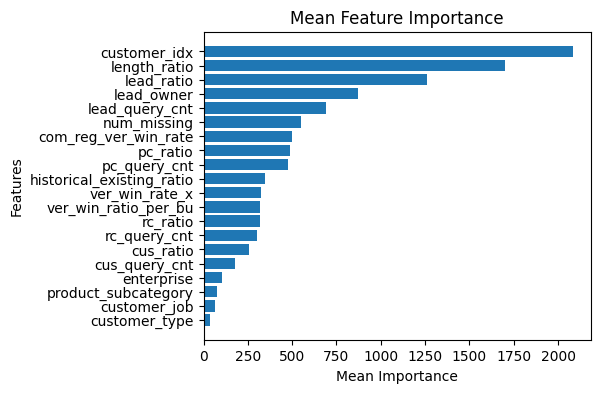

In [ ]:
# 특징 중요도와 특징 이름을 정렬
top_features = 20
sorted_indices = np.argsort(-np.mean(feature_importance_lgb_list1, axis=0))[::-1]
sorted_feature_names = [lgb_model1.booster_.feature_name()[i] for i in sorted_indices][-top_features:]
sorted_mean_importance = np.mean(feature_importance_lgb_list1, axis=0)[sorted_indices][-top_features:]

# 바 차트 그리기
plt.figure(figsize=(5 , 4))
plt.barh(sorted_feature_names, sorted_mean_importance)
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.title('Mean Feature Importance')
plt.show()

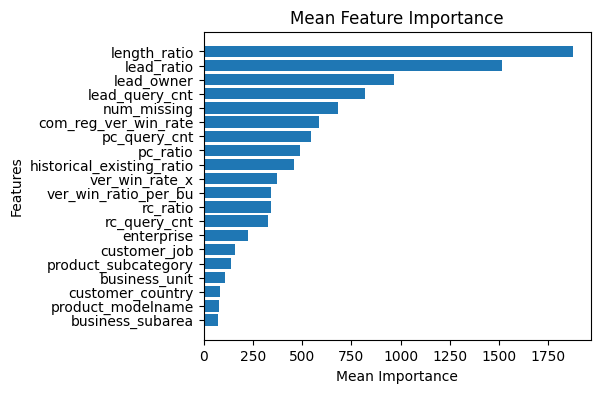

In [ ]:
# 특징 중요도와 특징 이름을 정렬
top_features = 20
sorted_indices = np.argsort(-np.mean(feature_importance_lgb_list2, axis=0))[::-1]
sorted_feature_names = [lgb_model2.booster_.feature_name()[i] for i in sorted_indices][-top_features:]
sorted_mean_importance = np.mean(feature_importance_lgb_list2, axis=0)[sorted_indices][-top_features:]

# 바 차트 그리기
plt.figure(figsize=(5 , 4))
plt.barh(sorted_feature_names, sorted_mean_importance)
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.title('Mean Feature Importance')
plt.show()

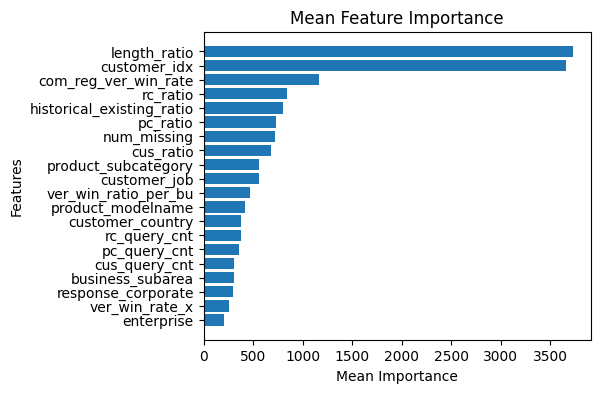

In [ ]:
# 특징 중요도와 특징 이름을 정렬
top_features = 20
sorted_indices = np.argsort(-np.mean(feature_importance_lgb_list3, axis=0))[::-1]
sorted_feature_names = [lgb_model3.booster_.feature_name()[i] for i in sorted_indices][-top_features:]
sorted_mean_importance = np.mean(feature_importance_lgb_list3, axis=0)[sorted_indices][-top_features:]

# 바 차트 그리기
plt.figure(figsize=(5 , 4))
plt.barh(sorted_feature_names, sorted_mean_importance)
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.title('Mean Feature Importance')
plt.show()

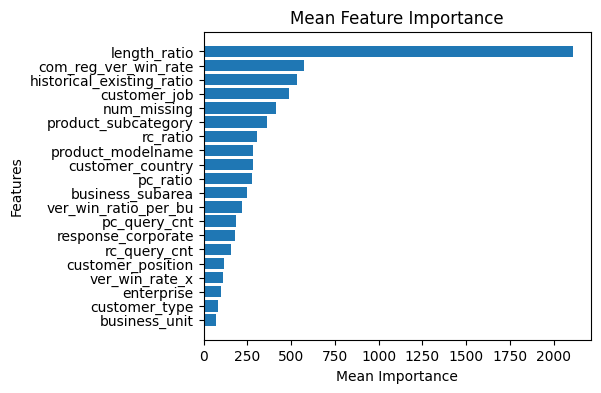

In [ ]:
# 특징 중요도와 특징 이름을 정렬
top_features = 20
sorted_indices = np.argsort(-np.mean(feature_importance_lgb_list4, axis=0))[::-1]
sorted_feature_names = [lgb_model4.booster_.feature_name()[i] for i in sorted_indices][-top_features:]
sorted_mean_importance = np.mean(feature_importance_lgb_list4, axis=0)[sorted_indices][-top_features:]

# 바 차트 그리기
plt.figure(figsize=(5 , 4))
plt.barh(sorted_feature_names, sorted_mean_importance)
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.title('Mean Feature Importance')
plt.show()

### 테스트 데이터 예측

In [ ]:
oof_test_preds1 = oof_lgb_test_preds1
oof_test_preds2 = oof_lgb_test_preds2
oof_test_preds3 = oof_lgb_test_preds3
oof_test_preds4 = oof_lgb_test_preds4

In [ ]:
# 예측에 필요한 데이터 분리 (Tuning 해야함 -> gridSearch)
test_pred1 = np.where(oof_test_preds1 >= 0.3, 1, 0)
test_pred2 = np.where(oof_test_preds2 >= 0.3, 1, 0)
test_pred3 = np.where(oof_test_preds3 >= 0.2, 1, 0)
test_pred4 = np.where(oof_test_preds4 >= 0.2, 1, 0)


df_test1['is_converted']=test_pred1
df_test2['is_converted']=test_pred2
df_test3['is_converted']=test_pred3
df_test4['is_converted']=test_pred4

In [ ]:
print(sum(test_pred1), df_test1.shape[0]) # cus, lead_owner 있음
print(sum(test_pred2), df_test2.shape[0]) # lead_owner 있음
print(sum(test_pred3), df_test3.shape[0]) # cus 있음
print(sum(test_pred4), df_test4.shape[0]) # 완전 새로운
print('전체 true 개수: ', sum(test_pred1)+sum(test_pred2)+sum(test_pred3)+sum(test_pred4))

185 658
859 3671
25 80
391 862
전체 true 개수:  1460


## 4. 제출하기

### 제출 파일 작성

In [ ]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv('/content/drive/MyDrive/lg/submission.csv')
df_sub = df_sub.drop('is_converted', axis=1)
df_sub=pd.merge(df_sub, df_test1[['id', 'is_converted']], on='id', how='left')
df_sub['is_converted'] = df_sub['is_converted'].fillna(0)
df_sub=pd.merge(df_sub, df_test2[['id', 'is_converted']], on='id', how='left')
df_sub['is_converted_y'] = df_sub['is_converted_y'].fillna(0)
df_sub['is_converted'] = df_sub['is_converted_x'] + df_sub['is_converted_y']
df_sub = df_sub.drop(['is_converted_x', 'is_converted_y'], axis=1)
df_sub=pd.merge(df_sub, df_test3[['id', 'is_converted']], on='id', how='left')
df_sub['is_converted_y'] = df_sub['is_converted_y'].fillna(0)
df_sub['is_converted'] = df_sub['is_converted_x'] + df_sub['is_converted_y']
df_sub = df_sub.drop(['is_converted_x', 'is_converted_y'], axis=1)
df_sub=pd.merge(df_sub, df_test4[['id', 'is_converted']], on='id', how='left')
df_sub['is_converted_y'] = df_sub['is_converted_y'].fillna(0)
df_sub['is_converted'] = df_sub['is_converted_x'] + df_sub['is_converted_y']
df_sub = df_sub.drop(['is_converted_x', 'is_converted_y'], axis=1)

df_sub.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/lg/submission.csv'

In [ ]:
# DataFrame을 CSV 파일로 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**